# Notebook Dedicado a construir modelo Optimizados en cada regimen de energia usando Optuna

Regimes de prueba:

- [2,4] MeV (Hecho) - Optimizado -> Si, pesimos resultados. trial = 300
- [4,6] MeV (hecho) - Optimizado ?
- [2,10] MeV (hecho) - Optimizado -> Si, (esperando resultados). trial = 50
- [2,6] MeV - optimizado (hecho)
- [0.5, 16] MeV- Optimizado (trial = 100)

In [1]:
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, concatenate, Dropout
from keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.utils import shuffle
import optuna
from keras.backend import clear_session

In [2]:
import colorsys
# Función para generar variantes más claras y más oscuras de un color
def generate_color_variants(base_color, num_variants, factor = 0.3):
    # Convertir el color base a valores de HSV
    r, g, b = base_color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    # Generar variantes
    variants = []
    for i in range(1, num_variants + 1):
        # Hacer el color más claro
        lighter = colorsys.hls_to_rgb(h, min(1, l * (1 + factor * i)), s)
        # Hacer el color más oscuro
        darker = colorsys.hls_to_rgb(h, max(0, l * (1 - factor * i)), s)
        variants.append(lighter)
        variants.append(darker)
        
    return variants

# Color base (rojo)
base_red = (1, 0, 0) # RGB para rojo puro
# Color base (azuk)
base_blue = (0, 0, 1) # RGB para azul puro
num_variants = 5

red_variants = generate_color_variants(base_red, num_variants)
blue_variants = generate_color_variants(base_blue, num_variants)

# 1 - Load Data

In [3]:
image_dim = (10, 10)
df_train = shuffle(pd.read_csv("Data/High Stat/Elegant Data Frame Structure/train/df1_5500_10_(2.5_14)_(-5_7).csv"))
df_test = shuffle(pd.read_csv("Data/High Stat/Elegant Data Frame Structure/test/df2_test_5500_10_(2.5_14)_(-5_7).csv"))

In [4]:
df_train.describe()

,Unnamed: 0,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
count,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,...,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000,173598.000000
mean,43399.000000,0.103205,0.088559,0.097311,0.101131,0.101650,0.102036,0.102622,0.102890,0.103442,...,0.100280,0.100717,0.100868,0.101956,0.102550,0.103799,4.426912,4098.779480,0.500000,0.500000
std,25056.785175,0.255754,0.217296,0.196318,0.174071,0.154458,0.139249,0.126640,0.115322,0.105307,...,0.150967,0.136518,0.123935,0.113753,0.103857,0.095470,1.597788,1070.793561,0.500001,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500081,68.754494,0.000000,0.000000
25%,21699.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022222,0.029412,...,0.000000,0.000000,0.000000,0.022727,0.029412,0.034483,3.441121,3427.102417,0.000000,0.000000
50%,43399.000000,0.000000,0.000000,0.000000,0.000000,0.025641,0.047619,0.055556,0.062500,0.068966,...,0.031250,0.047619,0.055556,0.062500,0.068966,0.075000,3.875119,4336.404053,0.500000,0.500000
75%,65098.750000,0.000000,0.000000,0.111111,0.142857,0.142857,0.150000,0.150000,0.148148,0.148148,...,0.142857,0.142857,0.146341,0.147059,0.147059,0.147059,4.785668,4974.712646,1.000000,1.000000
max,86798.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.896552,0.816327,0.833333,...,1.000000,1.000000,0.909091,0.791667,0.840000,0.818182,13.546737,5499.991211,1.000000,1.000000


In [5]:
df_test.describe()

,Unnamed: 0,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm),IsNu,IsTl
count,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,...,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000,93042.000000
mean,23260.000000,0.102381,0.086131,0.096609,0.100616,0.101405,0.101727,0.101638,0.101978,0.102806,...,0.100970,0.101846,0.102335,0.103169,0.103960,0.105062,4.420709,4100.394531,0.500000,0.500000
std,13429.528103,0.255092,0.214259,0.195932,0.174412,0.154686,0.139989,0.126693,0.115149,0.105888,...,0.151606,0.137405,0.124569,0.113891,0.104821,0.096305,1.587834,1070.269563,0.500003,0.500003
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.500030,106.154373,0.000000,0.000000
25%,11630.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.028571,...,0.000000,0.000000,0.000000,0.023256,0.029851,0.035088,3.440157,3427.727112,0.000000,0.000000
50%,23260.000000,0.000000,0.000000,0.000000,0.000000,0.023533,0.047619,0.052632,0.061224,0.068182,...,0.032258,0.050000,0.055556,0.062500,0.071429,0.076923,3.873259,4335.557373,0.500000,0.500000
75%,34890.000000,0.000000,0.000000,0.111111,0.142857,0.142857,0.148148,0.148148,0.147059,0.147059,...,0.142857,0.148148,0.150000,0.150000,0.148649,0.148148,4.795290,4979.039795,1.000000,1.000000
max,46520.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.870968,0.814815,0.821429,...,1.000000,1.000000,0.857143,0.785714,0.766667,0.750000,13.663218,5499.998047,1.000000,1.000000


# 2 - Data Preprocesing

## 2.1 - Extract Information

In [6]:
pixel_pattern = r'^pixel_\d+$'
energy_cut_train = 12
energy_cut_test = 12

### Extracting training Data

In [7]:
#Separate signal from background 
dataset_sig_train = (df_train[df_train['IsNu'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])
dataset_bkg_train = (df_train[df_train['IsTl'] == 1]).drop(columns=['Unnamed: 0']).reset_index().drop(columns = ['index'])

#cut in solar energy
dataset_sig_train = (dataset_sig_train[dataset_sig_train['energy (MeV)'] <= energy_cut_train])

#Igualar cantidad de datos de neutrinos solares y de Tálio
N_solar_ev = dataset_sig_train.shape[0]
N_Tl_ev = dataset_bkg_train.shape[0]

if N_solar_ev > N_Tl_ev:
    dataset_sig_train = (dataset_sig_train.iloc[:N_Tl_ev, :]).reset_index().drop(columns = ['index'])

else:
    dataset_bkg_train = (dataset_bkg_train.iloc[:N_solar_ev, :].reset_index()).drop(columns = ['index'])
    
#Separate Features for signal and background
df_pixel_sig_train = dataset_sig_train.filter(regex=pixel_pattern)
df_energy_sig_train = (dataset_sig_train[['energy (MeV)']])
df_radi_sig_train = (dataset_sig_train[['radius (mm)']])
df_label_sig_train = pd.DataFrame(dataset_sig_train, columns = ['IsNu', 'IsTl'])

df_pixel_bkg_train = dataset_bkg_train.filter(regex=pixel_pattern)
df_energy_bkg_train = (dataset_bkg_train[['energy (MeV)']])
df_radi_bkg_train = (dataset_bkg_train[['radius (mm)']])
df_label_bkg_train = pd.DataFrame(dataset_bkg_train, columns = ['IsNu', 'IsTl'])

In [8]:
df_pixel_sig_train.shape

(86726, 100)

In [9]:
df_pixel_bkg_train.shape

(86726, 100)

### Extracting test Data

In [10]:
equal_evs = True #Cambiar a True para Igualar eventos de 208-Tl y Solar Nu en test dataset!

#Separate signal from background 
dataset_sig_test = (df_test[df_test['IsNu'] == 1]).drop(columns=['Unnamed: 0'])
dataset_bkg_test = (df_test[df_test['IsTl'] == 1]).drop(columns=['Unnamed: 0'])

#cut in solar energy
dataset_sig_test = (dataset_sig_test[dataset_sig_test['energy (MeV)'] <= energy_cut_test])

if equal_evs:
    #Igualar cantidad de datos de neutrinos solares y de Tálio
    N_solar_ev = dataset_sig_test.shape[0]
    N_Tl_ev = dataset_bkg_test.shape[0]
    
    if N_solar_ev > N_Tl_ev:
        dataset_sig_test = (dataset_sig_test.iloc[:N_Tl_ev, :]).reset_index().drop(columns = ['index'])
    
    else:
        dataset_bkg_test = (dataset_bkg_test.iloc[:N_solar_ev, :].reset_index()).drop(columns = ['index'])

#Separate Features for signal and background
df_pixel_sig_test = dataset_sig_test.filter(regex=pixel_pattern)
df_energy_sig_test = (dataset_sig_test[['energy (MeV)']])
df_radi_sig_test = (dataset_sig_test[['radius (mm)']])
df_label_sig_test = pd.DataFrame(dataset_sig_test, columns = ['IsNu', 'IsTl'])

df_pixel_bkg_test = dataset_bkg_test.filter(regex=pixel_pattern)
df_energy_bkg_test= (dataset_bkg_test[['energy (MeV)']])
df_radi_bkg_test = (dataset_bkg_test[['radius (mm)']])
df_label_bkg_test = pd.DataFrame(dataset_bkg_test, columns = ['IsNu', 'IsTl'])

In [11]:
df_pixel_sig_test.shape

(46492, 100)

In [12]:
df_pixel_bkg_test.shape

(46492, 100)

#### Observe plots of DataSet

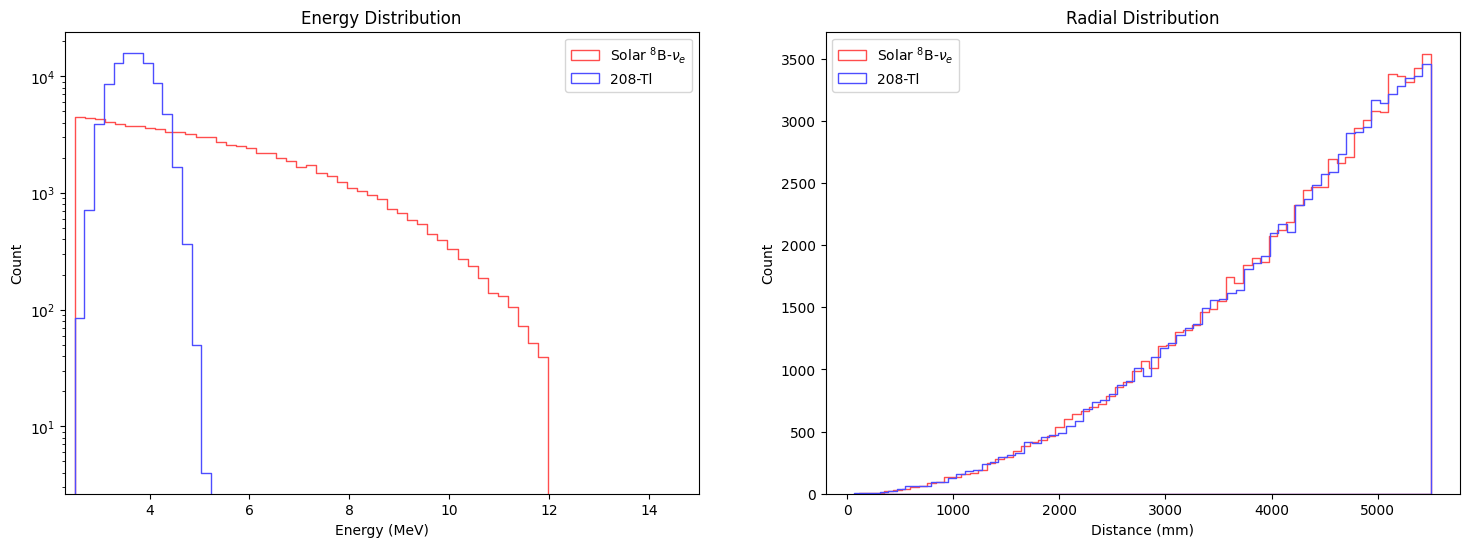

In [70]:
#default (testing data) Energy_Solar_and_Tl_distribution

binwidth_en = 0.2
binwidth_rad = 80
alpha = 0.0

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

#Energy Distribution
sn.histplot(df_energy_sig_train.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = red_variants[0], element="step", label = 'Solar $^8$B-$ν_e$')
sn.histplot(df_energy_bkg_train.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = blue_variants[0], element="step", label = '208-Tl')

#Radial Distribution
sn.histplot(df_radi_sig_train.values.T[0], ax = axes[1], binwidth = binwidth_rad, alpha = alpha, color = red_variants[0], element="step", label = 'Solar $^8$B-$ν_e$')
sn.histplot(df_radi_bkg_train.values.T[0], ax = axes[1], binwidth = binwidth_rad, alpha = alpha, color = blue_variants[0], element="step", label = '208-Tl')


axes[0].set_title('Energy Distribution', fontsize = 12)
axes[1].set_title('Radial Distribution', fontsize = 12)
#plt.suptitle('Energy: [2.5, 12] MeV - R < 5500 (mm)', fontsize = 11)

axes[0].set_xlabel('Energy (MeV)')
axes[1].set_xlabel('Distance (mm)')
axes[0].legend(loc = 'upper right')
axes[1].legend(loc = 'upper left')

axes[0].set_yscale('log')

axes[0].set_xlim(2.3, 15)

#plt.savefig('figs/default_Energy_and_Radius_Distribution.png', format = 'png', bbox_inches = 'tight')
plt.show()

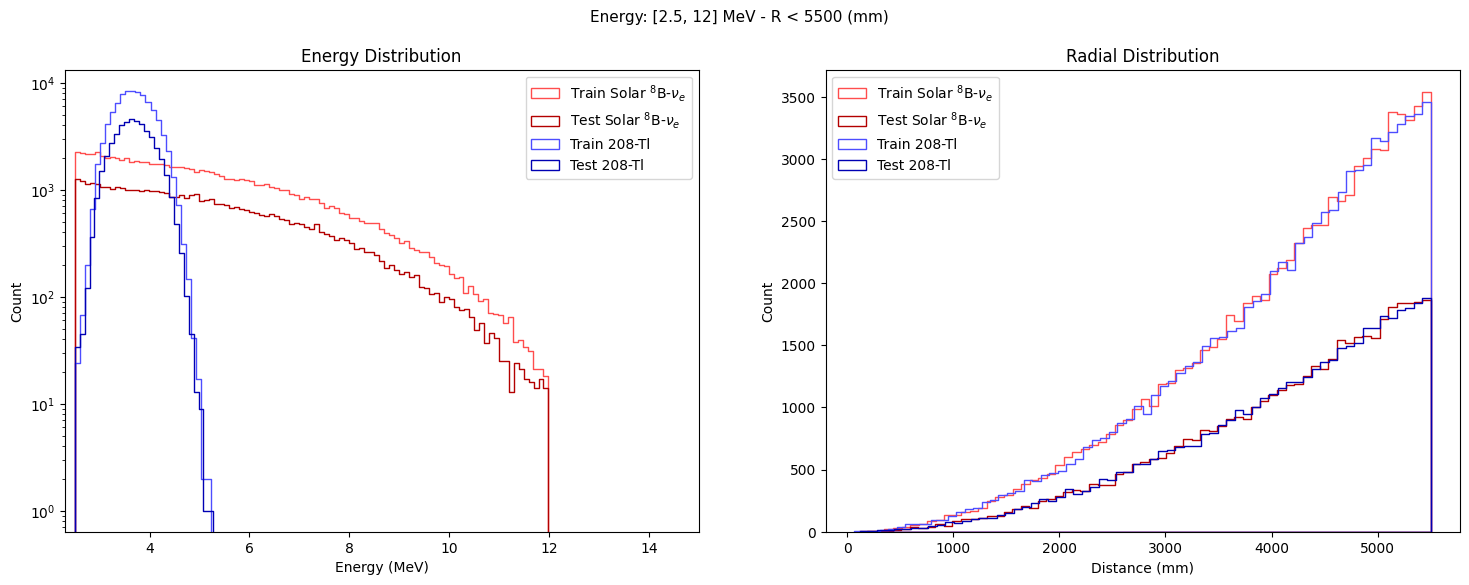

In [86]:
binwidth_en = 0.1
binwidth_rad = 80
alpha = 0.0

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

#Energy Distribution
sn.histplot(df_energy_sig_train.values.T[0], ax = axes[0], binwidth = binwidth_en, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $^8$B-$ν_e$')
sn.histplot(df_energy_sig_test.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $^8$B-$ν_e$')
sn.histplot(df_energy_bkg_train.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = blue_variants[0], element="step", label = 'Train 208-Tl')
sn.histplot(df_energy_bkg_test.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = blue_variants[1], element="step", label = 'Test 208-Tl')

#Radial Distribution
sn.histplot(df_radi_sig_train.values.T[0], ax = axes[1], binwidth = binwidth_rad, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $^8$B-$ν_e$')
sn.histplot(df_radi_sig_test.values.T[0], ax = axes[1], binwidth = binwidth_rad, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $^8$B-$ν_e$')
sn.histplot(df_radi_bkg_train.values.T[0], ax = axes[1], binwidth = binwidth_rad, alpha = alpha, color = blue_variants[0], element="step", label = 'Train 208-Tl')
sn.histplot(df_radi_bkg_test.values.T[0], ax = axes[1], binwidth = binwidth_rad, alpha = alpha, color = blue_variants[1], element="step", label = 'Test 208-Tl')

#Vol. Norm. Radial Distribution


axes[0].set_title('Energy Distribution', fontsize = 12)
axes[1].set_title('Radial Distribution', fontsize = 12)
plt.suptitle('Energy: [2.5, 12] MeV - R < 5500 (mm)', fontsize = 11)

axes[0].set_xlabel('Energy (MeV)')
axes[1].set_xlabel('Distance (mm)')
axes[0].legend(loc = 'upper right')
axes[1].legend(loc = 'upper left')

axes[0].set_yscale('log')

axes[0].set_xlim(2.3, 15)

#plt.savefig('figs/Optimized Models/10x10/default_Energy_and_Radius_Distribution.png', format = 'png', bbox_inches = 'tight')
plt.show()

## 2.2 - Data Split (Train, Test and Validation)

In [13]:
pixel_sig_train = df_pixel_sig_train
label_sig_train = df_label_sig_train
energy_sig_train = df_energy_sig_train
radi_sig_train = df_radi_sig_train

pixel_bkg_train = df_pixel_bkg_train
label_bkg_train = df_label_bkg_train
energy_bkg_train = df_energy_bkg_train
radi_bkg_train = df_radi_bkg_train

## 2.4 - Data Transformation

### 2.4.1 - Standard Scaler

In [14]:
# A Standard Scalar is used as transform, with a mean_value = 0 and std_deviation = 1

#This scaler is used in data we dont intend to recover in org. scale
scaler = StandardScaler()  

#Scalers applied to (energy, radius) of testing data, since we want to recover its org. representation
scaler_en_sig = StandardScaler()
scaler_en_bkg = StandardScaler()

scaler_rad_sig = StandardScaler()
scaler_rad_bkg = StandardScaler()

#std(Train):
pixel_sig_train_transf = scaler.fit_transform(pixel_sig_train)
pixel_bkg_train_transf = scaler.fit_transform(pixel_bkg_train)

energy_sig_train_transf = scaler.fit_transform(energy_sig_train).T[0]
energy_bkg_train_transf = scaler.fit_transform(energy_bkg_train).T[0]

radi_sig_train_transf = scaler.fit_transform(radi_sig_train).T[0]
radi_bkg_train_transf = scaler.fit_transform(radi_bkg_train).T[0]

#std(Validation):
#pixel_sig_val_transf = scaler.fit_transform(pixel_sig_val)
#pixel_bkg_val_transf = scaler.fit_transform(pixel_bkg_val)

#energy_sig_val_transf = scaler.fit_transform(energy_sig_val).T[0]
#energy_bkg_val_transf = scaler.fit_transform(energy_bkg_val).T[0]

#radi_sig_val_transf = scaler.fit_transform(radi_sig_val).T[0]
#radi_bkg_val_transf = scaler.fit_transform(radi_bkg_val).T[0]

#std(test):
pixel_sig_test_transf = scaler.fit_transform(df_pixel_sig_test)
pixel_bkg_test_transf = scaler.fit_transform(df_pixel_bkg_test)

energy_sig_test_transf = scaler_en_sig.fit_transform(df_energy_sig_test).T[0]
energy_bkg_test_transf = scaler_en_bkg.fit_transform(df_energy_bkg_test).T[0]

radi_sig_test_transf = scaler_rad_sig.fit_transform(df_radi_sig_test).T[0]
radi_bkg_test_transf = scaler_rad_bkg.fit_transform(df_radi_bkg_test).T[0]

### 2.4.2 - Plots of Standardized Energy and Radius

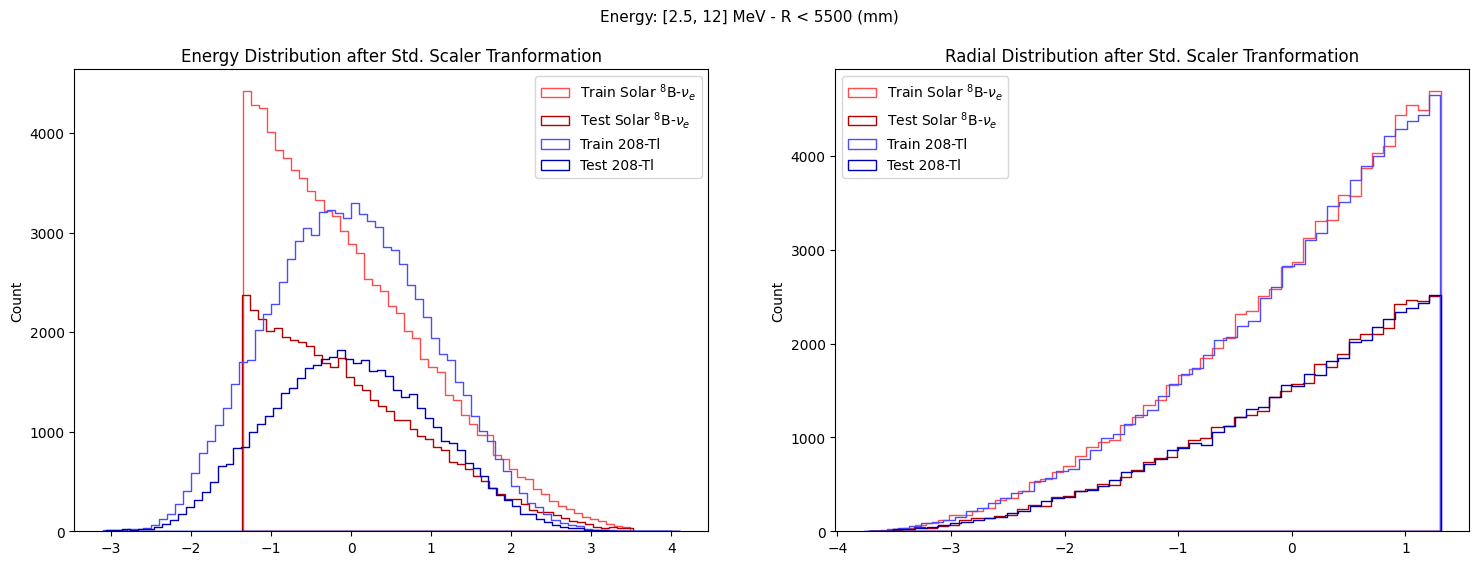

In [21]:

binwidth = 0.1
alpha = 0.0

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

#StandScaler energy
sn.histplot(energy_sig_train_transf, ax = axes[0], binwidth = binwidth, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $^8$B-$ν_e$')
sn.histplot(energy_sig_test_transf, ax = axes[0], binwidth = binwidth, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $^8$B-$ν_e$')
sn.histplot(energy_bkg_train_transf, ax = axes[0], binwidth = binwidth, alpha = alpha, color = blue_variants[0], element="step", label = 'Train 208-Tl')
sn.histplot(energy_bkg_test_transf, ax = axes[0], binwidth = binwidth, alpha = alpha, color = blue_variants[1], element="step", label = 'Test 208-Tl')

#StandScaler Radius
sn.histplot(radi_sig_train_transf, ax = axes[1], binwidth = binwidth, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $^8$B-$ν_e$')
sn.histplot(radi_sig_test_transf, ax = axes[1], binwidth = binwidth, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $^8$B-$ν_e$')
sn.histplot(radi_bkg_train_transf, ax = axes[1], binwidth = binwidth, alpha = alpha, color = blue_variants[0], element="step", label = 'Train 208-Tl')
sn.histplot(radi_bkg_test_transf, ax = axes[1], binwidth = binwidth, alpha = alpha, color = blue_variants[1], element="step", label = 'Test 208-Tl')

axes[0].set_title('Energy Distribution after Std. Scaler Tranformation', fontsize = 12)
axes[1].set_title('Radial Distribution after Std. Scaler Tranformation', fontsize = 12)
plt.suptitle('Energy: [2.5, 12] MeV - R < 5500 (mm)', fontsize = 11)

axes[0].legend(loc = 'upper right')
axes[1].legend(loc = 'upper left')

#axes[0].set_yscale('log')

#axes[0].set_xlim(2.3, 15)

#plt.savefig('figs/Optimized Models/10x10/Std_Scaled_Energy_and_Radius.png', format = 'png', bbox_inches = 'tight')
plt.show()

### 2.4.3 - Volume Normalization (radius)

In [15]:
vol = 5500**3

radi_sig_train_transf = (radi_sig_train**3)/vol
radi_bkg_train_transf = (radi_bkg_train**3)/vol

#radi_sig_val_transf = (radi_sig_val**3)/vol
#radi_bkg_val_transf = (radi_bkg_val**3)/vol

radi_sig_test_transf = (df_radi_sig_test**3)/vol
radi_bkg_test_transf = (df_radi_bkg_test**3)/vol

### 2.4.4 - Plots of Standardized Energy and Volume Norm

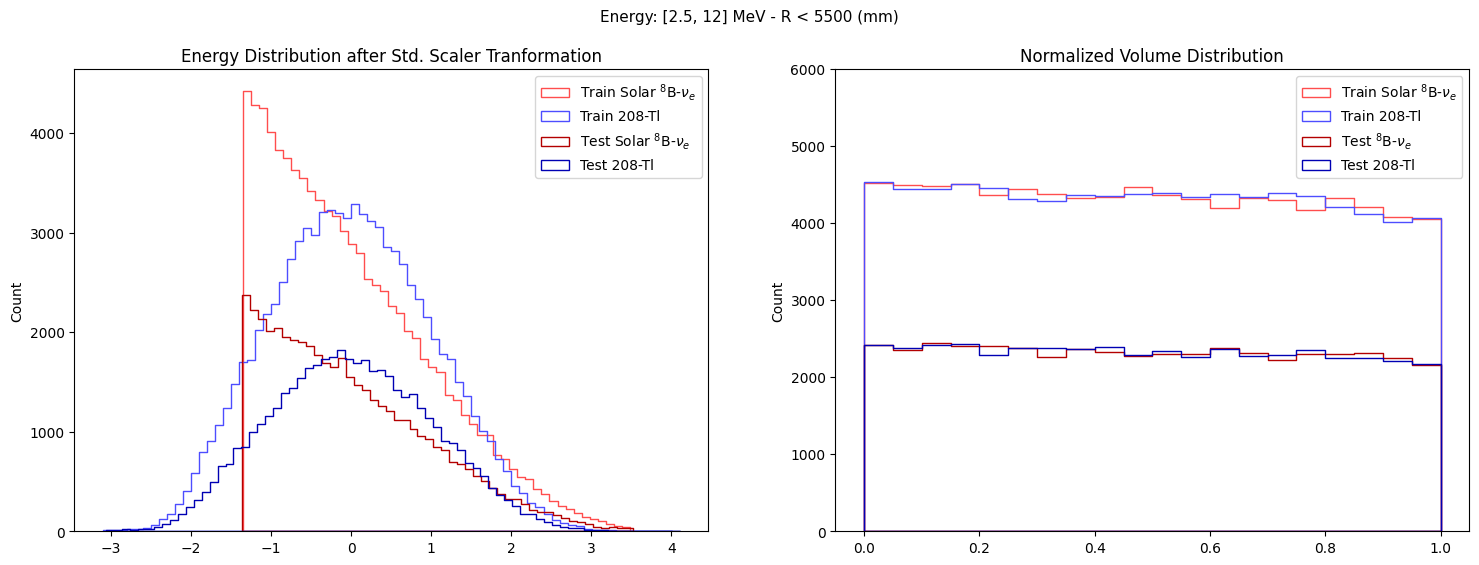

In [84]:
binwidth_en = 0.1
binwidth_rad = 0.05
alpha = 0.0

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

# energy
sn.histplot(energy_sig_train_transf, ax = axes[0], binwidth = binwidth, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $^8$B-$ν_e$')
sn.histplot(energy_bkg_train_transf, ax = axes[0], binwidth = binwidth, alpha = alpha, color = blue_variants[0], element="step", label = 'Train 208-Tl')
sn.histplot(energy_sig_test_transf, ax = axes[0], binwidth = binwidth, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $^8$B-$ν_e$')
sn.histplot(energy_bkg_test_transf, ax = axes[0], binwidth = binwidth, alpha = alpha, color = blue_variants[1], element="step", label = 'Test 208-Tl')

# Radius to Normalized Volume
sn.histplot(radi_sig_train_transf.values.T[0], binwidth = binwidth_rad, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $^8$B-$ν_e$')
sn.histplot(radi_bkg_train_transf.values.T[0], binwidth = binwidth_rad, alpha = alpha, color = blue_variants[0], element="step", label = 'Train 208-Tl')
sn.histplot(radi_sig_test_transf.values.T[0], binwidth = binwidth_rad, alpha = alpha, color = red_variants[1], element="step", label = 'Test $^8$B-$ν_e$')
sn.histplot(radi_bkg_test_transf.values.T[0], binwidth = binwidth_rad, alpha = alpha, color = blue_variants[1], element="step", label = 'Test 208-Tl')

axes[0].set_title('Energy Distribution after Std. Scaler Tranformation', fontsize = 12)
axes[1].set_title('Normalized Volume Distribution', fontsize = 12)

plt.suptitle('Energy: [2.5, 12] MeV - R < 5500 (mm)', fontsize = 11)

axes[0].legend(loc = 'upper right')
axes[1].legend(loc = 'upper right')

#axes[0].set_yscale('log')
axes[1].set_ylim(0, 6000)

#plt.savefig('figs/Optimized Models/10x10/Std_Scaled_Energy_and_Vol_Norm.png', format = 'png', bbox_inches = 'tight')
plt.show()

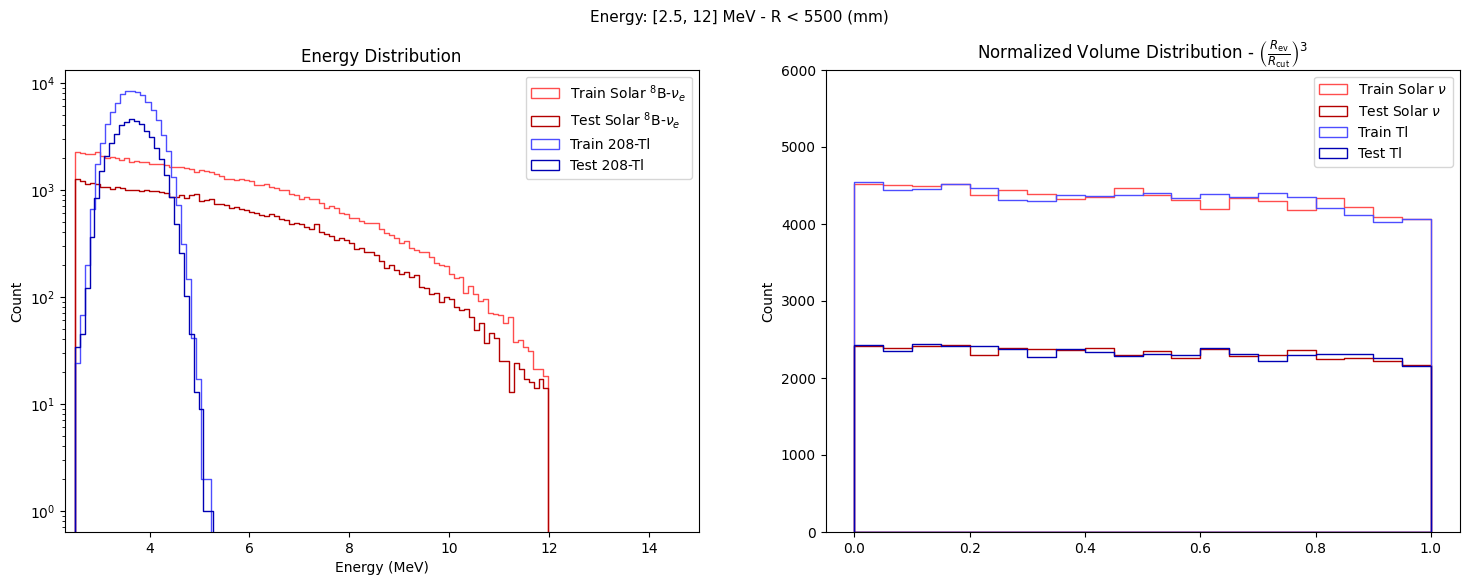

In [88]:
#Plots of flat Energy and Volume Norm

binwidth_en = 0.1
binwidth_rad = 0.05
alpha = 0.0

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

#StandScaler energy
sn.histplot(df_energy_sig_train.values.T[0], ax = axes[0], binwidth = binwidth_en, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $^8$B-$ν_e$')
sn.histplot(df_energy_sig_test.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $^8$B-$ν_e$')
sn.histplot(df_energy_bkg_train.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = blue_variants[0], element="step", label = 'Train 208-Tl')
sn.histplot(df_energy_bkg_test.values.T[0], ax = axes[0],binwidth = binwidth_en, alpha = alpha, color = blue_variants[1], element="step", label = 'Test 208-Tl')

# Radius to Normalized Volume
sn.histplot(radi_sig_train_transf.values.T[0], binwidth = binwidth_rad, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $ν$')
sn.histplot(radi_bkg_test_transf.values.T[0], binwidth = binwidth_rad, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $ν$')
sn.histplot(radi_bkg_train_transf.values.T[0], binwidth = binwidth_rad, alpha = alpha, color = blue_variants[0], element="step", label = 'Train Tl')
sn.histplot(radi_sig_test_transf.values.T[0], binwidth = binwidth_rad, alpha = alpha, color = blue_variants[1], element="step", label = 'Test Tl')

axes[0].set_title('Energy Distribution', fontsize = 12)
axes[1].set_title(r'Normalized Volume Distribution - $\left(\frac{R_{\text{ev}}}{R_{\text{cut}}}\right)^3$', fontsize = 12)

axes[0].set_xlabel('Energy (MeV)')
#axes[1].set_xlabel('Distance (mm)')

plt.suptitle('Energy: [2.5, 12] MeV - R < 5500 (mm)', fontsize = 11)

axes[0].legend(loc = 'upper right')
axes[1].legend(loc = 'upper right')

axes[0].set_yscale('log')
axes[0].set_xlim(2.3, 15)
axes[1].set_ylim(0, 6000)

#plt.savefig('figs/Energy_cut_and_Vol_Norm_Distribution_5500_(2.5_12)_(-5_7).png', format = 'png', bbox_inches = 'tight')
plt.show()

### 2.4.5 - Standard Scaler of Volume Normalization

CUIDADO QUE SE HAN REDEFINIDO VARIABLE CON SU PROPIO NOMBRE!

In [16]:
scaler_rad_sig = StandardScaler()
scaler_rad_bkg = StandardScaler()

radi_sig_train_transf = scaler.fit_transform(radi_sig_train_transf).T[0]
radi_bkg_train_transf = scaler.fit_transform(radi_bkg_train_transf).T[0]

radi_sig_test_transf = scaler_rad_sig.fit_transform(radi_sig_test_transf).T[0]
radi_bkg_test_transf = scaler_rad_bkg.fit_transform(radi_bkg_test_transf).T[0]

### 2.4.6 - Plots of Standardized Energy and Standardized Volume Norm

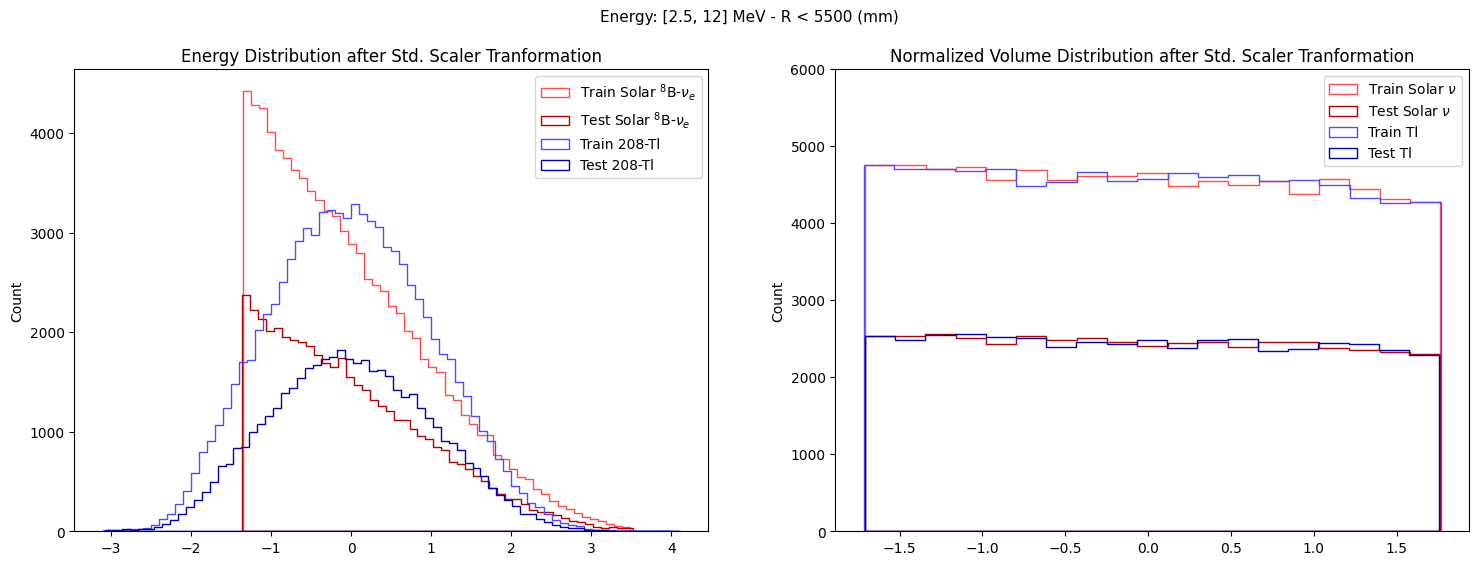

In [19]:
binwidth_en = 0.1
binwidth_rad = 0.18
alpha = 0.0

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

#StandScaler energy
sn.histplot(energy_sig_train_transf, ax = axes[0], binwidth = binwidth_en, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $^8$B-$ν_e$')
sn.histplot(energy_sig_test_transf, ax = axes[0], binwidth = binwidth_en, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $^8$B-$ν_e$')
sn.histplot(energy_bkg_train_transf, ax = axes[0], binwidth = binwidth_en, alpha = alpha, color = blue_variants[0], element="step", label = 'Train 208-Tl')
sn.histplot(energy_bkg_test_transf, ax = axes[0], binwidth = binwidth_en, alpha = alpha, color = blue_variants[1], element="step", label = 'Test 208-Tl')

# Radius to Normalized Volume
sn.histplot(radi_sig_train_transf, binwidth = binwidth_rad, alpha = alpha, color = red_variants[0] ,element="step", label = 'Train Solar $ν$')
sn.histplot(radi_bkg_test_transf, binwidth = binwidth_rad, alpha = alpha, color = red_variants[1], element="step", label = 'Test Solar $ν$')
sn.histplot(radi_bkg_train_transf, binwidth = binwidth_rad, alpha = alpha, color = blue_variants[0], element="step", label = 'Train Tl')
sn.histplot(radi_sig_test_transf, binwidth = binwidth_rad, alpha = alpha, color = blue_variants[1], element="step", label = 'Test Tl')

axes[0].set_title('Energy Distribution after Std. Scaler Tranformation', fontsize = 12)
axes[1].set_title('Normalized Volume Distribution after Std. Scaler Tranformation', fontsize = 12)
plt.suptitle('Energy: [2.5, 12] MeV - R < 5500 (mm)', fontsize = 11)

axes[0].legend(loc = 'upper right')
axes[1].legend(loc = 'upper right')

#axes[0].set_yscale('log')
axes[1].set_ylim(0, 6000)

#plt.savefig('figs/Optimized Models/10x10/Std_Scaled_Energy_and_Std_Scaled_Vol_Norm.png', format = 'png', bbox_inches = 'tight')
plt.show()

In [17]:
energy_sig_test_transf

array([-0.50732967,  0.06048579, -0.74576288, ..., -0.46693716,
       -0.91578886, -0.76544771])

### 2.4.7 - Split the test datasset

Split the test dataset into test_1 and test_2: one to optimize the model and the other to evaluate its predictions

In [18]:
pixel_sig_test_1_transf, pixel_sig_test_2_transf = np.split(pixel_sig_test_transf, 2)
pixel_bkg_test_1_transf, pixel_bkg_test_2_transf = np.split(pixel_bkg_test_transf, 2)

energy_sig_test_1_transf, energy_sig_test_2_transf = np.split(energy_sig_test_transf, 2)
energy_bkg_test_1_transf, energy_bkg_test_2_transf = np.split(energy_bkg_test_transf, 2)

radi_sig_test_1_transf, radi_sig_test_2_transf = np.split(radi_sig_test_transf, 2)
radi_bkg_test_1_transf, radi_bkg_test_2_transf = np.split(radi_bkg_test_transf, 2)

df_label_sig_test_1, df_label_sig_test_2 = np.split(df_label_sig_test, 2)
df_label_bkg_test_1, df_label_bkg_test_2 = np.split(df_label_bkg_test, 2)

C:\Users\joanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### 2.4.8 - Plots of the Distributions of the splitted test datasets

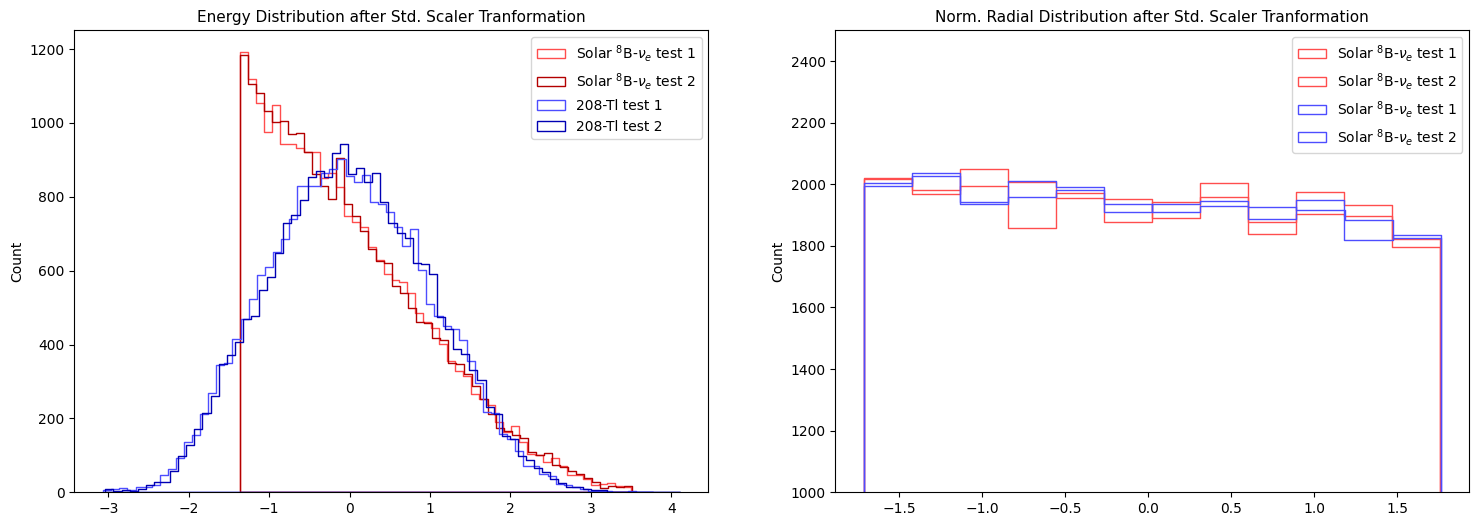

In [83]:
binwidth_en = 0.1
binwidth_rad = 0.3

fig, axes = plt.subplots(1, 2,  figsize=(18, 6))

#Energy Plots
sn.histplot(energy_sig_test_1_transf, ax = axes[0], binwidth = binwidth_en, color = red_variants[0], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test 1')
sn.histplot(energy_sig_test_2_transf, ax = axes[0], binwidth = binwidth_en, color = red_variants[1], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test 2')
sn.histplot(energy_bkg_test_1_transf, ax = axes[0], binwidth = binwidth_en, color = blue_variants[0], element = 'step', alpha = 0, label = '208-Tl test 1')
sn.histplot(energy_bkg_test_2_transf, ax = axes[0], binwidth = binwidth_en, color = blue_variants[1], element = 'step', alpha = 0, label = '208-Tl test 2')

#Radial Plots
sn.histplot(radi_sig_test_1_transf, ax = axes[1], binwidth = binwidth_rad, color = red_variants[0], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test 1')
sn.histplot(radi_sig_test_2_transf, ax = axes[1], binwidth = binwidth_rad, color = red_variants[0], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test 2')
sn.histplot(radi_bkg_test_1_transf, ax = axes[1], binwidth = binwidth_rad, color = blue_variants[0], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test 1')
sn.histplot(radi_bkg_test_2_transf, ax = axes[1], binwidth = binwidth_rad, color = blue_variants[0], element = 'step', alpha = 0, label = r'Solar $^8$B-$\nu_e$ test 2')

axes[0].legend(loc='upper right')
axes[0].set_title('Energy Distribution after Std. Scaler Tranformation', fontsize = 11)

axes[1].legend(loc='upper right')
axes[1].set_title('Norm. Radial Distribution after Std. Scaler Tranformation', fontsize = 11)
axes[1].set_ylim(1000, 2500)

#plt.savefig('figs/Optimized Models/10x10/Std_Rad_Norm_Vol and Std_Scaler_default Solar Energy/MLM4_5500_(2.5_12)_(-5_7)_aucOP_test_split/split_test_energy_transf.png', format = 'png', bbox_inches = 'tight')
plt.show()

## 2.5 - Unify DataSets

In [47]:
#Unify datasets

pixel_train = np.concatenate((pixel_sig_train_transf, pixel_bkg_train_transf))
energy_train = np.concatenate((energy_sig_train_transf, energy_bkg_train_transf))
radi_train = np.concatenate((radi_sig_train_transf, radi_bkg_train_transf))#.T[0]
label_train = np.concatenate((label_sig_train, label_bkg_train))

#pixel_val = np.concatenate((pixel_sig_val_transf, pixel_bkg_val_transf))
#energy_val = np.concatenate((energy_sig_val_transf, energy_bkg_val_transf))
#radi_val = np.concatenate((radi_sig_val_transf, radi_bkg_val_transf)).T[0]
#label_val = np.concatenate((label_sig_val, label_bkg_val))

pixel_test_1 = np.concatenate ((pixel_sig_test_1_transf, pixel_bkg_test_1_transf))
energy_test_1 = np.concatenate((energy_sig_test_1_transf, energy_bkg_test_1_transf))
radi_test_1 = np.concatenate((radi_sig_test_1_transf, radi_bkg_test_1_transf))#.T[0]
label_test_1 = np.concatenate((df_label_sig_test_1, df_label_bkg_test_1))

pixel_test_2 = np.concatenate ((pixel_sig_test_2_transf, pixel_bkg_test_2_transf))
energy_test_2 = np.concatenate((energy_sig_test_2_transf, energy_bkg_test_2_transf))
radi_test_2 = np.concatenate((radi_sig_test_2_transf, radi_bkg_test_2_transf))#.T[0]
label_test_2 = np.concatenate((df_label_sig_test_2, df_label_bkg_test_2))

In [48]:
radi_train

array([-0.0936565 ,  0.90130336,  0.51986544, ...,  0.69852656,
       -0.8252865 ,  0.83256799])

# 3 - Model Optimization

Hyperparams. to optimize:
- Learning Rate
- Number of neurons
- Number of Hidden layers:
   1) Hidden layers of Image
   4) Hidden layers before dropout layer
   5) Hidden layers after dropout layers
- Dropout Rate

In [50]:
def create_OP_Model(trial):

    #To save memory
    clear_session()
    
    #Optimization of Hyperparameters

    #Image layers suggestions
    n_image_layers = trial.suggest_int('N_Image_layers', 1, 10)

    #Energy layers suggestions
    n_en_layers = trial.suggest_int('N_Energy_layers', 1, 3)

    #Radius Layers suggestions
    n_rad_layers = trial.suggest_int('N_Radius_layers', 1, 3)

    # Nº of neurons suggestion
    #Before Dropout Layers - before concatenate
    n_bdo_layers = trial.suggest_int('N_bdo_layers', 1, 3)

    #After Dropout Layers
    n_ado_layers = trial.suggest_int('N_ado_layers', 1, 3)

    #Learning Rate and Dropout rate
    lr_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2)
    do_rate = trial.suggest_float('Drop_out_rate', 0, 0.7)

    #Number of neurons to be saved in each Optimized Layer
    n_units_image_ly = []
    n_units_en_ly = []
    n_units_rad_ly = []
    n_units_bdo_ly = []
    n_units_ado_ly = []

#-----------------------------------Arquitectura--------------------------------------------------------------------------
    #Input Layers
    #image
    image_dim = (10,10)
    input_im_shape = image_dim[0]*image_dim[1]
    input_image = Input(shape = (input_im_shape,), name = 'image_input')

    #Energy
    input_energy = Input(shape = (1,), name = 'energy_input')

    #Radius
    input_rad = Input(shape = (1,), name = 'radius_input')

    #Hidden Layers for Image (decreasing number of neurons)
    #first Image Hidden Layer
    n_neurons = trial.suggest_int('n_neurons_im_ly_0', 70, 90)
    image_ly = Dense(n_neurons, activation = 'gelu', name = 'im_ly_0')(input_image)
    for i in range(n_image_layers):
        if i == 0:
            n_neurons = trial.suggest_int(f'n_neurons_im_ly_{i+1}', 50, 70)
        else:
            n_neurons = trial.suggest_int(f'n_neurons_im_ly_{i+1}', 50, n_units_image_ly[i-1])  #Garantiza que el numero de neuronas disminuye, o es el mismo, con un minimo de 50!
        n_units_image_ly.append(n_neurons)
            
        image_ly = Dense(n_neurons, activation = 'gelu', name = f'im_ly_{i+1}')(image_ly)

    #Hidden Layers for Energy
    #first energy Hidden Layer
    n_en_neurons = trial.suggest_int('n_neurons_en_ly_0', 50, 70)
    energy_ly = Dense(n_en_neurons, activation = 'gelu', name = 'en_ly_0')(input_energy)
    for i in range(n_en_layers):
        if i == 0:
            n_en_neurons = trial.suggest_int(f'n_neurons_en_ly_{i+1}', 30, 50)
        else:
            n_en_neurons = trial.suggest_int(f'n_neurons_en_ly_{i+1}', 30, n_units_en_ly[i-1])
        n_units_en_ly.append(n_en_neurons)

        energy_ly = Dense(n_en_neurons, activation = 'gelu', name = f'en_ly_{i+1}')(energy_ly)

    #Hidden Layers for Radius
    #first radial hidden layer
    n_rad_neurons = trial.suggest_int('n_neurons_rad_ly_0', 50, 70)
    radial_ly = Dense(n_rad_neurons, activation = 'gelu', name = 'rad_ly_0')(input_rad)
    for i in range(n_rad_layers):
        if i == 0:
            n_rad_neurons = trial.suggest_int(f'n_neurons_rad_ly_{i+1}', 30, 50)
        else:
            n_rad_neurons = trial.suggest_int(f'n_neurons_rad_ly_{i+1}', 30, n_units_rad_ly[i-1])
        n_units_rad_ly.append(n_rad_neurons)

        radial_ly = Dense(n_rad_neurons, activation = 'gelu', name = f'rad_ly_{i+1}')(radial_ly)

    #Concatenate info:
    x = concatenate([image_ly, input_energy, input_rad])

    #first hidden layer after concatenate: Maximum neurons = min(en_units) + min(rad_units) + min(im_units) of last layer
    n_neurons = trial.suggest_int('n_neurons_bdo_ly_0', 30, n_rad_neurons + n_en_neurons + n_neurons)
    x = Dense(n_neurons, activation = 'gelu', name = 'bdo_ly_0')(x)
    for i in range(n_bdo_layers):
        if i == 0:
            n_neurons = trial.suggest_int(f'n_neurons_bdo_ly_{i+1}', 30, n_neurons)
        else:
            n_neurons = trial.suggest_int(f'n_neurons_bdo_ly_{i+1}', 30, n_units_bdo_ly[i-1])
        n_units_bdo_ly.append(n_neurons)
        x = Dense(n_neurons, activation = 'gelu', name = f'bdo_layer{i+1}')(x)

    #Dropout Layer
    x = Dropout(rate = do_rate)(x)

    for i in range(n_ado_layers):
        if i == 0:
            n_neurons = trial.suggest_int(f'n_neurons_ado_ly_{i}', 10, n_neurons)
        else:
            n_neurons = trial.suggest_int(f'n_neurons_ado_ly_{i}', 10, n_units_ado_ly[i-1])
        n_units_ado_ly.append(n_neurons)
        x = Dense(n_neurons, activation = 'gelu', name = f'ado_ly_{i}')(x)
        
    output_layer = Dense(2, activation = 'sigmoid', name = 'nu_predict')(x)

    model = Model(inputs = [input_image, input_energy, input_rad], outputs = output_layer)

    
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr_rate),
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  metrics = ['AUC', 'accuracy'])

    return model

    #-------------------------------------------------------------------------------------------------------------

def objective(trial):

    model = create_OP_Model(trial)
    
    history = model.fit(x = {'image_input': pixel_train, 'energy_input': energy_train, 'radius_input': radi_train}, 
                    y = {'nu_predict':label_train}, 
                    epochs = 150, 
                    batch_size = 100,
                    validation_split = 0.3,
                    #validation_data = ({'image_input': pixel_val.to_numpy(), 'energy_input': energy_val, 'radius_input': radi_val}, label_val),
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience = 30, min_delta = 1e-2)],
                    shuffle = True)
    
    X_sig_pred = model.predict([pixel_sig_test_1_transf, energy_sig_test_1_transf, radi_sig_test_1_transf])
    X_bkg_pred = model.predict([pixel_bkg_test_1_transf, energy_bkg_test_1_transf, radi_bkg_test_1_transf])

    # Criterio de Optimización: 1) Disminuir error de predicción (BCE), 2) Aumentar AUC (probar)
    #1)BCE
    #BCE = tf.keras.losses.BinaryCrossentropy()

    #2)AUC
    x_pred = np.concatenate((X_sig_pred, X_bkg_pred))         #Predicted
    x_exp = np.concatenate((df_label_sig_test_1, df_label_bkg_test_1))  #expected

    # Classification overall Model
    fpr, tpr, thresholds = roc_curve(np.concatenate((x_exp[:,0], x_exp[:,1])), np.concatenate((x_pred[:,0], x_pred[:,1])))
    auc_val = auc(fpr, tpr)

    return auc_val
    
    
    #BCE_sig = BCE(label_sig_test, X_sig_pred)  #(x_real, x_predicted)
    #BCE_bkg = BCE(label_bkg_test, X_bkg_pred)

    # Usar ambos errores de predicción para minimizar el error de predicción (modulo del error)
    #BCE_mod = np.sqrt(BCE_sig**2 + BCE_bkg**2)
    
    #return BCE_mod

In [51]:
study = optuna.create_study(directions = ["maximize"])
study.optimize(objective, n_trials = 100)
best_trial = study.best_trial

print("Best Hyperparms.:", study.best_trial.params) #To see the best 
print("Value: ", best_trial.value)

[I 2025-02-16 00:49:18,845] A new study created in memory with name: no-name-c31ac948-4d51-4b15-91a2-0c23aaf284cb



Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7326 - accuracy: 0.7175 - loss: 0.5949 - val_AUC: 3.0099e-04 - val_accuracy: 9.0322e-04 - val_loss: 1.3280
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7206 - accuracy: 0.7147 - loss: 0.5976 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2541
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7146 - accuracy: 0.7145 - loss: 0.5987 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2256
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7161 - accuracy: 0.7158 - loss: 0.5972 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2669
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7145 - accuracy: 0.7150 - loss: 0.5978 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2489
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7148 - accuracy: 0.7144 - loss: 0.5984 - val_AUC: 0.0000e+00 - val_accuracy: 0.0

[I 2025-02-16 00:51:32,451] Trial 0 finished with value: 0.5 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.00891224709330243, 'Drop_out_rate': 0.5637306971652282, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 68, 'n_neurons_im_ly_2': 60, 'n_neurons_im_ly_3': 56, 'n_neurons_im_ly_4': 53, 'n_neurons_im_ly_5': 53, 'n_neurons_im_ly_6': 51, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 33, 'n_neurons_en_ly_2': 30, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 46, 'n_neurons_rad_ly_2': 32, 'n_neurons_bdo_ly_0': 97, 'n_neurons_bdo_ly_1': 65, 'n_neurons_bdo_ly_2': 47, 'n_neurons_bdo_ly_3': 32, 'n_neurons_ado_ly_0': 29, 'n_neurons_ado_ly_1': 17}. Best is trial 0 with value: 0.5.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7469 - accuracy: 0.7227 - loss: 0.5850 - val_AUC: 0.1514 - val_accuracy: 0.0823 - val_loss: 1.2574
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7724 - accuracy: 0.7352 - loss: 0.5629 - val_AUC: 0.1121 - val_accuracy: 0.0613 - val_loss: 1.2119
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7786 - accuracy: 0.7395 - loss: 0.5572 - val_AUC: 0.1619 - val_accuracy: 0.0881 - val_loss: 1.1469
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7880 - accuracy: 0.7371 - loss: 0.5521 - val_AUC: 0.1387 - val_accuracy: 0.0743 - val_loss: 1.1729
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8139 - accuracy: 0.7457 - loss: 0.5257 - val_AUC: 0.6904 - val_accuracy: 0.5326 - val_loss: 0.7061
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8999 - accuracy: 0.8225 - loss: 0.3923 - val_AUC: 0.7776 - val_accuracy: 0.6467 - val_loss: 0.6671
Epoch 7/150
1215/1215 

[I 2025-02-16 00:56:32,775] Trial 1 finished with value: 0.9995783571856774 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0028077051462741293, 'Drop_out_rate': 0.018209808071056766, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 31, 'n_neurons_en_ly_3': 31, 'n_neurons_rad_ly_0': 65, 'n_neurons_rad_ly_1': 41, 'n_neurons_rad_ly_2': 39, 'n_neurons_rad_ly_3': 30, 'n_neurons_bdo_ly_0': 77, 'n_neurons_bdo_ly_1': 31, 'n_neurons_bdo_ly_2': 31, 'n_neurons_bdo_ly_3': 31, 'n_neurons_ado_ly_0': 27, 'n_neurons_ado_ly_1': 18, 'n_neurons_ado_ly_2': 18}. Best is trial 1 with value: 0.9995783571856774.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7471 - accuracy: 0.7166 - loss: 0.5889 - val_AUC: 0.0782 - val_accuracy: 0.1898 - val_loss: 1.1727
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8575 - accuracy: 0.7860 - loss: 0.4661 - val_AUC: 0.8542 - val_accuracy: 0.7178 - val_loss: 0.4906
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9694 - accuracy: 0.9040 - loss: 0.2214 - val_AUC: 0.9006 - val_accuracy: 0.7674 - val_loss: 0.4092
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9863 - accuracy: 0.9359 - loss: 0.1485 - val_AUC: 0.9628 - val_accuracy: 0.8592 - val_loss: 0.2479
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9903 - accuracy: 0.9470 - loss: 0.1243 - val_AUC: 0.9769 - val_accuracy: 0.8956 - val_loss: 0.2001
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9925 - accuracy: 0.9529 - loss: 0.1096 - val_AUC: 0.9764 - val_accuracy: 0.8981 - val_loss: 0.1818
Epoch 7/150
1215/1215 

[I 2025-02-16 01:03:10,189] Trial 2 finished with value: 0.6058803323810615 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 2, 'N_Radius_layers': 3, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.002665507476762326, 'Drop_out_rate': 0.3502079788864694, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 36, 'n_neurons_en_ly_2': 35, 'n_neurons_rad_ly_0': 69, 'n_neurons_rad_ly_1': 31, 'n_neurons_rad_ly_2': 31, 'n_neurons_rad_ly_3': 31, 'n_neurons_bdo_ly_0': 106, 'n_neurons_bdo_ly_1': 102, 'n_neurons_ado_ly_0': 13}. Best is trial 1 with value: 0.9995783571856774.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.7317 - accuracy: 0.7156 - loss: 0.5948 - val_AUC: 0.1510 - val_accuracy: 0.0807 - val_loss: 1.1989
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7726 - accuracy: 0.7363 - loss: 0.5625 - val_AUC: 0.1583 - val_accuracy: 0.0848 - val_loss: 1.1774
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7753 - accuracy: 0.7394 - loss: 0.5585 - val_AUC: 0.1713 - val_accuracy: 0.0924 - val_loss: 1.1970
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7734 - accuracy: 0.7370 - loss: 0.5608 - val_AUC: 0.1575 - val_accuracy: 0.0851 - val_loss: 1.2139
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7717 - accuracy: 0.7361 - loss: 0.6171 - val_AUC: 0.1580 - val_accuracy: 0.0851 - val_loss: 1.1940
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7736 - accuracy: 0.7372 - loss: 0.5612 - val_AUC: 0.1472 - val_accuracy: 0.0794 - val_loss: 1.1847
Epoch 7/150
1215/1215 

[I 2025-02-16 01:05:00,141] Trial 3 finished with value: 0.5911724150499538 and parameters: {'N_Image_layers': 3, 'N_Energy_layers': 3, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.006630237732802044, 'Drop_out_rate': 0.5953900394025284, 'n_neurons_im_ly_0': 88, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_en_ly_0': 50, 'n_neurons_en_ly_1': 33, 'n_neurons_en_ly_2': 30, 'n_neurons_en_ly_3': 30, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 33, 'n_neurons_rad_ly_2': 31, 'n_neurons_rad_ly_3': 31, 'n_neurons_bdo_ly_0': 62, 'n_neurons_bdo_ly_1': 62, 'n_neurons_bdo_ly_2': 60, 'n_neurons_ado_ly_0': 50, 'n_neurons_ado_ly_1': 11}. Best is trial 1 with value: 0.9995783571856774.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.7165 - accuracy: 0.7124 - loss: 0.6015 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2320
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7137 - accuracy: 0.7139 - loss: 0.5989 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2394
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7153 - accuracy: 0.7153 - loss: 0.5975 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2646
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7115 - accuracy: 0.7127 - loss: 0.6000 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2705
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7087 - accuracy: 0.7117 - loss: 0.6009 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2647
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7125 - accuracy: 0.7132 - loss: 0.5994 - val_AUC: 0.0000e+00 - val_accuracy: 0.00

[I 2025-02-16 01:08:15,322] Trial 4 finished with value: 0.5 and parameters: {'N_Image_layers': 3, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 3, 'learning_rate': 0.008295691622464196, 'Drop_out_rate': 0.1405864355944987, 'n_neurons_im_ly_0': 85, 'n_neurons_im_ly_1': 66, 'n_neurons_im_ly_2': 62, 'n_neurons_im_ly_3': 57, 'n_neurons_en_ly_0': 70, 'n_neurons_en_ly_1': 38, 'n_neurons_en_ly_2': 36, 'n_neurons_en_ly_3': 34, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 30, 'n_neurons_bdo_ly_0': 80, 'n_neurons_bdo_ly_1': 65, 'n_neurons_bdo_ly_2': 31, 'n_neurons_ado_ly_0': 24, 'n_neurons_ado_ly_1': 11, 'n_neurons_ado_ly_2': 11}. Best is trial 1 with value: 0.9995783571856774.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7478 - accuracy: 0.7244 - loss: 0.5838 - val_AUC: 0.1633 - val_accuracy: 0.0899 - val_loss: 1.1443
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7752 - accuracy: 0.7375 - loss: 0.5599 - val_AUC: 0.1595 - val_accuracy: 0.1129 - val_loss: 1.0991
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7757 - accuracy: 0.7375 - loss: 0.5591 - val_AUC: 0.1090 - val_accuracy: 0.0592 - val_loss: 1.2288
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7738 - accuracy: 0.7351 - loss: 0.5622 - val_AUC: 0.1530 - val_accuracy: 0.0835 - val_loss: 1.2168
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7752 - accuracy: 0.7383 - loss: 0.5591 - val_AUC: 0.1706 - val_accuracy: 0.0923 - val_loss: 1.1679
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7773 - accuracy: 0.7374 - loss: 0.5583 - val_AUC: 0.1649 - val_accuracy: 0.0888 - val_loss: 1.1644
Epoch 7/150
1215/1215 

[I 2025-02-16 01:12:37,222] Trial 5 finished with value: 0.5 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.0032737705146561303, 'Drop_out_rate': 0.22308638061531244, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 55, 'n_neurons_en_ly_1': 47, 'n_neurons_rad_ly_0': 51, 'n_neurons_rad_ly_1': 34, 'n_neurons_rad_ly_2': 34, 'n_neurons_bdo_ly_0': 54, 'n_neurons_bdo_ly_1': 48, 'n_neurons_bdo_ly_2': 35, 'n_neurons_ado_ly_0': 10}. Best is trial 1 with value: 0.9995783571856774.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7629 - accuracy: 0.7221 - loss: 0.5759 - val_AUC: 0.7208 - val_accuracy: 0.6299 - val_loss: 0.6036
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9295 - accuracy: 0.8500 - loss: 0.3349 - val_AUC: 0.8946 - val_accuracy: 0.7811 - val_loss: 0.4389
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9725 - accuracy: 0.9083 - loss: 0.2104 - val_AUC: 0.9256 - val_accuracy: 0.8129 - val_loss: 0.3839
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9859 - accuracy: 0.9342 - loss: 0.1514 - val_AUC: 0.9637 - val_accuracy: 0.8704 - val_loss: 0.2467
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9912 - accuracy: 0.9492 - loss: 0.1193 - val_AUC: 0.9694 - val_accuracy: 0.8809 - val_loss: 0.2346
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9933 - accuracy: 0.9556 - loss: 0.1040 - val_AUC: 0.9729 - val_accuracy: 0.8958 - val_loss: 0.2216
Epoch 7/150
1215/1215 

[I 2025-02-16 01:16:55,757] Trial 6 finished with value: 0.9988988147941648 and parameters: {'N_Image_layers': 1, 'N_Energy_layers': 1, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0013435835026965658, 'Drop_out_rate': 0.061026457705000335, 'n_neurons_im_ly_0': 85, 'n_neurons_im_ly_1': 58, 'n_neurons_en_ly_0': 53, 'n_neurons_en_ly_1': 34, 'n_neurons_rad_ly_0': 56, 'n_neurons_rad_ly_1': 48, 'n_neurons_bdo_ly_0': 127, 'n_neurons_bdo_ly_1': 84, 'n_neurons_bdo_ly_2': 72, 'n_neurons_ado_ly_0': 35, 'n_neurons_ado_ly_1': 11}. Best is trial 1 with value: 0.9995783571856774.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - AUC: 0.7492 - accuracy: 0.7199 - loss: 0.5857 - val_AUC: 0.1501 - val_accuracy: 0.0818 - val_loss: 1.0949
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.7954 - accuracy: 0.7390 - loss: 0.5427 - val_AUC: 0.5594 - val_accuracy: 0.3898 - val_loss: 0.8124
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.8975 - accuracy: 0.8198 - loss: 0.3897 - val_AUC: 0.6694 - val_accuracy: 0.4647 - val_loss: 0.6976
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9172 - accuracy: 0.8395 - loss: 0.3482 - val_AUC: 0.6722 - val_accuracy: 0.4654 - val_loss: 0.7888
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9208 - accuracy: 0.8435 - loss: 0.3398 - val_AUC: 0.6852 - val_accuracy: 0.4709 - val_loss: 0.7289
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - AUC: 0.9287 - accuracy: 0.8519 - loss: 0.3224 - val_AUC: 0.6948 - val_accuracy: 0.4866 - val_loss: 0.6683
Epoch 7/150
1215/1215 

[I 2025-02-16 01:19:36,675] Trial 7 finished with value: 0.5078100086236909 and parameters: {'N_Image_layers': 1, 'N_Energy_layers': 3, 'N_Radius_layers': 2, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.005353778893994962, 'Drop_out_rate': 0.5325571571820791, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 56, 'n_neurons_en_ly_0': 50, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 31, 'n_neurons_en_ly_3': 31, 'n_neurons_rad_ly_0': 64, 'n_neurons_rad_ly_1': 42, 'n_neurons_rad_ly_2': 34, 'n_neurons_bdo_ly_0': 93, 'n_neurons_bdo_ly_1': 61, 'n_neurons_ado_ly_0': 29, 'n_neurons_ado_ly_1': 15, 'n_neurons_ado_ly_2': 15}. Best is trial 1 with value: 0.9995783571856774.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7352 - accuracy: 0.7171 - loss: 0.5944 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2908
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7144 - accuracy: 0.7139 - loss: 0.5989 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2205
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7112 - accuracy: 0.7122 - loss: 0.6004 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2903
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7167 - accuracy: 0.7170 - loss: 0.5960 - val_AUC: 8.4541e-04 - val_accuracy: 4.8044e-04 - val_loss: 1.2506
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7128 - accuracy: 0.7136 - loss: 0.5991 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2574
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7131 - accuracy: 0.7134 - loss: 0.5992 - val_AUC: 0.0000e+00 - val_accuracy: 0.00

[I 2025-02-16 01:23:50,381] Trial 8 finished with value: 0.5 and parameters: {'N_Image_layers': 10, 'N_Energy_layers': 1, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.008929782258637477, 'Drop_out_rate': 0.1781469417284514, 'n_neurons_im_ly_0': 81, 'n_neurons_im_ly_1': 61, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_im_ly_10': 50, 'n_neurons_en_ly_0': 70, 'n_neurons_en_ly_1': 38, 'n_neurons_rad_ly_0': 55, 'n_neurons_rad_ly_1': 41, 'n_neurons_rad_ly_2': 33, 'n_neurons_rad_ly_3': 32, 'n_neurons_bdo_ly_0': 93, 'n_neurons_bdo_ly_1': 41, 'n_neurons_bdo_ly_2': 40, 'n_neurons_bdo_ly_3': 35, 'n_neurons_ado_ly_0': 28, 'n_neurons_ado_ly_1': 13}. Best is trial 1 with value: 0.9995783571856774.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7509 - accuracy: 0.7241 - loss: 0.5839 - val_AUC: 0.1573 - val_accuracy: 0.0890 - val_loss: 1.1368
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7697 - accuracy: 0.7355 - loss: 0.5657 - val_AUC: 0.1576 - val_accuracy: 0.0866 - val_loss: 1.1475
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7713 - accuracy: 0.7359 - loss: 0.5623 - val_AUC: 0.1579 - val_accuracy: 0.0860 - val_loss: 1.1576
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7742 - accuracy: 0.7390 - loss: 0.5591 - val_AUC: 0.1566 - val_accuracy: 0.0846 - val_loss: 1.1429
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7746 - accuracy: 0.7378 - loss: 0.5594 - val_AUC: 0.1627 - val_accuracy: 0.0882 - val_loss: 1.2443
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7750 - accuracy: 0.7364 - loss: 0.5609 - val_AUC: 0.1403 - val_accuracy: 0.0750 - val_loss: 1.2409
Epoch 7/150
1215/1215 

[I 2025-02-16 01:27:30,293] Trial 9 finished with value: 0.599126916212991 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 3, 'N_Radius_layers': 3, 'N_bdo_layers': 2, 'N_ado_layers': 3, 'learning_rate': 0.002074585937636397, 'Drop_out_rate': 0.4741518342382499, 'n_neurons_im_ly_0': 85, 'n_neurons_im_ly_1': 65, 'n_neurons_im_ly_2': 64, 'n_neurons_im_ly_3': 54, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 61, 'n_neurons_en_ly_1': 45, 'n_neurons_en_ly_2': 44, 'n_neurons_en_ly_3': 42, 'n_neurons_rad_ly_0': 70, 'n_neurons_rad_ly_1': 39, 'n_neurons_rad_ly_2': 37, 'n_neurons_rad_ly_3': 37, 'n_neurons_bdo_ly_0': 121, 'n_neurons_bdo_ly_1': 101, 'n_neurons_bdo_ly_2': 85, 'n_neurons_ado_ly_0': 73, 'n_neurons_ado_ly_1': 69, 'n_neurons_ado_ly_2': 57}. Best is trial 1 with value: 0.9995783571856774.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7321 - accuracy: 0.7126 - loss: 0.6067 - val_AUC: 0.0559 - val_accuracy: 0.1505 - val_loss: 1.1350
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8172 - accuracy: 0.7410 - loss: 0.5210 - val_AUC: 0.5796 - val_accuracy: 0.5420 - val_loss: 0.7911
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9155 - accuracy: 0.8282 - loss: 0.3645 - val_AUC: 0.7834 - val_accuracy: 0.6665 - val_loss: 0.6093
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9524 - accuracy: 0.8728 - loss: 0.2753 - val_AUC: 0.8968 - val_accuracy: 0.7703 - val_loss: 0.3896
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9668 - accuracy: 0.8962 - loss: 0.2312 - val_AUC: 0.8595 - val_accuracy: 0.7358 - val_loss: 0.4894
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9772 - accuracy: 0.9144 - loss: 0.1919 - val_AUC: 0.9124 - val_accuracy: 0.8034 - val_loss: 0.3675
Epoch 7/150
1215/1215 

[I 2025-02-16 01:30:48,145] Trial 10 finished with value: 0.9973150487076311 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0003790078211289658, 'Drop_out_rate': 0.0005020787632432633, 'n_neurons_im_ly_0': 78, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 60, 'n_neurons_en_ly_1': 44, 'n_neurons_en_ly_2': 41, 'n_neurons_rad_ly_0': 66, 'n_neurons_rad_ly_1': 37, 'n_neurons_rad_ly_2': 37, 'n_neurons_rad_ly_3': 35, 'n_neurons_bdo_ly_0': 37, 'n_neurons_bdo_ly_1': 30, 'n_neurons_bdo_ly_2': 30, 'n_neurons_bdo_ly_3': 30, 'n_neurons_ado_ly_0': 19, 'n_neurons_ado_ly_1': 17, 'n_neurons_ado_ly_2': 15}. Best is trial 1 with value: 0.9995783571856774.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7470 - accuracy: 0.7168 - loss: 0.5922 - val_AUC: 0.3512 - val_accuracy: 0.3405 - val_loss: 0.9066
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8503 - accuracy: 0.7745 - loss: 0.4789 - val_AUC: 0.5027 - val_accuracy: 0.4965 - val_loss: 0.8165
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8970 - accuracy: 0.8134 - loss: 0.4016 - val_AUC: 0.7235 - val_accuracy: 0.6236 - val_loss: 0.6665
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9403 - accuracy: 0.8606 - loss: 0.3091 - val_AUC: 0.8464 - val_accuracy: 0.7288 - val_loss: 0.5213
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9615 - accuracy: 0.8904 - loss: 0.2487 - val_AUC: 0.8809 - val_accuracy: 0.7593 - val_loss: 0.4349
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9693 - accuracy: 0.9007 - loss: 0.2219 - val_AUC: 0.8704 - val_accuracy: 0.7451 - val_loss: 0.4811
Epoch 7/150
1215/1215 

[I 2025-02-16 01:34:09,304] Trial 11 finished with value: 0.9986075997888109 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 1, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.00038164484747042315, 'Drop_out_rate': 0.004222948878458923, 'n_neurons_im_ly_0': 79, 'n_neurons_im_ly_1': 60, 'n_neurons_im_ly_2': 56, 'n_neurons_im_ly_3': 54, 'n_neurons_im_ly_4': 54, 'n_neurons_im_ly_5': 52, 'n_neurons_im_ly_6': 52, 'n_neurons_en_ly_0': 58, 'n_neurons_en_ly_1': 30, 'n_neurons_rad_ly_0': 57, 'n_neurons_rad_ly_1': 49, 'n_neurons_bdo_ly_0': 131, 'n_neurons_bdo_ly_1': 122, 'n_neurons_bdo_ly_2': 114, 'n_neurons_bdo_ly_3': 108, 'n_neurons_ado_ly_0': 48, 'n_neurons_ado_ly_1': 27}. Best is trial 1 with value: 0.9995783571856774.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7525 - accuracy: 0.7201 - loss: 0.5820 - val_AUC: 0.3911 - val_accuracy: 0.3514 - val_loss: 0.8051
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8638 - accuracy: 0.7870 - loss: 0.4556 - val_AUC: 0.8483 - val_accuracy: 0.7404 - val_loss: 0.4926
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9629 - accuracy: 0.8918 - loss: 0.2444 - val_AUC: 0.8965 - val_accuracy: 0.7726 - val_loss: 0.4385
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9799 - accuracy: 0.9221 - loss: 0.1803 - val_AUC: 0.8962 - val_accuracy: 0.7670 - val_loss: 0.4341
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9853 - accuracy: 0.9341 - loss: 0.1541 - val_AUC: 0.9580 - val_accuracy: 0.8574 - val_loss: 0.2605
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9863 - accuracy: 0.9376 - loss: 0.1492 - val_AUC: 0.9467 - val_accuracy: 0.8225 - val_loss: 0.3043
Epoch 7/150
1215/1215 

[I 2025-02-16 01:38:04,831] Trial 12 finished with value: 0.6067058410528705 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 1, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.004363694382909549, 'Drop_out_rate': 0.09871960565777305, 'n_neurons_im_ly_0': 90, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 56, 'n_neurons_im_ly_3': 53, 'n_neurons_im_ly_4': 52, 'n_neurons_en_ly_0': 54, 'n_neurons_en_ly_1': 50, 'n_neurons_rad_ly_0': 57, 'n_neurons_rad_ly_1': 45, 'n_neurons_bdo_ly_0': 143, 'n_neurons_bdo_ly_1': 143, 'n_neurons_ado_ly_0': 118}. Best is trial 1 with value: 0.9995783571856774.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7574 - accuracy: 0.7233 - loss: 0.5793 - val_AUC: 0.4052 - val_accuracy: 0.4025 - val_loss: 1.0138
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9181 - accuracy: 0.8404 - loss: 0.3595 - val_AUC: 0.7799 - val_accuracy: 0.6419 - val_loss: 0.6001
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9732 - accuracy: 0.9094 - loss: 0.2079 - val_AUC: 0.9538 - val_accuracy: 0.8464 - val_loss: 0.2731
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9853 - accuracy: 0.9344 - loss: 0.1538 - val_AUC: 0.9651 - val_accuracy: 0.8747 - val_loss: 0.2607
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9907 - accuracy: 0.9474 - loss: 0.1219 - val_AUC: 0.9852 - val_accuracy: 0.9137 - val_loss: 0.1610
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9917 - accuracy: 0.9509 - loss: 0.1150 - val_AUC: 0.9743 - val_accuracy: 0.8934 - val_loss: 0.2234
Epoch 7/150
1215/1215 

[I 2025-02-16 01:41:34,241] Trial 13 finished with value: 0.9993334881062819 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0018623862535815075, 'Drop_out_rate': 0.31682067898760036, 'n_neurons_im_ly_0': 83, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 33, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 50, 'n_neurons_bdo_ly_0': 69, 'n_neurons_bdo_ly_1': 30, 'n_neurons_bdo_ly_2': 30, 'n_neurons_ado_ly_0': 25, 'n_neurons_ado_ly_1': 21}. Best is trial 1 with value: 0.9995783571856774.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7453 - accuracy: 0.7248 - loss: 0.5849 - val_AUC: 0.1427 - val_accuracy: 0.0772 - val_loss: 1.2303
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7726 - accuracy: 0.7349 - loss: 0.5630 - val_AUC: 0.1500 - val_accuracy: 0.0801 - val_loss: 1.2043
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7745 - accuracy: 0.7375 - loss: 0.5599 - val_AUC: 0.1525 - val_accuracy: 0.0820 - val_loss: 1.1600
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7705 - accuracy: 0.7344 - loss: 0.5651 - val_AUC: 0.1883 - val_accuracy: 0.1032 - val_loss: 1.2060
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7747 - accuracy: 0.7386 - loss: 0.5592 - val_AUC: 0.1693 - val_accuracy: 0.0916 - val_loss: 1.1935
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7756 - accuracy: 0.7371 - loss: 0.5592 - val_AUC: 0.1290 - val_accuracy: 0.0692 - val_loss: 1.2139
Epoch 7/150
1215/1215 

[I 2025-02-16 01:44:23,546] Trial 14 finished with value: 0.6025282439364926 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.004114676080510436, 'Drop_out_rate': 0.30700071496963643, 'n_neurons_im_ly_0': 76, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 33, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 45, 'n_neurons_rad_ly_2': 45, 'n_neurons_bdo_ly_0': 66, 'n_neurons_bdo_ly_1': 30, 'n_neurons_bdo_ly_2': 30, 'n_neurons_bdo_ly_3': 30, 'n_neurons_ado_ly_0': 23, 'n_neurons_ado_ly_1': 20, 'n_neurons_ado_ly_2': 18}. Best is trial 1 with value: 0.9995783571856774.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7471 - accuracy: 0.7240 - loss: 0.5838 - val_AUC: 0.1669 - val_accuracy: 0.0910 - val_loss: 1.1170
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7718 - accuracy: 0.7369 - loss: 0.5624 - val_AUC: 0.1507 - val_accuracy: 0.0811 - val_loss: 1.2241
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7720 - accuracy: 0.7373 - loss: 0.5622 - val_AUC: 0.1731 - val_accuracy: 0.0940 - val_loss: 1.2054
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7750 - accuracy: 0.7374 - loss: 0.5591 - val_AUC: 0.1618 - val_accuracy: 0.0875 - val_loss: 1.2191
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7727 - accuracy: 0.7353 - loss: 0.5631 - val_AUC: 0.1518 - val_accuracy: 0.0806 - val_loss: 1.1659
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7763 - accuracy: 0.7391 - loss: 0.5577 - val_AUC: 0.1568 - val_accuracy: 0.0837 - val_loss: 1.1881
Epoch 7/150
1215/1215 

[I 2025-02-16 01:46:07,496] Trial 15 finished with value: 0.6049754838901992 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.005493192864449973, 'Drop_out_rate': 0.3921443921318557, 'n_neurons_im_ly_0': 82, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 63, 'n_neurons_en_ly_1': 39, 'n_neurons_en_ly_2': 33, 'n_neurons_rad_ly_0': 67, 'n_neurons_rad_ly_1': 50, 'n_neurons_rad_ly_2': 44, 'n_neurons_bdo_ly_0': 78, 'n_neurons_bdo_ly_1': 38, 'n_neurons_bdo_ly_2': 32, 'n_neurons_ado_ly_0': 18, 'n_neurons_ado_ly_1': 18}. Best is trial 1 with value: 0.9995783571856774.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7474 - accuracy: 0.7222 - loss: 0.5877 - val_AUC: 0.2622 - val_accuracy: 0.3600 - val_loss: 0.9747
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8353 - accuracy: 0.7653 - loss: 0.4993 - val_AUC: 0.4621 - val_accuracy: 0.4537 - val_loss: 1.0272
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9483 - accuracy: 0.8725 - loss: 0.2879 - val_AUC: 0.9033 - val_accuracy: 0.7997 - val_loss: 0.3770
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9788 - accuracy: 0.9200 - loss: 0.1857 - val_AUC: 0.9459 - val_accuracy: 0.8488 - val_loss: 0.2949
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9865 - accuracy: 0.9362 - loss: 0.1477 - val_AUC: 0.9438 - val_accuracy: 0.8480 - val_loss: 0.3185
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9906 - accuracy: 0.9483 - loss: 0.1229 - val_AUC: 0.9472 - val_accuracy: 0.8218 - val_loss: 0.2794
Epoch 7/150
1215/1215 

[I 2025-02-16 01:51:55,604] Trial 16 finished with value: 0.9995828993889884 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.001838285860371258, 'Drop_out_rate': 0.664882107478834, 'n_neurons_im_ly_0': 76, 'n_neurons_im_ly_1': 57, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 51, 'n_neurons_im_ly_7': 51, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 33, 'n_neurons_en_ly_3': 32, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 43, 'n_neurons_bdo_ly_0': 44, 'n_neurons_bdo_ly_1': 32, 'n_neurons_bdo_ly_2': 31, 'n_neurons_bdo_ly_3': 31, 'n_neurons_ado_ly_0': 25, 'n_neurons_ado_ly_1': 22, 'n_neurons_ado_ly_2': 19}. Best is trial 16 with value: 0.9995828993889884.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7232 - accuracy: 0.7150 - loss: 0.6008 - val_AUC: 0.1459 - val_accuracy: 0.0848 - val_loss: 1.1599
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7714 - accuracy: 0.7365 - loss: 0.5622 - val_AUC: 0.1550 - val_accuracy: 0.0849 - val_loss: 1.1521
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7737 - accuracy: 0.7366 - loss: 0.5615 - val_AUC: 0.1423 - val_accuracy: 0.0775 - val_loss: 1.2265
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7767 - accuracy: 0.7402 - loss: 0.5569 - val_AUC: 0.1683 - val_accuracy: 0.0899 - val_loss: 1.1086
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7744 - accuracy: 0.7378 - loss: 0.5593 - val_AUC: 0.1681 - val_accuracy: 0.0906 - val_loss: 1.1478
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7748 - accuracy: 0.7366 - loss: 0.5602 - val_AUC: 0.1537 - val_accuracy: 0.0821 - val_loss: 1.1893
Epoch 7/150
1215/1215 

[I 2025-02-16 01:53:57,737] Trial 17 finished with value: 0.6057897381406561 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.003399896172138422, 'Drop_out_rate': 0.6625321201801454, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 62, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 51, 'n_neurons_im_ly_7': 51, 'n_neurons_en_ly_0': 63, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 38, 'n_neurons_en_ly_3': 33, 'n_neurons_rad_ly_0': 64, 'n_neurons_rad_ly_1': 38, 'n_neurons_rad_ly_2': 37, 'n_neurons_bdo_ly_0': 32, 'n_neurons_bdo_ly_1': 31, 'n_neurons_bdo_ly_2': 31, 'n_neurons_bdo_ly_3': 31, 'n_neurons_ado_ly_0': 21, 'n_neurons_ado_ly_1': 21, 'n_neurons_ado_ly_2': 19}. Best is trial 16 with value: 0.9995828993889884.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7288 - accuracy: 0.7171 - loss: 0.5955 - val_AUC: 0.0907 - val_accuracy: 0.0528 - val_loss: 1.2498
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7688 - accuracy: 0.7349 - loss: 0.5652 - val_AUC: 0.1527 - val_accuracy: 0.0818 - val_loss: 1.1685
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7688 - accuracy: 0.7348 - loss: 0.5646 - val_AUC: 0.1574 - val_accuracy: 0.0848 - val_loss: 1.1257
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7756 - accuracy: 0.7387 - loss: 0.5588 - val_AUC: 0.1662 - val_accuracy: 0.0890 - val_loss: 1.1538
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7708 - accuracy: 0.7349 - loss: 0.5626 - val_AUC: 0.1563 - val_accuracy: 0.0836 - val_loss: 1.1516
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7727 - accuracy: 0.7374 - loss: 0.5608 - val_AUC: 0.1374 - val_accuracy: 0.0742 - val_loss: 1.1643
Epoch 7/150
1215/1215 

[I 2025-02-16 01:55:49,817] Trial 18 finished with value: 0.5 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 3, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.006570560033496038, 'Drop_out_rate': 0.45269450563635344, 'n_neurons_im_ly_0': 76, 'n_neurons_im_ly_1': 57, 'n_neurons_im_ly_2': 55, 'n_neurons_im_ly_3': 53, 'n_neurons_im_ly_4': 52, 'n_neurons_im_ly_5': 51, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 47, 'n_neurons_en_ly_2': 47, 'n_neurons_en_ly_3': 37, 'n_neurons_rad_ly_0': 54, 'n_neurons_rad_ly_1': 42, 'n_neurons_rad_ly_2': 40, 'n_neurons_bdo_ly_0': 48, 'n_neurons_bdo_ly_1': 33, 'n_neurons_bdo_ly_2': 31, 'n_neurons_bdo_ly_3': 31, 'n_neurons_ado_ly_0': 26, 'n_neurons_ado_ly_1': 24, 'n_neurons_ado_ly_2': 21}. Best is trial 16 with value: 0.9995828993889884.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7361 - accuracy: 0.7170 - loss: 0.5994 - val_AUC: 0.2360 - val_accuracy: 0.2800 - val_loss: 1.0819
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8692 - accuracy: 0.7936 - loss: 0.4492 - val_AUC: 0.8345 - val_accuracy: 0.7228 - val_loss: 0.5412
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9551 - accuracy: 0.8833 - loss: 0.2689 - val_AUC: 0.8886 - val_accuracy: 0.7878 - val_loss: 0.4126
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9770 - accuracy: 0.9177 - loss: 0.1926 - val_AUC: 0.9455 - val_accuracy: 0.8549 - val_loss: 0.2941
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9861 - accuracy: 0.9356 - loss: 0.1495 - val_AUC: 0.9246 - val_accuracy: 0.8170 - val_loss: 0.3472
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9883 - accuracy: 0.9421 - loss: 0.1373 - val_AUC: 0.9533 - val_accuracy: 0.8683 - val_loss: 0.2684
Epoch 7/150
1215/1215 

[I 2025-02-16 01:59:16,078] Trial 19 finished with value: 0.9987765243669472 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0011110927110478152, 'Drop_out_rate': 0.6747954923760611, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 63, 'n_neurons_im_ly_2': 58, 'n_neurons_im_ly_3': 55, 'n_neurons_im_ly_4': 55, 'n_neurons_im_ly_5': 55, 'n_neurons_im_ly_6': 55, 'n_neurons_im_ly_7': 53, 'n_neurons_im_ly_8': 53, 'n_neurons_en_ly_0': 58, 'n_neurons_en_ly_1': 46, 'n_neurons_en_ly_2': 37, 'n_neurons_en_ly_3': 32, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 36, 'n_neurons_rad_ly_2': 30, 'n_neurons_rad_ly_3': 30, 'n_neurons_bdo_ly_0': 50, 'n_neurons_bdo_ly_1': 34, 'n_neurons_bdo_ly_2': 32, 'n_neurons_bdo_ly_3': 31, 'n_neurons_ado_ly_0': 22, 'n_neurons_ado_ly_1': 19, 'n_neurons_ado_ly_2': 18}. Best is trial 16 with value: 0.9995828993889884.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7416 - accuracy: 0.7248 - loss: 0.5867 - val_AUC: 0.1363 - val_accuracy: 0.0736 - val_loss: 1.1679
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7644 - accuracy: 0.7333 - loss: 0.5698 - val_AUC: 0.0972 - val_accuracy: 0.0545 - val_loss: 1.2322
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7722 - accuracy: 0.7375 - loss: 0.5614 - val_AUC: 0.1603 - val_accuracy: 0.0871 - val_loss: 1.1717
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7757 - accuracy: 0.7383 - loss: 0.5591 - val_AUC: 0.1685 - val_accuracy: 0.0902 - val_loss: 1.1870
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7719 - accuracy: 0.7350 - loss: 0.5624 - val_AUC: 0.1464 - val_accuracy: 0.0781 - val_loss: 1.1404
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7775 - accuracy: 0.7396 - loss: 0.5570 - val_AUC: 0.1561 - val_accuracy: 0.0839 - val_loss: 1.1830
Epoch 7/150
1215/1215 

[I 2025-02-16 02:04:31,032] Trial 20 finished with value: 0.9960830574843116 and parameters: {'N_Image_layers': 10, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0027130579084833377, 'Drop_out_rate': 0.2541267404840975, 'n_neurons_im_ly_0': 76, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 51, 'n_neurons_im_ly_7': 51, 'n_neurons_im_ly_8': 51, 'n_neurons_im_ly_9': 51, 'n_neurons_im_ly_10': 51, 'n_neurons_en_ly_0': 63, 'n_neurons_en_ly_1': 49, 'n_neurons_en_ly_2': 40, 'n_neurons_en_ly_3': 36, 'n_neurons_rad_ly_0': 67, 'n_neurons_rad_ly_1': 43, 'n_neurons_bdo_ly_0': 40, 'n_neurons_bdo_ly_1': 32, 'n_neurons_bdo_ly_2': 31, 'n_neurons_bdo_ly_3': 31, 'n_neurons_ado_ly_0': 27, 'n_neurons_ado_ly_1': 25, 'n_neurons_ado_ly_2': 23}. Best is trial 16 with value: 0.9995828993889884.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7582 - accuracy: 0.7236 - loss: 0.5802 - val_AUC: 0.4332 - val_accuracy: 0.4403 - val_loss: 0.8742
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9063 - accuracy: 0.8278 - loss: 0.3834 - val_AUC: 0.8599 - val_accuracy: 0.7391 - val_loss: 0.5185
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9737 - accuracy: 0.9105 - loss: 0.2067 - val_AUC: 0.9445 - val_accuracy: 0.8372 - val_loss: 0.2936
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9858 - accuracy: 0.9360 - loss: 0.1517 - val_AUC: 0.9775 - val_accuracy: 0.9034 - val_loss: 0.1860
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9847 - accuracy: 0.9377 - loss: 0.1555 - val_AUC: 0.9436 - val_accuracy: 0.8437 - val_loss: 0.3388
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9921 - accuracy: 0.9521 - loss: 0.1127 - val_AUC: 0.8973 - val_accuracy: 0.7911 - val_loss: 0.4345
Epoch 7/150
1215/1215 

[I 2025-02-16 02:08:23,286] Trial 21 finished with value: 0.999012622247263 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.001727926502961404, 'Drop_out_rate': 0.4155326940283903, 'n_neurons_im_ly_0': 81, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 33, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 47, 'n_neurons_bdo_ly_0': 74, 'n_neurons_bdo_ly_1': 40, 'n_neurons_bdo_ly_2': 33, 'n_neurons_ado_ly_0': 25, 'n_neurons_ado_ly_1': 22}. Best is trial 16 with value: 0.9995828993889884.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7627 - accuracy: 0.7256 - loss: 0.5759 - val_AUC: 0.3600 - val_accuracy: 0.3960 - val_loss: 0.9477
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9064 - accuracy: 0.8264 - loss: 0.3822 - val_AUC: 0.8229 - val_accuracy: 0.6663 - val_loss: 0.5941
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9703 - accuracy: 0.9045 - loss: 0.2186 - val_AUC: 0.9242 - val_accuracy: 0.8075 - val_loss: 0.3513
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9826 - accuracy: 0.9286 - loss: 0.1681 - val_AUC: 0.9676 - val_accuracy: 0.8796 - val_loss: 0.2299
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9886 - accuracy: 0.9425 - loss: 0.1351 - val_AUC: 0.9646 - val_accuracy: 0.8509 - val_loss: 0.2278
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9907 - accuracy: 0.9492 - loss: 0.1217 - val_AUC: 0.9740 - val_accuracy: 0.8970 - val_loss: 0.2295
Epoch 7/150
1215/1215 

[I 2025-02-16 02:14:44,947] Trial 22 finished with value: 0.9992290086399687 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.002253333347517018, 'Drop_out_rate': 0.25435313012025296, 'n_neurons_im_ly_0': 83, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 32, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 44, 'n_neurons_bdo_ly_0': 67, 'n_neurons_bdo_ly_1': 36, 'n_neurons_bdo_ly_2': 30, 'n_neurons_ado_ly_0': 25, 'n_neurons_ado_ly_1': 22}. Best is trial 16 with value: 0.9995828993889884.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7482 - accuracy: 0.7201 - loss: 0.5893 - val_AUC: 0.3858 - val_accuracy: 0.3906 - val_loss: 0.9141
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8861 - accuracy: 0.8064 - loss: 0.4208 - val_AUC: 0.8895 - val_accuracy: 0.7693 - val_loss: 0.4067
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9618 - accuracy: 0.8921 - loss: 0.2481 - val_AUC: 0.8647 - val_accuracy: 0.7300 - val_loss: 0.5114
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9778 - accuracy: 0.9173 - loss: 0.1896 - val_AUC: 0.9272 - val_accuracy: 0.8150 - val_loss: 0.3754
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9859 - accuracy: 0.9348 - loss: 0.1509 - val_AUC: 0.9677 - val_accuracy: 0.8839 - val_loss: 0.2338
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9902 - accuracy: 0.9455 - loss: 0.1256 - val_AUC: 0.9531 - val_accuracy: 0.8597 - val_loss: 0.2890
Epoch 7/150
1215/1215 

[I 2025-02-16 02:17:53,704] Trial 23 finished with value: 0.9977092331210781 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0009872215393675946, 'Drop_out_rate': 0.48998688658757505, 'n_neurons_im_ly_0': 77, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 51, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 36, 'n_neurons_en_ly_2': 32, 'n_neurons_en_ly_3': 31, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 40, 'n_neurons_bdo_ly_0': 86, 'n_neurons_bdo_ly_1': 47, 'n_neurons_bdo_ly_2': 35, 'n_neurons_bdo_ly_3': 33, 'n_neurons_ado_ly_0': 31, 'n_neurons_ado_ly_1': 26, 'n_neurons_ado_ly_2': 25}. Best is trial 16 with value: 0.9995828993889884.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7513 - accuracy: 0.7204 - loss: 0.5841 - val_AUC: 0.2628 - val_accuracy: 0.2825 - val_loss: 0.9536
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8310 - accuracy: 0.7593 - loss: 0.5038 - val_AUC: 0.7067 - val_accuracy: 0.5944 - val_loss: 0.6823
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9534 - accuracy: 0.8802 - loss: 0.2738 - val_AUC: 0.8814 - val_accuracy: 0.7431 - val_loss: 0.4537
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9810 - accuracy: 0.9245 - loss: 0.1751 - val_AUC: 0.9655 - val_accuracy: 0.8652 - val_loss: 0.2445
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9872 - accuracy: 0.9390 - loss: 0.1435 - val_AUC: 0.9624 - val_accuracy: 0.8714 - val_loss: 0.2446
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9899 - accuracy: 0.9449 - loss: 0.1276 - val_AUC: 0.8374 - val_accuracy: 0.6990 - val_loss: 0.4989
Epoch 7/150
1215/1215 

[I 2025-02-16 02:22:46,666] Trial 24 finished with value: 0.9996216982623279 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0034556584175898806, 'Drop_out_rate': 0.3545293825982818, 'n_neurons_im_ly_0': 75, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 62, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 34, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 50, 'n_neurons_bdo_ly_0': 59, 'n_neurons_bdo_ly_1': 35, 'n_neurons_ado_ly_0': 31}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7472 - accuracy: 0.7157 - loss: 0.5896 - val_AUC: 0.2244 - val_accuracy: 0.2753 - val_loss: 1.1085
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8788 - accuracy: 0.8012 - loss: 0.4327 - val_AUC: 0.6445 - val_accuracy: 0.5893 - val_loss: 0.7529
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9635 - accuracy: 0.8963 - loss: 0.2424 - val_AUC: 0.8498 - val_accuracy: 0.7314 - val_loss: 0.5448
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9816 - accuracy: 0.9262 - loss: 0.1761 - val_AUC: 0.9377 - val_accuracy: 0.8177 - val_loss: 0.3257
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9871 - accuracy: 0.9403 - loss: 0.1437 - val_AUC: 0.9575 - val_accuracy: 0.8622 - val_loss: 0.2522
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9906 - accuracy: 0.9470 - loss: 0.1229 - val_AUC: 0.9440 - val_accuracy: 0.8457 - val_loss: 0.2793
Epoch 7/150
1215/1215 

[I 2025-02-16 02:27:12,794] Trial 25 finished with value: 0.9646192924120337 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0034372793783226667, 'Drop_out_rate': 0.6225329530636419, 'n_neurons_im_ly_0': 75, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 60, 'n_neurons_en_ly_1': 44, 'n_neurons_en_ly_2': 35, 'n_neurons_en_ly_3': 32, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 40, 'n_neurons_bdo_ly_0': 57, 'n_neurons_bdo_ly_1': 36, 'n_neurons_ado_ly_0': 32}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7340 - accuracy: 0.7168 - loss: 0.5948 - val_AUC: 0.1197 - val_accuracy: 0.0719 - val_loss: 1.2043
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7686 - accuracy: 0.7343 - loss: 0.5657 - val_AUC: 0.1536 - val_accuracy: 0.0858 - val_loss: 1.1866
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7693 - accuracy: 0.7346 - loss: 0.5647 - val_AUC: 0.1540 - val_accuracy: 0.0849 - val_loss: 1.1571
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7721 - accuracy: 0.7367 - loss: 0.5620 - val_AUC: 0.1459 - val_accuracy: 0.0798 - val_loss: 1.0657
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7722 - accuracy: 0.7376 - loss: 0.5611 - val_AUC: 0.1605 - val_accuracy: 0.0870 - val_loss: 1.1152
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7734 - accuracy: 0.7378 - loss: 0.5603 - val_AUC: 0.1494 - val_accuracy: 0.0804 - val_loss: 1.1496
Epoch 7/150
1215/1215 

[I 2025-02-16 02:29:14,759] Trial 26 finished with value: 0.6036679379401455 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.004228910205292793, 'Drop_out_rate': 0.6966782188403269, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 61, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 35, 'n_neurons_rad_ly_0': 65, 'n_neurons_rad_ly_1': 47, 'n_neurons_rad_ly_2': 42, 'n_neurons_bdo_ly_0': 45, 'n_neurons_bdo_ly_1': 34, 'n_neurons_ado_ly_0': 31}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - AUC: 0.7506 - accuracy: 0.7246 - loss: 0.5831 - val_AUC: 0.1101 - val_accuracy: 0.0634 - val_loss: 1.3193
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7841 - accuracy: 0.7371 - loss: 0.5558 - val_AUC: 0.1455 - val_accuracy: 0.0800 - val_loss: 1.1455
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8119 - accuracy: 0.7457 - loss: 0.5293 - val_AUC: 0.5029 - val_accuracy: 0.3626 - val_loss: 0.8394
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9041 - accuracy: 0.8218 - loss: 0.3856 - val_AUC: 0.5456 - val_accuracy: 0.3875 - val_loss: 0.9290
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9272 - accuracy: 0.8449 - loss: 0.3347 - val_AUC: 0.7976 - val_accuracy: 0.6524 - val_loss: 0.6181
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.9621 - accuracy: 0.8937 - loss: 0.2468 - val_AUC: 0.8571 - val_accuracy: 0.7214 - val_loss: 0.5235
Epoch 7/150
1215/1215 

[I 2025-02-16 02:34:31,824] Trial 27 finished with value: 0.6062022558360032 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.004772495988286456, 'Drop_out_rate': 0.3823338995653191, 'n_neurons_im_ly_0': 75, 'n_neurons_im_ly_1': 58, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 37, 'n_neurons_en_ly_2': 34, 'n_neurons_en_ly_3': 31, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 35, 'n_neurons_bdo_ly_0': 58, 'n_neurons_bdo_ly_1': 37, 'n_neurons_ado_ly_0': 34}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7329 - accuracy: 0.7168 - loss: 0.5956 - val_AUC: 0.1640 - val_accuracy: 0.0892 - val_loss: 1.2224
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7900 - accuracy: 0.7379 - loss: 0.5508 - val_AUC: 0.2747 - val_accuracy: 0.3852 - val_loss: 1.0967
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8360 - accuracy: 0.7591 - loss: 0.4982 - val_AUC: 0.6708 - val_accuracy: 0.5497 - val_loss: 0.7865
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9428 - accuracy: 0.8678 - loss: 0.3011 - val_AUC: 0.9000 - val_accuracy: 0.7961 - val_loss: 0.3926
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9714 - accuracy: 0.9086 - loss: 0.2152 - val_AUC: 0.8725 - val_accuracy: 0.7429 - val_loss: 0.4601
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9818 - accuracy: 0.9275 - loss: 0.1720 - val_AUC: 0.9624 - val_accuracy: 0.8572 - val_loss: 0.2577
Epoch 7/150
1215/1215 

[I 2025-02-16 02:40:40,729] Trial 28 finished with value: 0.5 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.0030479673376349746, 'Drop_out_rate': 0.5182279659667037, 'n_neurons_im_ly_0': 74, 'n_neurons_im_ly_1': 70, 'n_neurons_im_ly_2': 67, 'n_neurons_im_ly_3': 63, 'n_neurons_im_ly_4': 59, 'n_neurons_im_ly_5': 57, 'n_neurons_im_ly_6': 53, 'n_neurons_en_ly_0': 58, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 31, 'n_neurons_rad_ly_0': 68, 'n_neurons_rad_ly_1': 43, 'n_neurons_rad_ly_2': 39, 'n_neurons_rad_ly_3': 39, 'n_neurons_bdo_ly_0': 31, 'n_neurons_bdo_ly_1': 30, 'n_neurons_bdo_ly_2': 30, 'n_neurons_bdo_ly_3': 30, 'n_neurons_ado_ly_0': 27, 'n_neurons_ado_ly_1': 14, 'n_neurons_ado_ly_2': 10}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7432 - accuracy: 0.7247 - loss: 0.5867 - val_AUC: 0.1425 - val_accuracy: 0.0771 - val_loss: 1.1143
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7723 - accuracy: 0.7359 - loss: 0.5682 - val_AUC: 0.1546 - val_accuracy: 0.0838 - val_loss: 1.2450
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.7810 - accuracy: 0.7346 - loss: 0.5580 - val_AUC: 0.1557 - val_accuracy: 0.0839 - val_loss: 1.0693
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8196 - accuracy: 0.7503 - loss: 0.5187 - val_AUC: 0.5004 - val_accuracy: 0.4281 - val_loss: 0.8435
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9406 - accuracy: 0.8650 - loss: 0.3085 - val_AUC: 0.8698 - val_accuracy: 0.7181 - val_loss: 0.4687
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9794 - accuracy: 0.9215 - loss: 0.1818 - val_AUC: 0.9326 - val_accuracy: 0.8024 - val_loss: 0.3072
Epoch 7/150
1215/1215 

[I 2025-02-16 02:44:52,075] Trial 29 finished with value: 0.5 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 1, 'learning_rate': 0.0035599384181449257, 'Drop_out_rate': 0.5775395509587748, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 51, 'n_neurons_im_ly_7': 51, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 44, 'n_neurons_en_ly_2': 31, 'n_neurons_en_ly_3': 30, 'n_neurons_rad_ly_0': 52, 'n_neurons_rad_ly_1': 39, 'n_neurons_rad_ly_2': 36, 'n_neurons_bdo_ly_0': 43, 'n_neurons_bdo_ly_1': 32, 'n_neurons_bdo_ly_2': 31, 'n_neurons_bdo_ly_3': 31, 'n_neurons_ado_ly_0': 29}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7486 - accuracy: 0.7244 - loss: 0.5838 - val_AUC: 0.0809 - val_accuracy: 0.0461 - val_loss: 1.2158
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7720 - accuracy: 0.7364 - loss: 0.5619 - val_AUC: 0.1382 - val_accuracy: 0.0749 - val_loss: 1.1658
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7723 - accuracy: 0.7378 - loss: 0.5611 - val_AUC: 0.1341 - val_accuracy: 0.0727 - val_loss: 1.1476
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7742 - accuracy: 0.7377 - loss: 0.5596 - val_AUC: 0.1501 - val_accuracy: 0.0820 - val_loss: 1.1497
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7669 - accuracy: 0.7339 - loss: 0.5665 - val_AUC: 0.1502 - val_accuracy: 0.0810 - val_loss: 1.1829
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7727 - accuracy: 0.7380 - loss: 0.5600 - val_AUC: 0.1644 - val_accuracy: 0.0879 - val_loss: 1.1417
Epoch 7/150
1215/1215 

[I 2025-02-16 02:47:28,325] Trial 30 finished with value: 0.5 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.005846027184189413, 'Drop_out_rate': 0.16078214444139963, 'n_neurons_im_ly_0': 79, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 63, 'n_neurons_en_ly_1': 35, 'n_neurons_en_ly_2': 32, 'n_neurons_rad_ly_0': 66, 'n_neurons_rad_ly_1': 45, 'n_neurons_bdo_ly_0': 101, 'n_neurons_bdo_ly_1': 47, 'n_neurons_ado_ly_0': 37, 'n_neurons_ado_ly_1': 29, 'n_neurons_ado_ly_2': 26}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7604 - accuracy: 0.7248 - loss: 0.5782 - val_AUC: 0.3561 - val_accuracy: 0.3580 - val_loss: 1.0366
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9100 - accuracy: 0.8300 - loss: 0.3757 - val_AUC: 0.8971 - val_accuracy: 0.7797 - val_loss: 0.4031
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9662 - accuracy: 0.9001 - loss: 0.2327 - val_AUC: 0.9421 - val_accuracy: 0.8337 - val_loss: 0.2959
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9857 - accuracy: 0.9357 - loss: 0.1521 - val_AUC: 0.9722 - val_accuracy: 0.8891 - val_loss: 0.2100
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9895 - accuracy: 0.9457 - loss: 0.1298 - val_AUC: 0.9769 - val_accuracy: 0.9003 - val_loss: 0.1945
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9926 - accuracy: 0.9535 - loss: 0.1091 - val_AUC: 0.9711 - val_accuracy: 0.8993 - val_loss: 0.2181
Epoch 7/150
1215/1215 

[I 2025-02-16 02:53:07,607] Trial 31 finished with value: 0.999491412715278 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0019140369480795103, 'Drop_out_rate': 0.2744981460089033, 'n_neurons_im_ly_0': 83, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 34, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 50, 'n_neurons_bdo_ly_0': 71, 'n_neurons_bdo_ly_1': 43, 'n_neurons_bdo_ly_2': 34, 'n_neurons_ado_ly_0': 20, 'n_neurons_ado_ly_1': 18}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7511 - accuracy: 0.7273 - loss: 0.5801 - val_AUC: 0.1417 - val_accuracy: 0.0804 - val_loss: 1.2003
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7148 - accuracy: 0.7154 - loss: 0.6822 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2399
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7117 - accuracy: 0.7135 - loss: 0.5991 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2661
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7140 - accuracy: 0.7158 - loss: 0.5970 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2297
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7163 - accuracy: 0.7159 - loss: 0.5969 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2201
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7138 - accuracy: 0.7156 - loss: 0.5972 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 -

[I 2025-02-16 02:55:13,241] Trial 32 finished with value: 0.5 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 1, 'learning_rate': 0.009903439985823848, 'Drop_out_rate': 0.07713530090748638, 'n_neurons_im_ly_0': 78, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 62, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 34, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 48, 'n_neurons_bdo_ly_0': 73, 'n_neurons_bdo_ly_1': 43, 'n_neurons_bdo_ly_2': 34, 'n_neurons_ado_ly_0': 17}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7588 - accuracy: 0.7198 - loss: 0.5796 - val_AUC: 0.4213 - val_accuracy: 0.3937 - val_loss: 0.9676
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9055 - accuracy: 0.8252 - loss: 0.3838 - val_AUC: 0.9199 - val_accuracy: 0.8112 - val_loss: 0.3849
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9710 - accuracy: 0.9080 - loss: 0.2164 - val_AUC: 0.9558 - val_accuracy: 0.8612 - val_loss: 0.2661
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9864 - accuracy: 0.9364 - loss: 0.1475 - val_AUC: 0.9707 - val_accuracy: 0.8799 - val_loss: 0.2214
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9900 - accuracy: 0.9451 - loss: 0.1262 - val_AUC: 0.9799 - val_accuracy: 0.8996 - val_loss: 0.1809
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9914 - accuracy: 0.9511 - loss: 0.1169 - val_AUC: 0.9695 - val_accuracy: 0.8775 - val_loss: 0.2364
Epoch 7/150
1215/1215 

[I 2025-02-16 03:00:57,381] Trial 33 finished with value: 0.9995119169371899 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0026205717845431175, 'Drop_out_rate': 0.31424744756691897, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 38, 'n_neurons_en_ly_2': 34, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 47, 'n_neurons_bdo_ly_0': 87, 'n_neurons_bdo_ly_1': 54, 'n_neurons_ado_ly_0': 15, 'n_neurons_ado_ly_1': 10}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7577 - accuracy: 0.7236 - loss: 0.5778 - val_AUC: 0.3399 - val_accuracy: 0.3302 - val_loss: 0.9652
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9033 - accuracy: 0.8219 - loss: 0.3876 - val_AUC: 0.8676 - val_accuracy: 0.7494 - val_loss: 0.4938
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9735 - accuracy: 0.9098 - loss: 0.2072 - val_AUC: 0.9155 - val_accuracy: 0.7834 - val_loss: 0.4595
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9886 - accuracy: 0.9415 - loss: 0.1352 - val_AUC: 0.9561 - val_accuracy: 0.8415 - val_loss: 0.2636
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9879 - accuracy: 0.9419 - loss: 0.1383 - val_AUC: 0.9660 - val_accuracy: 0.8733 - val_loss: 0.2509
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9930 - accuracy: 0.9554 - loss: 0.1056 - val_AUC: 0.9802 - val_accuracy: 0.9079 - val_loss: 0.1894
Epoch 7/150
1215/1215 

[I 2025-02-16 03:04:29,676] Trial 34 finished with value: 0.9654883124121554 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.002632924868144981, 'Drop_out_rate': 0.19060707761343765, 'n_neurons_im_ly_0': 74, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 38, 'n_neurons_en_ly_2': 34, 'n_neurons_rad_ly_0': 64, 'n_neurons_rad_ly_1': 47, 'n_neurons_bdo_ly_0': 85, 'n_neurons_bdo_ly_1': 51, 'n_neurons_ado_ly_0': 40, 'n_neurons_ado_ly_1': 31}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7443 - accuracy: 0.7206 - loss: 0.5881 - val_AUC: 0.1024 - val_accuracy: 0.0560 - val_loss: 1.1358
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8046 - accuracy: 0.7430 - loss: 0.5353 - val_AUC: 0.7154 - val_accuracy: 0.5905 - val_loss: 0.6404
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9457 - accuracy: 0.8718 - loss: 0.2942 - val_AUC: 0.9002 - val_accuracy: 0.7792 - val_loss: 0.4150
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9829 - accuracy: 0.9291 - loss: 0.1655 - val_AUC: 0.9386 - val_accuracy: 0.8316 - val_loss: 0.3955
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9863 - accuracy: 0.9380 - loss: 0.1481 - val_AUC: 0.9456 - val_accuracy: 0.8292 - val_loss: 0.3300
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9902 - accuracy: 0.9479 - loss: 0.1248 - val_AUC: 0.9689 - val_accuracy: 0.8681 - val_loss: 0.2321
Epoch 7/150
1215/1215 

[I 2025-02-16 03:10:15,446] Trial 35 finished with value: 0.9995560861401313 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.0026258348622228223, 'Drop_out_rate': 0.3463927533508764, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 39, 'n_neurons_en_ly_2': 30, 'n_neurons_rad_ly_0': 57, 'n_neurons_rad_ly_1': 46, 'n_neurons_bdo_ly_0': 84, 'n_neurons_bdo_ly_1': 54, 'n_neurons_ado_ly_0': 15, 'n_neurons_ado_ly_1': 10, 'n_neurons_ado_ly_2': 10}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7308 - accuracy: 0.7160 - loss: 0.5976 - val_AUC: 0.0137 - val_accuracy: 0.0699 - val_loss: 1.2460
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7625 - accuracy: 0.7331 - loss: 0.5730 - val_AUC: 0.1158 - val_accuracy: 0.0827 - val_loss: 1.2037
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7734 - accuracy: 0.7382 - loss: 0.5643 - val_AUC: 0.1461 - val_accuracy: 0.0818 - val_loss: 1.1949
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7723 - accuracy: 0.7342 - loss: 0.5659 - val_AUC: 0.1507 - val_accuracy: 0.0823 - val_loss: 1.1817
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7685 - accuracy: 0.7337 - loss: 0.5673 - val_AUC: 0.1571 - val_accuracy: 0.0860 - val_loss: 1.2396
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7735 - accuracy: 0.7377 - loss: 0.5617 - val_AUC: 0.2055 - val_accuracy: 0.1118 - val_loss: 1.1740
Epoch 7/150
1215/1215 

[I 2025-02-16 03:13:43,808] Trial 36 finished with value: 0.6061819662792304 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 3, 'N_Radius_layers': 3, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.003803332101795776, 'Drop_out_rate': 0.6275998533598603, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 57, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 51, 'n_neurons_im_ly_7': 51, 'n_neurons_im_ly_8': 51, 'n_neurons_im_ly_9': 51, 'n_neurons_en_ly_0': 60, 'n_neurons_en_ly_1': 39, 'n_neurons_en_ly_2': 30, 'n_neurons_en_ly_3': 30, 'n_neurons_rad_ly_0': 57, 'n_neurons_rad_ly_1': 44, 'n_neurons_rad_ly_2': 41, 'n_neurons_rad_ly_3': 34, 'n_neurons_bdo_ly_0': 62, 'n_neurons_bdo_ly_1': 35, 'n_neurons_ado_ly_0': 12, 'n_neurons_ado_ly_1': 10, 'n_neurons_ado_ly_2': 10}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7460 - accuracy: 0.7159 - loss: 0.5907 - val_AUC: 0.2795 - val_accuracy: 0.3103 - val_loss: 1.0679
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9030 - accuracy: 0.8198 - loss: 0.3885 - val_AUC: 0.7927 - val_accuracy: 0.6657 - val_loss: 0.5683
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9656 - accuracy: 0.8975 - loss: 0.2354 - val_AUC: 0.9188 - val_accuracy: 0.7991 - val_loss: 0.3544
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9840 - accuracy: 0.9303 - loss: 0.1606 - val_AUC: 0.9627 - val_accuracy: 0.8672 - val_loss: 0.2659
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9880 - accuracy: 0.9422 - loss: 0.1386 - val_AUC: 0.9590 - val_accuracy: 0.8710 - val_loss: 0.2800
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9924 - accuracy: 0.9540 - loss: 0.1096 - val_AUC: 0.9512 - val_accuracy: 0.8558 - val_loss: 0.3237
Epoch 7/150
1215/1215 

[I 2025-02-16 03:19:43,884] Trial 37 finished with value: 0.9991933402228013 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 2, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.0012728057300704543, 'Drop_out_rate': 0.5407967531441167, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 55, 'n_neurons_im_ly_3': 53, 'n_neurons_im_ly_4': 52, 'n_neurons_im_ly_5': 52, 'n_neurons_im_ly_6': 52, 'n_neurons_im_ly_7': 52, 'n_neurons_im_ly_8': 52, 'n_neurons_en_ly_0': 62, 'n_neurons_en_ly_1': 36, 'n_neurons_en_ly_2': 30, 'n_neurons_en_ly_3': 30, 'n_neurons_rad_ly_0': 53, 'n_neurons_rad_ly_1': 32, 'n_neurons_rad_ly_2': 30, 'n_neurons_bdo_ly_0': 78, 'n_neurons_bdo_ly_1': 59, 'n_neurons_ado_ly_0': 39, 'n_neurons_ado_ly_1': 35, 'n_neurons_ado_ly_2': 29}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7453 - accuracy: 0.7226 - loss: 0.5869 - val_AUC: 0.1421 - val_accuracy: 0.0796 - val_loss: 1.2233
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7773 - accuracy: 0.7380 - loss: 0.5589 - val_AUC: 0.1647 - val_accuracy: 0.0897 - val_loss: 1.0882
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7785 - accuracy: 0.7381 - loss: 0.5582 - val_AUC: 0.1452 - val_accuracy: 0.0818 - val_loss: 1.1462
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7777 - accuracy: 0.7380 - loss: 0.5583 - val_AUC: 0.1600 - val_accuracy: 0.0872 - val_loss: 1.2180
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7878 - accuracy: 0.7391 - loss: 0.5512 - val_AUC: 0.1634 - val_accuracy: 0.0876 - val_loss: 1.1293
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7948 - accuracy: 0.7377 - loss: 0.5456 - val_AUC: 0.1552 - val_accuracy: 0.0827 - val_loss: 1.0299
Epoch 7/150
1215/1215 

[I 2025-02-16 03:27:22,728] Trial 38 finished with value: 0.6069064370665582 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.0029899398571114955, 'Drop_out_rate': 0.21467322408292658, 'n_neurons_im_ly_0': 74, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 32, 'n_neurons_rad_ly_0': 56, 'n_neurons_rad_ly_1': 42, 'n_neurons_rad_ly_2': 39, 'n_neurons_bdo_ly_0': 82, 'n_neurons_bdo_ly_1': 65, 'n_neurons_ado_ly_0': 43, 'n_neurons_ado_ly_1': 39, 'n_neurons_ado_ly_2': 31}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - AUC: 0.7227 - accuracy: 0.7101 - loss: 0.6230 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2233
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7666 - accuracy: 0.7145 - loss: 0.5783 - val_AUC: 0.0015 - val_accuracy: 0.0213 - val_loss: 1.1663
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.7984 - accuracy: 0.7263 - loss: 0.5458 - val_AUC: 0.1454 - val_accuracy: 0.2550 - val_loss: 1.0663
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8257 - accuracy: 0.7495 - loss: 0.5129 - val_AUC: 0.3535 - val_accuracy: 0.4199 - val_loss: 0.9438
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8499 - accuracy: 0.7702 - loss: 0.4807 - val_AUC: 0.4157 - val_accuracy: 0.4509 - val_loss: 0.9359
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - AUC: 0.8668 - accuracy: 0.7850 - loss: 0.4546 - val_AUC: 0.4191 - val_accuracy: 0.4551 - val_loss: 0.9761
Epoch 7/150
12

[I 2025-02-16 03:32:08,570] Trial 39 finished with value: 0.9975622367719621 and parameters: {'N_Image_layers': 2, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 3, 'learning_rate': 0.00012041153116698405, 'Drop_out_rate': 0.11444843543209629, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 57, 'n_neurons_im_ly_2': 55, 'n_neurons_en_ly_0': 57, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 31, 'n_neurons_rad_ly_0': 50, 'n_neurons_rad_ly_1': 46, 'n_neurons_bdo_ly_0': 51, 'n_neurons_bdo_ly_1': 32, 'n_neurons_bdo_ly_2': 31, 'n_neurons_ado_ly_0': 14, 'n_neurons_ado_ly_1': 12, 'n_neurons_ado_ly_2': 10}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7518 - accuracy: 0.7247 - loss: 0.5819 - val_AUC: 0.1090 - val_accuracy: 0.0582 - val_loss: 1.1456
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7689 - accuracy: 0.7342 - loss: 0.5654 - val_AUC: 0.1528 - val_accuracy: 0.0829 - val_loss: 1.1960
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7750 - accuracy: 0.7383 - loss: 0.5592 - val_AUC: 0.1379 - val_accuracy: 0.0757 - val_loss: 1.2008
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7636 - accuracy: 0.7324 - loss: 0.5697 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2714
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7117 - accuracy: 0.7128 - loss: 0.6009 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.2148
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7162 - accuracy: 0.7144 - loss: 0.5982 - val_AUC: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 1.258

[I 2025-02-16 03:34:28,750] Trial 40 finished with value: 0.5 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 3, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.004914955523098402, 'Drop_out_rate': 0.42509918672185476, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 39, 'n_neurons_en_ly_2': 30, 'n_neurons_en_ly_3': 30, 'n_neurons_rad_ly_0': 58, 'n_neurons_rad_ly_1': 43, 'n_neurons_rad_ly_2': 35, 'n_neurons_rad_ly_3': 30, 'n_neurons_bdo_ly_0': 62, 'n_neurons_bdo_ly_1': 52, 'n_neurons_bdo_ly_2': 38, 'n_neurons_bdo_ly_3': 35, 'n_neurons_ado_ly_0': 30, 'n_neurons_ado_ly_1': 15, 'n_neurons_ado_ly_2': 12}. Best is trial 24 with value: 0.9996216982623279.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7626 - accuracy: 0.7252 - loss: 0.5751 - val_AUC: 0.5550 - val_accuracy: 0.5066 - val_loss: 1.0005
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9316 - accuracy: 0.8531 - loss: 0.3296 - val_AUC: 0.8650 - val_accuracy: 0.7059 - val_loss: 0.4878
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9782 - accuracy: 0.9181 - loss: 0.1870 - val_AUC: 0.9154 - val_accuracy: 0.7999 - val_loss: 0.4033
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9871 - accuracy: 0.9386 - loss: 0.1441 - val_AUC: 0.9744 - val_accuracy: 0.8846 - val_loss: 0.2078
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9919 - accuracy: 0.9510 - loss: 0.1139 - val_AUC: 0.9571 - val_accuracy: 0.8697 - val_loss: 0.3115
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9917 - accuracy: 0.9522 - loss: 0.1146 - val_AUC: 0.9870 - val_accuracy: 0.9208 - val_loss: 0.1519
Epoch 7/150
1215/1215 

[I 2025-02-16 03:38:41,872] Trial 41 finished with value: 0.9996430410199396 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0022870874068858147, 'Drop_out_rate': 0.3308611933257912, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 37, 'n_neurons_en_ly_2': 32, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 48, 'n_neurons_bdo_ly_0': 90, 'n_neurons_bdo_ly_1': 56, 'n_neurons_ado_ly_0': 15, 'n_neurons_ado_ly_1': 10}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7518 - accuracy: 0.7211 - loss: 0.5863 - val_AUC: 0.1899 - val_accuracy: 0.1133 - val_loss: 1.1355
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8444 - accuracy: 0.7717 - loss: 0.4849 - val_AUC: 0.8441 - val_accuracy: 0.7121 - val_loss: 0.5201
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9617 - accuracy: 0.8907 - loss: 0.2481 - val_AUC: 0.9541 - val_accuracy: 0.8515 - val_loss: 0.2779
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9832 - accuracy: 0.9287 - loss: 0.1645 - val_AUC: 0.9210 - val_accuracy: 0.7902 - val_loss: 0.3889
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9890 - accuracy: 0.9441 - loss: 0.1327 - val_AUC: 0.8957 - val_accuracy: 0.7835 - val_loss: 0.5855
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9908 - accuracy: 0.9486 - loss: 0.1220 - val_AUC: 0.7944 - val_accuracy: 0.6836 - val_loss: 0.6145
Epoch 7/150
1215/1215 

[I 2025-02-16 03:43:00,689] Trial 42 finished with value: 0.997994799749958 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.0023110846469667923, 'Drop_out_rate': 0.3577346060823756, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 62, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 32, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 49, 'n_neurons_bdo_ly_0': 108, 'n_neurons_bdo_ly_1': 72, 'n_neurons_ado_ly_0': 11, 'n_neurons_ado_ly_1': 10, 'n_neurons_ado_ly_2': 10}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7481 - accuracy: 0.7136 - loss: 0.5892 - val_AUC: 0.4227 - val_accuracy: 0.4324 - val_loss: 0.8529
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.8717 - accuracy: 0.7923 - loss: 0.4463 - val_AUC: 0.7328 - val_accuracy: 0.6376 - val_loss: 0.6642
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9485 - accuracy: 0.8725 - loss: 0.2879 - val_AUC: 0.8506 - val_accuracy: 0.7487 - val_loss: 0.4945
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9707 - accuracy: 0.9039 - loss: 0.2181 - val_AUC: 0.8885 - val_accuracy: 0.7804 - val_loss: 0.4481
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9800 - accuracy: 0.9203 - loss: 0.1798 - val_AUC: 0.9260 - val_accuracy: 0.8197 - val_loss: 0.3829
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9861 - accuracy: 0.9347 - loss: 0.1501 - val_AUC: 0.9626 - val_accuracy: 0.8725 - val_loss: 0.2520
Epoch 7/150
1215/1215 

[I 2025-02-16 03:46:50,495] Trial 43 finished with value: 0.9982895081528672 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0007131400704250151, 'Drop_out_rate': 0.05036749787899135, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 37, 'n_neurons_en_ly_2': 31, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 48, 'n_neurons_bdo_ly_0': 91, 'n_neurons_bdo_ly_1': 58, 'n_neurons_ado_ly_0': 16}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7511 - accuracy: 0.7195 - loss: 0.5842 - val_AUC: 0.5627 - val_accuracy: 0.5144 - val_loss: 0.8146
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8990 - accuracy: 0.8175 - loss: 0.3973 - val_AUC: 0.9020 - val_accuracy: 0.7760 - val_loss: 0.3896
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9684 - accuracy: 0.9006 - loss: 0.2258 - val_AUC: 0.9271 - val_accuracy: 0.8144 - val_loss: 0.3638
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9842 - accuracy: 0.9308 - loss: 0.1600 - val_AUC: 0.9323 - val_accuracy: 0.8235 - val_loss: 0.3485
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9895 - accuracy: 0.9446 - loss: 0.1301 - val_AUC: 0.9084 - val_accuracy: 0.7883 - val_loss: 0.4017
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9928 - accuracy: 0.9550 - loss: 0.1077 - val_AUC: 0.9723 - val_accuracy: 0.8862 - val_loss: 0.2118
Epoch 7/150
1215/1215 

[I 2025-02-16 03:51:29,376] Trial 44 finished with value: 0.9987724903741007 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 1, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.0014863215869604538, 'Drop_out_rate': 0.3397141390740821, 'n_neurons_im_ly_0': 75, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 61, 'n_neurons_en_ly_1': 34, 'n_neurons_rad_ly_0': 65, 'n_neurons_rad_ly_1': 46, 'n_neurons_bdo_ly_0': 98, 'n_neurons_bdo_ly_1': 72, 'n_neurons_ado_ly_0': 63, 'n_neurons_ado_ly_1': 50, 'n_neurons_ado_ly_2': 34}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7492 - accuracy: 0.7222 - loss: 0.5839 - val_AUC: 0.1497 - val_accuracy: 0.0839 - val_loss: 1.2372
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7732 - accuracy: 0.7360 - loss: 0.5655 - val_AUC: 0.1560 - val_accuracy: 0.0866 - val_loss: 1.2557
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7742 - accuracy: 0.7371 - loss: 0.5599 - val_AUC: 0.1581 - val_accuracy: 0.0867 - val_loss: 1.2168
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7740 - accuracy: 0.7378 - loss: 0.5641 - val_AUC: 0.1695 - val_accuracy: 0.0921 - val_loss: 1.1096
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7765 - accuracy: 0.7392 - loss: 0.5577 - val_AUC: 0.1616 - val_accuracy: 0.0873 - val_loss: 1.2011
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7756 - accuracy: 0.7377 - loss: 0.5592 - val_AUC: 0.1548 - val_accuracy: 0.0831 - val_loss: 1.1854
Epoch 7/150
1215/1215 

[I 2025-02-16 03:54:10,623] Trial 45 finished with value: 0.6027407309647039 and parameters: {'N_Image_layers': 10, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.003773529897216076, 'Drop_out_rate': 0.14058780269659812, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 58, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_im_ly_10': 50, 'n_neurons_en_ly_0': 70, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 32, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 49, 'n_neurons_bdo_ly_0': 107, 'n_neurons_bdo_ly_1': 83, 'n_neurons_ado_ly_0': 10, 'n_neurons_ado_ly_1': 10}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7536 - accuracy: 0.7239 - loss: 0.5801 - val_AUC: 0.4327 - val_accuracy: 0.4147 - val_loss: 0.9162
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8999 - accuracy: 0.8213 - loss: 0.3937 - val_AUC: 0.9119 - val_accuracy: 0.7840 - val_loss: 0.3795
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9776 - accuracy: 0.9178 - loss: 0.1895 - val_AUC: 0.9006 - val_accuracy: 0.7858 - val_loss: 0.5065
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9866 - accuracy: 0.9362 - loss: 0.1466 - val_AUC: 0.9120 - val_accuracy: 0.7775 - val_loss: 0.4114
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9897 - accuracy: 0.9462 - loss: 0.1281 - val_AUC: 0.9736 - val_accuracy: 0.8849 - val_loss: 0.2192
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9922 - accuracy: 0.9529 - loss: 0.1114 - val_AUC: 0.9395 - val_accuracy: 0.8253 - val_loss: 0.4006
Epoch 7/150
1215/1215 

[I 2025-02-16 03:59:24,244] Trial 46 finished with value: 0.9991640231641746 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.002505244754183021, 'Drop_out_rate': 0.28541303908892707, 'n_neurons_im_ly_0': 77, 'n_neurons_im_ly_1': 61, 'n_neurons_im_ly_2': 56, 'n_neurons_im_ly_3': 53, 'n_neurons_im_ly_4': 52, 'n_neurons_im_ly_5': 52, 'n_neurons_im_ly_6': 51, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 37, 'n_neurons_en_ly_2': 31, 'n_neurons_rad_ly_0': 55, 'n_neurons_rad_ly_1': 41, 'n_neurons_bdo_ly_0': 91, 'n_neurons_bdo_ly_1': 55, 'n_neurons_ado_ly_0': 19, 'n_neurons_ado_ly_1': 12}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7402 - accuracy: 0.7227 - loss: 0.5904 - val_AUC: 0.1548 - val_accuracy: 0.0841 - val_loss: 1.1664
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7740 - accuracy: 0.7366 - loss: 0.5611 - val_AUC: 0.1451 - val_accuracy: 0.0790 - val_loss: 1.1237
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7718 - accuracy: 0.7339 - loss: 0.5633 - val_AUC: 0.1660 - val_accuracy: 0.0897 - val_loss: 1.2294
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7807 - accuracy: 0.7383 - loss: 0.5574 - val_AUC: 0.1652 - val_accuracy: 0.0894 - val_loss: 1.2349
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8029 - accuracy: 0.7417 - loss: 0.5380 - val_AUC: 0.3348 - val_accuracy: 0.3649 - val_loss: 1.0351
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8758 - accuracy: 0.7959 - loss: 0.4368 - val_AUC: 0.7376 - val_accuracy: 0.6107 - val_loss: 0.6128
Epoch 7/150
1215/1215 

[I 2025-02-16 04:03:45,438] Trial 47 finished with value: 0.5 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 3, 'learning_rate': 0.0030215868721825564, 'Drop_out_rate': 0.46029683190547027, 'n_neurons_im_ly_0': 74, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 33, 'n_neurons_rad_ly_0': 58, 'n_neurons_rad_ly_1': 46, 'n_neurons_bdo_ly_0': 36, 'n_neurons_bdo_ly_1': 31, 'n_neurons_bdo_ly_2': 30, 'n_neurons_ado_ly_0': 13, 'n_neurons_ado_ly_1': 11, 'n_neurons_ado_ly_2': 10}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7532 - accuracy: 0.7216 - loss: 0.5810 - val_AUC: 0.4527 - val_accuracy: 0.4208 - val_loss: 0.8673
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9114 - accuracy: 0.8313 - loss: 0.3733 - val_AUC: 0.9074 - val_accuracy: 0.7751 - val_loss: 0.3953
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9752 - accuracy: 0.9129 - loss: 0.2000 - val_AUC: 0.9626 - val_accuracy: 0.8601 - val_loss: 0.2405
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9872 - accuracy: 0.9384 - loss: 0.1435 - val_AUC: 0.9713 - val_accuracy: 0.8943 - val_loss: 0.2206
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9908 - accuracy: 0.9489 - loss: 0.1213 - val_AUC: 0.9686 - val_accuracy: 0.8741 - val_loss: 0.2248
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9930 - accuracy: 0.9554 - loss: 0.1058 - val_AUC: 0.9540 - val_accuracy: 0.8458 - val_loss: 0.2873
Epoch 7/150
1215/1215 

[I 2025-02-16 04:10:27,175] Trial 48 finished with value: 0.9994126502714266 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 1, 'learning_rate': 0.0017503035814699192, 'Drop_out_rate': 0.22493858017795612, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 69, 'n_neurons_en_ly_1': 39, 'n_neurons_en_ly_2': 30, 'n_neurons_rad_ly_0': 70, 'n_neurons_rad_ly_1': 48, 'n_neurons_rad_ly_2': 48, 'n_neurons_bdo_ly_0': 113, 'n_neurons_bdo_ly_1': 79, 'n_neurons_bdo_ly_2': 52, 'n_neurons_bdo_ly_3': 40, 'n_neurons_ado_ly_0': 33}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7407 - accuracy: 0.7196 - loss: 0.5888 - val_AUC: 0.1463 - val_accuracy: 0.0805 - val_loss: 1.1527
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7716 - accuracy: 0.7361 - loss: 0.5622 - val_AUC: 0.1570 - val_accuracy: 0.0860 - val_loss: 1.1743
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7717 - accuracy: 0.7366 - loss: 0.5612 - val_AUC: 0.1513 - val_accuracy: 0.0814 - val_loss: 1.1543
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7718 - accuracy: 0.7379 - loss: 0.5604 - val_AUC: 0.1586 - val_accuracy: 0.0872 - val_loss: 1.1716
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7730 - accuracy: 0.7377 - loss: 0.5598 - val_AUC: 0.1665 - val_accuracy: 0.0901 - val_loss: 1.1441
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7734 - accuracy: 0.7359 - loss: 0.5605 - val_AUC: 0.1355 - val_accuracy: 0.0737 - val_loss: 1.1506
Epoch 7/150
1215/1215 

[I 2025-02-16 04:12:34,284] Trial 49 finished with value: 0.5 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 1, 'N_Radius_layers': 2, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.007856981383537466, 'Drop_out_rate': 0.3571585948325099, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 42, 'n_neurons_rad_ly_0': 65, 'n_neurons_rad_ly_1': 44, 'n_neurons_rad_ly_2': 39, 'n_neurons_bdo_ly_0': 98, 'n_neurons_bdo_ly_1': 69, 'n_neurons_ado_ly_0': 21, 'n_neurons_ado_ly_1': 16}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7330 - accuracy: 0.7180 - loss: 0.5922 - val_AUC: 0.1485 - val_accuracy: 0.0806 - val_loss: 1.1752
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7726 - accuracy: 0.7362 - loss: 0.5647 - val_AUC: 0.1598 - val_accuracy: 0.0876 - val_loss: 1.1563
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7761 - accuracy: 0.7375 - loss: 0.5591 - val_AUC: 0.0185 - val_accuracy: 0.0100 - val_loss: 1.2479
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7741 - accuracy: 0.7352 - loss: 0.5623 - val_AUC: 0.1553 - val_accuracy: 0.0828 - val_loss: 1.1259
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7742 - accuracy: 0.7356 - loss: 0.5608 - val_AUC: 0.1496 - val_accuracy: 0.0798 - val_loss: 1.1448
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7763 - accuracy: 0.7380 - loss: 0.5582 - val_AUC: 0.1447 - val_accuracy: 0.0772 - val_loss: 1.1372
Epoch 7/150
1215/1215 

[I 2025-02-16 04:14:41,965] Trial 50 finished with value: 0.5 and parameters: {'N_Image_layers': 4, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 3, 'learning_rate': 0.00455198542995118, 'Drop_out_rate': 0.03207038603257151, 'n_neurons_im_ly_0': 77, 'n_neurons_im_ly_1': 60, 'n_neurons_im_ly_2': 55, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 52, 'n_neurons_en_ly_0': 62, 'n_neurons_en_ly_1': 45, 'n_neurons_en_ly_2': 36, 'n_neurons_en_ly_3': 33, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 41, 'n_neurons_bdo_ly_0': 76, 'n_neurons_bdo_ly_1': 49, 'n_neurons_bdo_ly_2': 37, 'n_neurons_ado_ly_0': 23, 'n_neurons_ado_ly_1': 13, 'n_neurons_ado_ly_2': 11}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7560 - accuracy: 0.7224 - loss: 0.5811 - val_AUC: 0.4254 - val_accuracy: 0.4254 - val_loss: 0.8164
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9167 - accuracy: 0.8381 - loss: 0.3613 - val_AUC: 0.8987 - val_accuracy: 0.7750 - val_loss: 0.3967
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9791 - accuracy: 0.9213 - loss: 0.1840 - val_AUC: 0.9551 - val_accuracy: 0.8478 - val_loss: 0.2695
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9889 - accuracy: 0.9426 - loss: 0.1332 - val_AUC: 0.9503 - val_accuracy: 0.8311 - val_loss: 0.2942
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9912 - accuracy: 0.9499 - loss: 0.1184 - val_AUC: 0.9683 - val_accuracy: 0.8855 - val_loss: 0.2318
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9901 - accuracy: 0.9472 - loss: 0.1250 - val_AUC: 0.9652 - val_accuracy: 0.8729 - val_loss: 0.2712
Epoch 7/150
1215/1215 

[I 2025-02-16 04:20:50,360] Trial 51 finished with value: 0.9995071114914994 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0021228934085116224, 'Drop_out_rate': 0.32294894842108474, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 38, 'n_neurons_en_ly_2': 35, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 49, 'n_neurons_bdo_ly_0': 88, 'n_neurons_bdo_ly_1': 56, 'n_neurons_ado_ly_0': 15, 'n_neurons_ado_ly_1': 11}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7506 - accuracy: 0.7206 - loss: 0.5848 - val_AUC: 0.3674 - val_accuracy: 0.3370 - val_loss: 1.0590
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9053 - accuracy: 0.8260 - loss: 0.3836 - val_AUC: 0.8861 - val_accuracy: 0.7417 - val_loss: 0.4702
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9703 - accuracy: 0.9042 - loss: 0.2183 - val_AUC: 0.9457 - val_accuracy: 0.8282 - val_loss: 0.3087
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9825 - accuracy: 0.9275 - loss: 0.1679 - val_AUC: 0.9532 - val_accuracy: 0.8446 - val_loss: 0.2863
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9865 - accuracy: 0.9386 - loss: 0.1467 - val_AUC: 0.9631 - val_accuracy: 0.8560 - val_loss: 0.2819
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9913 - accuracy: 0.9496 - loss: 0.1183 - val_AUC: 0.9635 - val_accuracy: 0.8625 - val_loss: 0.2594
Epoch 7/150
1215/1215 

[I 2025-02-16 04:26:11,047] Trial 52 finished with value: 0.9994432939513603 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0027974775324909355, 'Drop_out_rate': 0.407518534887926, 'n_neurons_im_ly_0': 75, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 38, 'n_neurons_en_ly_2': 33, 'n_neurons_rad_ly_0': 58, 'n_neurons_rad_ly_1': 47, 'n_neurons_bdo_ly_0': 81, 'n_neurons_bdo_ly_1': 54, 'n_neurons_ado_ly_0': 15, 'n_neurons_ado_ly_1': 10}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7486 - accuracy: 0.7163 - loss: 0.5891 - val_AUC: 0.2435 - val_accuracy: 0.3056 - val_loss: 1.1403
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8669 - accuracy: 0.7889 - loss: 0.4534 - val_AUC: 0.8408 - val_accuracy: 0.7249 - val_loss: 0.4944
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9513 - accuracy: 0.8751 - loss: 0.2797 - val_AUC: 0.8489 - val_accuracy: 0.7394 - val_loss: 0.5005
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9722 - accuracy: 0.9062 - loss: 0.2118 - val_AUC: 0.9067 - val_accuracy: 0.7904 - val_loss: 0.3921
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9832 - accuracy: 0.9285 - loss: 0.1645 - val_AUC: 0.9231 - val_accuracy: 0.8039 - val_loss: 0.3836
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9885 - accuracy: 0.9409 - loss: 0.1362 - val_AUC: 0.9856 - val_accuracy: 0.9190 - val_loss: 0.1500
Epoch 7/150
1215/1215 

[I 2025-02-16 04:32:16,016] Trial 53 finished with value: 0.9994622242706789 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0007742345090384186, 'Drop_out_rate': 0.3024387272738041, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 58, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 51, 'n_neurons_en_ly_1': 36, 'n_neurons_en_ly_2': 34, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 45, 'n_neurons_bdo_ly_0': 95, 'n_neurons_bdo_ly_1': 63, 'n_neurons_ado_ly_0': 18, 'n_neurons_ado_ly_1': 12}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - AUC: 0.7559 - accuracy: 0.7210 - loss: 0.5818 - val_AUC: 0.3635 - val_accuracy: 0.3914 - val_loss: 1.0752
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9090 - accuracy: 0.8278 - loss: 0.3770 - val_AUC: 0.8401 - val_accuracy: 0.7119 - val_loss: 0.5252
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9725 - accuracy: 0.9075 - loss: 0.2103 - val_AUC: 0.9441 - val_accuracy: 0.8307 - val_loss: 0.3003
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9854 - accuracy: 0.9338 - loss: 0.1534 - val_AUC: 0.9404 - val_accuracy: 0.8421 - val_loss: 0.3569
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9902 - accuracy: 0.9469 - loss: 0.1252 - val_AUC: 0.9104 - val_accuracy: 0.8096 - val_loss: 0.5445
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9919 - accuracy: 0.9521 - loss: 0.1131 - val_AUC: 0.9696 - val_accuracy: 0.8779 - val_loss: 0.2277
Epoch 7/150
1215/1215 

[I 2025-02-16 04:36:35,802] Trial 54 finished with value: 0.9976990973641795 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0014567330697938005, 'Drop_out_rate': 0.37483945482292147, 'n_neurons_im_ly_0': 87, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 35, 'n_neurons_en_ly_2': 33, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 50, 'n_neurons_bdo_ly_0': 83, 'n_neurons_bdo_ly_1': 60, 'n_neurons_ado_ly_0': 36, 'n_neurons_ado_ly_1': 16}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7397 - accuracy: 0.7185 - loss: 0.5920 - val_AUC: 0.1407 - val_accuracy: 0.0779 - val_loss: 1.1760
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7701 - accuracy: 0.7341 - loss: 0.5648 - val_AUC: 0.1529 - val_accuracy: 0.0828 - val_loss: 1.1309
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7713 - accuracy: 0.7349 - loss: 0.5633 - val_AUC: 0.1313 - val_accuracy: 0.0707 - val_loss: 1.1666
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7734 - accuracy: 0.7357 - loss: 0.5618 - val_AUC: 0.1353 - val_accuracy: 0.0731 - val_loss: 1.2445
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7725 - accuracy: 0.7359 - loss: 0.5621 - val_AUC: 0.1572 - val_accuracy: 0.0849 - val_loss: 1.2189
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7741 - accuracy: 0.7366 - loss: 0.5601 - val_AUC: 0.1553 - val_accuracy: 0.0832 - val_loss: 1.1754
Epoch 7/150
1215/1215 

[I 2025-02-16 04:38:51,202] Trial 55 finished with value: 0.6058126820966439 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.003236851056087178, 'Drop_out_rate': 0.48381191547667524, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 63, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 32, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 49, 'n_neurons_bdo_ly_0': 89, 'n_neurons_bdo_ly_1': 44, 'n_neurons_ado_ly_0': 13, 'n_neurons_ado_ly_1': 10}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7451 - accuracy: 0.7225 - loss: 0.5880 - val_AUC: 0.1667 - val_accuracy: 0.1250 - val_loss: 1.2455
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8160 - accuracy: 0.7526 - loss: 0.5233 - val_AUC: 0.3633 - val_accuracy: 0.3798 - val_loss: 1.0343
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9069 - accuracy: 0.8283 - loss: 0.3823 - val_AUC: 0.8475 - val_accuracy: 0.7225 - val_loss: 0.5014
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9666 - accuracy: 0.8995 - loss: 0.2325 - val_AUC: 0.9735 - val_accuracy: 0.8968 - val_loss: 0.2078
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9828 - accuracy: 0.9286 - loss: 0.1664 - val_AUC: 0.9250 - val_accuracy: 0.8221 - val_loss: 0.3841
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9884 - accuracy: 0.9434 - loss: 0.1364 - val_AUC: 0.9725 - val_accuracy: 0.9045 - val_loss: 0.2117
Epoch 7/150
1215/1215 

[I 2025-02-16 04:44:42,625] Trial 56 finished with value: 0.9944403089123139 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.002452356007590863, 'Drop_out_rate': 0.4357292254191237, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 57, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 36, 'n_neurons_rad_ly_0': 56, 'n_neurons_rad_ly_1': 42, 'n_neurons_bdo_ly_0': 55, 'n_neurons_bdo_ly_1': 52, 'n_neurons_bdo_ly_2': 43, 'n_neurons_bdo_ly_3': 39, 'n_neurons_ado_ly_0': 27, 'n_neurons_ado_ly_1': 13, 'n_neurons_ado_ly_2': 11}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7408 - accuracy: 0.7192 - loss: 0.5900 - val_AUC: 0.1573 - val_accuracy: 0.0879 - val_loss: 1.1236
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7935 - accuracy: 0.7345 - loss: 0.5490 - val_AUC: 0.1514 - val_accuracy: 0.1755 - val_loss: 1.0371
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8594 - accuracy: 0.7809 - loss: 0.4630 - val_AUC: 0.3748 - val_accuracy: 0.3388 - val_loss: 1.0827
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9209 - accuracy: 0.8435 - loss: 0.3537 - val_AUC: 0.8193 - val_accuracy: 0.7011 - val_loss: 0.6168
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9748 - accuracy: 0.9139 - loss: 0.2035 - val_AUC: 0.9256 - val_accuracy: 0.7944 - val_loss: 0.3352
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9834 - accuracy: 0.9283 - loss: 0.1636 - val_AUC: 0.8940 - val_accuracy: 0.7551 - val_loss: 0.3913
Epoch 7/150
1215/1215 

[I 2025-02-16 04:50:37,761] Trial 57 finished with value: 0.6064133396759233 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.004105260137861627, 'Drop_out_rate': 0.2679491908852078, 'n_neurons_im_ly_0': 74, 'n_neurons_im_ly_1': 66, 'n_neurons_im_ly_2': 57, 'n_neurons_im_ly_3': 54, 'n_neurons_im_ly_4': 52, 'n_neurons_im_ly_5': 52, 'n_neurons_im_ly_6': 52, 'n_neurons_im_ly_7': 52, 'n_neurons_en_ly_0': 61, 'n_neurons_en_ly_1': 39, 'n_neurons_en_ly_2': 32, 'n_neurons_en_ly_3': 31, 'n_neurons_rad_ly_0': 64, 'n_neurons_rad_ly_1': 48, 'n_neurons_bdo_ly_0': 65, 'n_neurons_bdo_ly_1': 57, 'n_neurons_ado_ly_0': 23, 'n_neurons_ado_ly_1': 11}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7310 - accuracy: 0.7178 - loss: 0.5968 - val_AUC: 0.1620 - val_accuracy: 0.0873 - val_loss: 1.1964
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7707 - accuracy: 0.7347 - loss: 0.5641 - val_AUC: 0.1575 - val_accuracy: 0.0840 - val_loss: 1.2494
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.7729 - accuracy: 0.7344 - loss: 0.5632 - val_AUC: 0.1469 - val_accuracy: 0.0784 - val_loss: 1.2512
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7691 - accuracy: 0.7337 - loss: 0.5649 - val_AUC: 0.1609 - val_accuracy: 0.0860 - val_loss: 1.1370
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7803 - accuracy: 0.7387 - loss: 0.5566 - val_AUC: 0.1609 - val_accuracy: 0.0882 - val_loss: 1.1852
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8090 - accuracy: 0.7452 - loss: 0.5312 - val_AUC: 0.5325 - val_accuracy: 0.4748 - val_loss: 0.8919
Epoch 7/150
1215/1215 

[I 2025-02-16 04:53:49,457] Trial 58 finished with value: 0.5 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.003805362860861722, 'Drop_out_rate': 0.2232027402893021, 'n_neurons_im_ly_0': 76, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 59, 'n_neurons_en_ly_1': 37, 'n_neurons_en_ly_2': 30, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 39, 'n_neurons_rad_ly_2': 36, 'n_neurons_rad_ly_3': 33, 'n_neurons_bdo_ly_0': 85, 'n_neurons_bdo_ly_1': 40, 'n_neurons_bdo_ly_2': 33, 'n_neurons_bdo_ly_3': 32, 'n_neurons_ado_ly_0': 16, 'n_neurons_ado_ly_1': 14, 'n_neurons_ado_ly_2': 12}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7493 - accuracy: 0.7184 - loss: 0.5865 - val_AUC: 0.5485 - val_accuracy: 0.4932 - val_loss: 0.8586
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9185 - accuracy: 0.8379 - loss: 0.3584 - val_AUC: 0.8780 - val_accuracy: 0.7701 - val_loss: 0.4407
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9741 - accuracy: 0.9117 - loss: 0.2050 - val_AUC: 0.9444 - val_accuracy: 0.8504 - val_loss: 0.2970
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9862 - accuracy: 0.9354 - loss: 0.1493 - val_AUC: 0.8377 - val_accuracy: 0.6887 - val_loss: 0.4982
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9882 - accuracy: 0.9417 - loss: 0.1363 - val_AUC: 0.9588 - val_accuracy: 0.8706 - val_loss: 0.2489
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9935 - accuracy: 0.9578 - loss: 0.1018 - val_AUC: 0.9607 - val_accuracy: 0.8750 - val_loss: 0.2584
Epoch 7/150
1215/1215 

[I 2025-02-16 05:00:33,039] Trial 59 finished with value: 0.9990172599858134 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0019897241783068307, 'Drop_out_rate': 0.5102777382820124, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 31, 'n_neurons_en_ly_3': 31, 'n_neurons_rad_ly_0': 57, 'n_neurons_rad_ly_1': 44, 'n_neurons_bdo_ly_0': 101, 'n_neurons_bdo_ly_1': 39, 'n_neurons_ado_ly_0': 26}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7521 - accuracy: 0.7211 - loss: 0.5848 - val_AUC: 0.4199 - val_accuracy: 0.3731 - val_loss: 1.0003
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9196 - accuracy: 0.8408 - loss: 0.3559 - val_AUC: 0.8264 - val_accuracy: 0.6943 - val_loss: 0.5705
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9747 - accuracy: 0.9118 - loss: 0.2025 - val_AUC: 0.9538 - val_accuracy: 0.8407 - val_loss: 0.2685
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9850 - accuracy: 0.9324 - loss: 0.1555 - val_AUC: 0.9747 - val_accuracy: 0.8929 - val_loss: 0.2121
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9900 - accuracy: 0.9455 - loss: 0.1269 - val_AUC: 0.9657 - val_accuracy: 0.8769 - val_loss: 0.2450
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9914 - accuracy: 0.9502 - loss: 0.1178 - val_AUC: 0.9815 - val_accuracy: 0.9001 - val_loss: 0.1736
Epoch 7/150
1215/1215 

[I 2025-02-16 05:07:05,102] Trial 60 finished with value: 0.9991427657637143 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 1, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 3, 'learning_rate': 0.0016128768507253349, 'Drop_out_rate': 0.3268427138548888, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_en_ly_0': 63, 'n_neurons_en_ly_1': 44, 'n_neurons_rad_ly_0': 66, 'n_neurons_rad_ly_1': 47, 'n_neurons_bdo_ly_0': 70, 'n_neurons_bdo_ly_1': 53, 'n_neurons_bdo_ly_2': 43, 'n_neurons_ado_ly_0': 29, 'n_neurons_ado_ly_1': 23, 'n_neurons_ado_ly_2': 16}. Best is trial 41 with value: 0.9996430410199396.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7616 - accuracy: 0.7232 - loss: 0.5776 - val_AUC: 0.4025 - val_accuracy: 0.4158 - val_loss: 1.0418
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9032 - accuracy: 0.8242 - loss: 0.3880 - val_AUC: 0.8536 - val_accuracy: 0.7143 - val_loss: 0.5318
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9735 - accuracy: 0.9115 - loss: 0.2066 - val_AUC: 0.9444 - val_accuracy: 0.8245 - val_loss: 0.3064
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9869 - accuracy: 0.9368 - loss: 0.1452 - val_AUC: 0.9326 - val_accuracy: 0.8248 - val_loss: 0.3274
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9893 - accuracy: 0.9447 - loss: 0.1305 - val_AUC: 0.9516 - val_accuracy: 0.8473 - val_loss: 0.2923
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9915 - accuracy: 0.9505 - loss: 0.1165 - val_AUC: 0.9793 - val_accuracy: 0.8946 - val_loss: 0.1856
Epoch 7/150
1215/1215 

[I 2025-02-16 05:13:37,263] Trial 61 finished with value: 0.9996924961206123 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.002183733997946153, 'Drop_out_rate': 0.3123563309745634, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 38, 'n_neurons_en_ly_2': 35, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 49, 'n_neurons_bdo_ly_0': 78, 'n_neurons_bdo_ly_1': 56, 'n_neurons_ado_ly_0': 14, 'n_neurons_ado_ly_1': 11}. Best is trial 61 with value: 0.9996924961206123.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7525 - accuracy: 0.7239 - loss: 0.5815 - val_AUC: 0.3588 - val_accuracy: 0.3568 - val_loss: 0.9441
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9102 - accuracy: 0.8317 - loss: 0.3730 - val_AUC: 0.8074 - val_accuracy: 0.6501 - val_loss: 0.7251
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9737 - accuracy: 0.9107 - loss: 0.2055 - val_AUC: 0.9590 - val_accuracy: 0.8562 - val_loss: 0.2638
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9870 - accuracy: 0.9380 - loss: 0.1447 - val_AUC: 0.9570 - val_accuracy: 0.8527 - val_loss: 0.2675
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9906 - accuracy: 0.9473 - loss: 0.1230 - val_AUC: 0.9797 - val_accuracy: 0.9064 - val_loss: 0.1784
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9918 - accuracy: 0.9525 - loss: 0.1144 - val_AUC: 0.9847 - val_accuracy: 0.9112 - val_loss: 0.1650
Epoch 7/150
1215/1215 

[I 2025-02-16 05:18:40,819] Trial 62 finished with value: 0.9983668567676987 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.002717649576480334, 'Drop_out_rate': 0.2986988257513038, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 57, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 38, 'n_neurons_en_ly_2': 35, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 50, 'n_neurons_bdo_ly_0': 79, 'n_neurons_bdo_ly_1': 49, 'n_neurons_ado_ly_0': 12, 'n_neurons_ado_ly_1': 10}. Best is trial 61 with value: 0.9996924961206123.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7590 - accuracy: 0.7249 - loss: 0.5779 - val_AUC: 0.5781 - val_accuracy: 0.5207 - val_loss: 0.8202
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9196 - accuracy: 0.8400 - loss: 0.3564 - val_AUC: 0.8721 - val_accuracy: 0.7314 - val_loss: 0.4443
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9760 - accuracy: 0.9140 - loss: 0.1965 - val_AUC: 0.9598 - val_accuracy: 0.8600 - val_loss: 0.2641
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9859 - accuracy: 0.9352 - loss: 0.1502 - val_AUC: 0.9523 - val_accuracy: 0.8536 - val_loss: 0.3419
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9913 - accuracy: 0.9500 - loss: 0.1180 - val_AUC: 0.9281 - val_accuracy: 0.8245 - val_loss: 0.3585
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9908 - accuracy: 0.9499 - loss: 0.1212 - val_AUC: 0.9551 - val_accuracy: 0.8502 - val_loss: 0.2599
Epoch 7/150
1215/1215 

[I 2025-02-16 05:25:21,949] Trial 63 finished with value: 0.9984677521589411 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.002137771582058414, 'Drop_out_rate': 0.2463399154010099, 'n_neurons_im_ly_0': 75, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 35, 'n_neurons_en_ly_2': 34, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 46, 'n_neurons_bdo_ly_0': 75, 'n_neurons_bdo_ly_1': 62, 'n_neurons_ado_ly_0': 21, 'n_neurons_ado_ly_1': 11}. Best is trial 61 with value: 0.9996924961206123.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7567 - accuracy: 0.7240 - loss: 0.5802 - val_AUC: 0.2705 - val_accuracy: 0.3045 - val_loss: 1.1209
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8805 - accuracy: 0.8002 - loss: 0.4282 - val_AUC: 0.8560 - val_accuracy: 0.7421 - val_loss: 0.5535
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9655 - accuracy: 0.8961 - loss: 0.2355 - val_AUC: 0.9317 - val_accuracy: 0.8059 - val_loss: 0.3226
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9832 - accuracy: 0.9296 - loss: 0.1646 - val_AUC: 0.9613 - val_accuracy: 0.8609 - val_loss: 0.2493
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9872 - accuracy: 0.9385 - loss: 0.1435 - val_AUC: 0.9558 - val_accuracy: 0.8649 - val_loss: 0.2633
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9909 - accuracy: 0.9489 - loss: 0.1204 - val_AUC: 0.9774 - val_accuracy: 0.8885 - val_loss: 0.1934
Epoch 7/150
1215/1215 

[I 2025-02-16 05:30:11,290] Trial 64 finished with value: 0.9922944224967023 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0032208404706040817, 'Drop_out_rate': 0.3494198768419972, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 33, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 48, 'n_neurons_bdo_ly_0': 93, 'n_neurons_bdo_ly_1': 46, 'n_neurons_ado_ly_0': 14, 'n_neurons_ado_ly_1': 10}. Best is trial 61 with value: 0.9996924961206123.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7461 - accuracy: 0.7141 - loss: 0.5926 - val_AUC: 0.3722 - val_accuracy: 0.4151 - val_loss: 0.9350
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8968 - accuracy: 0.8141 - loss: 0.4017 - val_AUC: 0.8060 - val_accuracy: 0.7038 - val_loss: 0.6447
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9659 - accuracy: 0.8973 - loss: 0.2346 - val_AUC: 0.9527 - val_accuracy: 0.8524 - val_loss: 0.2635
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9823 - accuracy: 0.9261 - loss: 0.1690 - val_AUC: 0.7892 - val_accuracy: 0.6727 - val_loss: 1.0223
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9871 - accuracy: 0.9389 - loss: 0.1429 - val_AUC: 0.9758 - val_accuracy: 0.8936 - val_loss: 0.2012
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9921 - accuracy: 0.9514 - loss: 0.1126 - val_AUC: 0.9806 - val_accuracy: 0.9053 - val_loss: 0.1779
Epoch 7/150
1215/1215 

[I 2025-02-16 05:35:10,960] Trial 65 finished with value: 0.9995604763660751 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0010006062127136165, 'Drop_out_rate': 0.39677273943607644, 'n_neurons_im_ly_0': 76, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 37, 'n_neurons_en_ly_2': 35, 'n_neurons_rad_ly_0': 58, 'n_neurons_rad_ly_1': 49, 'n_neurons_bdo_ly_0': 59, 'n_neurons_bdo_ly_1': 55, 'n_neurons_ado_ly_0': 18, 'n_neurons_ado_ly_1': 11}. Best is trial 61 with value: 0.9996924961206123.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7426 - accuracy: 0.7175 - loss: 0.5938 - val_AUC: 0.2613 - val_accuracy: 0.3001 - val_loss: 0.9762
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8766 - accuracy: 0.7961 - loss: 0.4363 - val_AUC: 0.7158 - val_accuracy: 0.6014 - val_loss: 0.7477
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9585 - accuracy: 0.8851 - loss: 0.2581 - val_AUC: 0.8882 - val_accuracy: 0.7678 - val_loss: 0.4276
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9789 - accuracy: 0.9184 - loss: 0.1838 - val_AUC: 0.9191 - val_accuracy: 0.8043 - val_loss: 0.4146
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9879 - accuracy: 0.9399 - loss: 0.1394 - val_AUC: 0.9458 - val_accuracy: 0.8360 - val_loss: 0.2998
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9918 - accuracy: 0.9512 - loss: 0.1144 - val_AUC: 0.9778 - val_accuracy: 0.8983 - val_loss: 0.1928
Epoch 7/150
1215/1215 

[I 2025-02-16 05:39:18,923] Trial 66 finished with value: 0.998939881299357 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.0010190608518725018, 'Drop_out_rate': 0.37439211068137673, 'n_neurons_im_ly_0': 78, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 63, 'n_neurons_en_ly_1': 37, 'n_neurons_en_ly_2': 35, 'n_neurons_rad_ly_0': 58, 'n_neurons_rad_ly_1': 49, 'n_neurons_bdo_ly_0': 48, 'n_neurons_bdo_ly_1': 33, 'n_neurons_bdo_ly_2': 31, 'n_neurons_bdo_ly_3': 31, 'n_neurons_ado_ly_0': 17, 'n_neurons_ado_ly_1': 11}. Best is trial 61 with value: 0.9996924961206123.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7212 - accuracy: 0.7068 - loss: 0.6168 - val_AUC: 8.1525e-04 - val_accuracy: 0.0205 - val_loss: 1.3530
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.7975 - accuracy: 0.7314 - loss: 0.5464 - val_AUC: 0.3261 - val_accuracy: 0.3894 - val_loss: 0.9597
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8515 - accuracy: 0.7692 - loss: 0.4754 - val_AUC: 0.5046 - val_accuracy: 0.5051 - val_loss: 0.9071
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9118 - accuracy: 0.8263 - loss: 0.3730 - val_AUC: 0.7602 - val_accuracy: 0.6647 - val_loss: 0.6406
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9464 - accuracy: 0.8688 - loss: 0.2932 - val_AUC: 0.8187 - val_accuracy: 0.7131 - val_loss: 0.5602
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9618 - accuracy: 0.8877 - loss: 0.2479 - val_AUC: 0.8664 - val_accuracy: 0.7538 - val_loss: 0.4793
Epoch 7/150
1215/1

[I 2025-02-16 05:45:25,558] Trial 67 finished with value: 0.9982713499803532 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.00033059453357466343, 'Drop_out_rate': 0.3976553985152344, 'n_neurons_im_ly_0': 76, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 36, 'n_neurons_en_ly_2': 35, 'n_neurons_rad_ly_0': 55, 'n_neurons_rad_ly_1': 50, 'n_neurons_bdo_ly_0': 43, 'n_neurons_bdo_ly_1': 31, 'n_neurons_ado_ly_0': 14, 'n_neurons_ado_ly_1': 11, 'n_neurons_ado_ly_2': 10}. Best is trial 61 with value: 0.9996924961206123.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7374 - accuracy: 0.7093 - loss: 0.5976 - val_AUC: 0.1318 - val_accuracy: 0.1989 - val_loss: 1.0624
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8665 - accuracy: 0.7847 - loss: 0.4525 - val_AUC: 0.8062 - val_accuracy: 0.6881 - val_loss: 0.5442
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9514 - accuracy: 0.8749 - loss: 0.2787 - val_AUC: 0.8697 - val_accuracy: 0.7499 - val_loss: 0.4554
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9721 - accuracy: 0.9070 - loss: 0.2121 - val_AUC: 0.9424 - val_accuracy: 0.8384 - val_loss: 0.3022
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9796 - accuracy: 0.9201 - loss: 0.1816 - val_AUC: 0.8925 - val_accuracy: 0.7766 - val_loss: 0.4758
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9853 - accuracy: 0.9345 - loss: 0.1542 - val_AUC: 0.9582 - val_accuracy: 0.8639 - val_loss: 0.2648
Epoch 7/150
1215/1215 

[I 2025-02-16 05:49:22,003] Trial 68 finished with value: 0.9991532589103113 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 3, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0007158910865363425, 'Drop_out_rate': 0.5540097112965483, 'n_neurons_im_ly_0': 79, 'n_neurons_im_ly_1': 50, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 62, 'n_neurons_en_ly_1': 33, 'n_neurons_en_ly_2': 31, 'n_neurons_rad_ly_0': 57, 'n_neurons_rad_ly_1': 49, 'n_neurons_rad_ly_2': 49, 'n_neurons_rad_ly_3': 45, 'n_neurons_bdo_ly_0': 61, 'n_neurons_bdo_ly_1': 56, 'n_neurons_ado_ly_0': 24}. Best is trial 61 with value: 0.9996924961206123.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7477 - accuracy: 0.7183 - loss: 0.5898 - val_AUC: 0.3412 - val_accuracy: 0.3410 - val_loss: 0.9989
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8859 - accuracy: 0.8071 - loss: 0.4216 - val_AUC: 0.8798 - val_accuracy: 0.7529 - val_loss: 0.4100
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9614 - accuracy: 0.8917 - loss: 0.2503 - val_AUC: 0.9021 - val_accuracy: 0.7816 - val_loss: 0.3826
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9783 - accuracy: 0.9206 - loss: 0.1877 - val_AUC: 0.9215 - val_accuracy: 0.8080 - val_loss: 0.3605
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9861 - accuracy: 0.9365 - loss: 0.1502 - val_AUC: 0.9403 - val_accuracy: 0.8321 - val_loss: 0.3065
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9897 - accuracy: 0.9454 - loss: 0.1288 - val_AUC: 0.9651 - val_accuracy: 0.8707 - val_loss: 0.2376
Epoch 7/150
1215/1215 

[I 2025-02-16 05:56:03,979] Trial 69 finished with value: 0.9991908900793164 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 3, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.00122052474665849, 'Drop_out_rate': 0.5880485422469395, 'n_neurons_im_ly_0': 77, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_im_ly_9': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 39, 'n_neurons_en_ly_3': 35, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 48, 'n_neurons_rad_ly_2': 44, 'n_neurons_bdo_ly_0': 53, 'n_neurons_bdo_ly_1': 51, 'n_neurons_bdo_ly_2': 37, 'n_neurons_bdo_ly_3': 33, 'n_neurons_ado_ly_0': 16, 'n_neurons_ado_ly_1': 12}. Best is trial 61 with value: 0.9996924961206123.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7541 - accuracy: 0.7186 - loss: 0.5853 - val_AUC: 0.4185 - val_accuracy: 0.4502 - val_loss: 0.9932
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9057 - accuracy: 0.8255 - loss: 0.3840 - val_AUC: 0.8235 - val_accuracy: 0.6848 - val_loss: 0.5635
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9687 - accuracy: 0.9034 - loss: 0.2243 - val_AUC: 0.9060 - val_accuracy: 0.7955 - val_loss: 0.4224
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9828 - accuracy: 0.9285 - loss: 0.1670 - val_AUC: 0.9792 - val_accuracy: 0.9069 - val_loss: 0.1842
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9877 - accuracy: 0.9403 - loss: 0.1411 - val_AUC: 0.9622 - val_accuracy: 0.8603 - val_loss: 0.2823
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9903 - accuracy: 0.9475 - loss: 0.1248 - val_AUC: 0.9853 - val_accuracy: 0.9222 - val_loss: 0.1603
Epoch 7/150
1215/1215 

[I 2025-02-16 06:03:34,324] Trial 70 finished with value: 0.9990555545811322 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.0017579618957229628, 'Drop_out_rate': 0.6140036754202178, 'n_neurons_im_ly_0': 80, 'n_neurons_im_ly_1': 52, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 63, 'n_neurons_en_ly_1': 39, 'n_neurons_en_ly_2': 37, 'n_neurons_rad_ly_0': 67, 'n_neurons_rad_ly_1': 38, 'n_neurons_bdo_ly_0': 66, 'n_neurons_bdo_ly_1': 58, 'n_neurons_ado_ly_0': 19, 'n_neurons_ado_ly_1': 17, 'n_neurons_ado_ly_2': 13}. Best is trial 61 with value: 0.9996924961206123.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7588 - accuracy: 0.7217 - loss: 0.5794 - val_AUC: 0.5399 - val_accuracy: 0.5105 - val_loss: 0.8388
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9085 - accuracy: 0.8296 - loss: 0.3780 - val_AUC: 0.8202 - val_accuracy: 0.7051 - val_loss: 0.5834
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9746 - accuracy: 0.9134 - loss: 0.2027 - val_AUC: 0.9534 - val_accuracy: 0.8496 - val_loss: 0.2736
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9869 - accuracy: 0.9379 - loss: 0.1455 - val_AUC: 0.9200 - val_accuracy: 0.8149 - val_loss: 0.4188
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9897 - accuracy: 0.9448 - loss: 0.1282 - val_AUC: 0.9656 - val_accuracy: 0.8717 - val_loss: 0.2505
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9936 - accuracy: 0.9571 - loss: 0.1017 - val_AUC: 0.9658 - val_accuracy: 0.8739 - val_loss: 0.2402
Epoch 7/150
1215/1215 

[I 2025-02-16 06:09:33,415] Trial 71 finished with value: 0.9991136328359614 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0022818237580762707, 'Drop_out_rate': 0.3341998350726702, 'n_neurons_im_ly_0': 74, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 38, 'n_neurons_en_ly_2': 34, 'n_neurons_rad_ly_0': 59, 'n_neurons_rad_ly_1': 47, 'n_neurons_bdo_ly_0': 88, 'n_neurons_bdo_ly_1': 67, 'n_neurons_ado_ly_0': 10, 'n_neurons_ado_ly_1': 10}. Best is trial 61 with value: 0.9996924961206123.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7532 - accuracy: 0.7211 - loss: 0.5837 - val_AUC: 0.1876 - val_accuracy: 0.2132 - val_loss: 1.2065
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8719 - accuracy: 0.7958 - loss: 0.4436 - val_AUC: 0.9073 - val_accuracy: 0.7844 - val_loss: 0.3722
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9684 - accuracy: 0.9021 - loss: 0.2251 - val_AUC: 0.9462 - val_accuracy: 0.8395 - val_loss: 0.3341
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9836 - accuracy: 0.9301 - loss: 0.1627 - val_AUC: 0.9553 - val_accuracy: 0.8474 - val_loss: 0.2615
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9887 - accuracy: 0.9423 - loss: 0.1349 - val_AUC: 0.9668 - val_accuracy: 0.8768 - val_loss: 0.2419
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9917 - accuracy: 0.9521 - loss: 0.1151 - val_AUC: 0.9174 - val_accuracy: 0.7945 - val_loss: 0.3767
Epoch 7/150
1215/1215 

[I 2025-02-16 06:15:14,124] Trial 72 finished with value: 0.998958049418639 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.002818987809056043, 'Drop_out_rate': 0.29040745173066884, 'n_neurons_im_ly_0': 75, 'n_neurons_im_ly_1': 53, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 36, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 50, 'n_neurons_bdo_ly_0': 71, 'n_neurons_bdo_ly_1': 54, 'n_neurons_ado_ly_0': 18, 'n_neurons_ado_ly_1': 11}. Best is trial 61 with value: 0.9996924961206123.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - AUC: 0.7510 - accuracy: 0.7198 - loss: 0.5851 - val_AUC: 0.2060 - val_accuracy: 0.1991 - val_loss: 1.1666
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8805 - accuracy: 0.8026 - loss: 0.4282 - val_AUC: 0.8240 - val_accuracy: 0.7265 - val_loss: 0.5695
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9707 - accuracy: 0.9053 - loss: 0.2173 - val_AUC: 0.9212 - val_accuracy: 0.7870 - val_loss: 0.3450
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9833 - accuracy: 0.9295 - loss: 0.1637 - val_AUC: 0.9456 - val_accuracy: 0.8166 - val_loss: 0.3195
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9893 - accuracy: 0.9445 - loss: 0.1308 - val_AUC: 0.9718 - val_accuracy: 0.8817 - val_loss: 0.2099
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9906 - accuracy: 0.9468 - loss: 0.1223 - val_AUC: 0.9299 - val_accuracy: 0.8147 - val_loss: 0.3973
Epoch 7/150
1215/1215 

[I 2025-02-16 06:19:41,833] Trial 73 finished with value: 0.9988342214060982 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0035495917365961694, 'Drop_out_rate': 0.3165731445025365, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 54, 'n_neurons_im_ly_2': 52, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 38, 'n_neurons_en_ly_2': 34, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 43, 'n_neurons_bdo_ly_0': 37, 'n_neurons_bdo_ly_1': 31, 'n_neurons_ado_ly_0': 15, 'n_neurons_ado_ly_1': 10}. Best is trial 61 with value: 0.9996924961206123.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7487 - accuracy: 0.7210 - loss: 0.5852 - val_AUC: 0.4576 - val_accuracy: 0.4638 - val_loss: 0.8466
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8855 - accuracy: 0.8065 - loss: 0.4215 - val_AUC: 0.8910 - val_accuracy: 0.7702 - val_loss: 0.4085
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9743 - accuracy: 0.9113 - loss: 0.2035 - val_AUC: 0.9527 - val_accuracy: 0.8420 - val_loss: 0.2631
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9861 - accuracy: 0.9355 - loss: 0.1496 - val_AUC: 0.9544 - val_accuracy: 0.8453 - val_loss: 0.2791
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9899 - accuracy: 0.9454 - loss: 0.1283 - val_AUC: 0.9441 - val_accuracy: 0.8206 - val_loss: 0.3226
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9902 - accuracy: 0.9465 - loss: 0.1251 - val_AUC: 0.9782 - val_accuracy: 0.8925 - val_loss: 0.2168
Epoch 7/150
1215/1215 

[I 2025-02-16 06:26:06,463] Trial 74 finished with value: 0.9997360544069238 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0024322141074812655, 'Drop_out_rate': 0.43477113869888345, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 58, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 37, 'n_neurons_rad_ly_0': 64, 'n_neurons_rad_ly_1': 46, 'n_neurons_bdo_ly_0': 58, 'n_neurons_bdo_ly_1': 55, 'n_neurons_ado_ly_0': 20, 'n_neurons_ado_ly_1': 12}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7490 - accuracy: 0.7199 - loss: 0.5848 - val_AUC: 0.5141 - val_accuracy: 0.5068 - val_loss: 0.8147
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.8988 - accuracy: 0.8207 - loss: 0.3967 - val_AUC: 0.9260 - val_accuracy: 0.8182 - val_loss: 0.3424
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9749 - accuracy: 0.9127 - loss: 0.2016 - val_AUC: 0.8784 - val_accuracy: 0.7408 - val_loss: 0.5115
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9815 - accuracy: 0.9259 - loss: 0.1729 - val_AUC: 0.9643 - val_accuracy: 0.8725 - val_loss: 0.2470
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9904 - accuracy: 0.9472 - loss: 0.1245 - val_AUC: 0.9443 - val_accuracy: 0.8425 - val_loss: 0.3753
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9896 - accuracy: 0.9461 - loss: 0.1284 - val_AUC: 0.9744 - val_accuracy: 0.8916 - val_loss: 0.2258
Epoch 7/150
1215/1215 

[I 2025-02-16 06:33:00,093] Trial 75 finished with value: 0.9987203579735133 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0019332105785069232, 'Drop_out_rate': 0.4473813730793088, 'n_neurons_im_ly_0': 76, 'n_neurons_im_ly_1': 58, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 38, 'n_neurons_rad_ly_0': 66, 'n_neurons_rad_ly_1': 46, 'n_neurons_bdo_ly_0': 59, 'n_neurons_bdo_ly_1': 55, 'n_neurons_ado_ly_0': 22, 'n_neurons_ado_ly_1': 20}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7476 - accuracy: 0.7196 - loss: 0.5867 - val_AUC: 0.3164 - val_accuracy: 0.4109 - val_loss: 1.0274
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8832 - accuracy: 0.8040 - loss: 0.4252 - val_AUC: 0.8197 - val_accuracy: 0.7584 - val_loss: 0.5228
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9701 - accuracy: 0.9035 - loss: 0.2200 - val_AUC: 0.8909 - val_accuracy: 0.8110 - val_loss: 0.4525
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9808 - accuracy: 0.9243 - loss: 0.1768 - val_AUC: 0.9509 - val_accuracy: 0.8646 - val_loss: 0.2952
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9894 - accuracy: 0.9446 - loss: 0.1301 - val_AUC: 0.7404 - val_accuracy: 0.6771 - val_loss: 1.2956
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9887 - accuracy: 0.9454 - loss: 0.1346 - val_AUC: 0.9248 - val_accuracy: 0.8012 - val_loss: 0.3779
Epoch 7/150
1215/1215 

[I 2025-02-16 06:39:30,636] Trial 76 finished with value: 0.8908373633875681 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.002368614541091432, 'Drop_out_rate': 0.6499420606182468, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 57, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 51, 'n_neurons_en_ly_0': 62, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 37, 'n_neurons_rad_ly_0': 64, 'n_neurons_rad_ly_1': 45, 'n_neurons_bdo_ly_0': 56, 'n_neurons_bdo_ly_1': 34, 'n_neurons_ado_ly_0': 20, 'n_neurons_ado_ly_1': 12}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7421 - accuracy: 0.7179 - loss: 0.5922 - val_AUC: 0.3500 - val_accuracy: 0.3731 - val_loss: 0.9378
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.8830 - accuracy: 0.8036 - loss: 0.4257 - val_AUC: 0.8253 - val_accuracy: 0.6812 - val_loss: 0.5176
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9641 - accuracy: 0.8954 - loss: 0.2410 - val_AUC: 0.9208 - val_accuracy: 0.8127 - val_loss: 0.3806
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9805 - accuracy: 0.9227 - loss: 0.1775 - val_AUC: 0.9347 - val_accuracy: 0.8172 - val_loss: 0.3314
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9891 - accuracy: 0.9423 - loss: 0.1324 - val_AUC: 0.9476 - val_accuracy: 0.8464 - val_loss: 0.2775
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9889 - accuracy: 0.9441 - loss: 0.1345 - val_AUC: 0.9781 - val_accuracy: 0.8956 - val_loss: 0.2025
Epoch 7/150
1215/1215 

[I 2025-02-16 06:44:59,592] Trial 77 finished with value: 0.9990779981915424 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 3, 'learning_rate': 0.0014689087152263314, 'Drop_out_rate': 0.41842767043810575, 'n_neurons_im_ly_0': 74, 'n_neurons_im_ly_1': 51, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 63, 'n_neurons_en_ly_1': 39, 'n_neurons_en_ly_2': 33, 'n_neurons_rad_ly_0': 64, 'n_neurons_rad_ly_1': 41, 'n_neurons_bdo_ly_0': 48, 'n_neurons_bdo_ly_1': 33, 'n_neurons_ado_ly_0': 17, 'n_neurons_ado_ly_1': 12, 'n_neurons_ado_ly_2': 11}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7576 - accuracy: 0.7238 - loss: 0.5796 - val_AUC: 0.1664 - val_accuracy: 0.2072 - val_loss: 1.2856
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8571 - accuracy: 0.7830 - loss: 0.4671 - val_AUC: 0.8164 - val_accuracy: 0.7071 - val_loss: 0.5174
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9615 - accuracy: 0.8909 - loss: 0.2497 - val_AUC: 0.7960 - val_accuracy: 0.6409 - val_loss: 0.6489
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9799 - accuracy: 0.9233 - loss: 0.1806 - val_AUC: 0.9673 - val_accuracy: 0.8764 - val_loss: 0.2304
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9869 - accuracy: 0.9390 - loss: 0.1455 - val_AUC: 0.9837 - val_accuracy: 0.9147 - val_loss: 0.1630
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9903 - accuracy: 0.9460 - loss: 0.1242 - val_AUC: 0.9560 - val_accuracy: 0.8577 - val_loss: 0.3123
Epoch 7/150
1215/1215 

[I 2025-02-16 06:51:55,176] Trial 78 finished with value: 0.9989525699059062 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 2, 'N_ado_layers': 2, 'learning_rate': 0.0030518871279720822, 'Drop_out_rate': 0.3864163974893196, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 38, 'n_neurons_en_ly_3': 33, 'n_neurons_rad_ly_0': 65, 'n_neurons_rad_ly_1': 30, 'n_neurons_bdo_ly_0': 77, 'n_neurons_bdo_ly_1': 61, 'n_neurons_bdo_ly_2': 46, 'n_neurons_ado_ly_0': 28, 'n_neurons_ado_ly_1': 14}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.7549 - accuracy: 0.7178 - loss: 0.5835 - val_AUC: 0.6210 - val_accuracy: 0.5754 - val_loss: 0.7514
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9062 - accuracy: 0.8246 - loss: 0.3834 - val_AUC: 0.8400 - val_accuracy: 0.7283 - val_loss: 0.5319
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9678 - accuracy: 0.9010 - loss: 0.2281 - val_AUC: 0.8846 - val_accuracy: 0.7585 - val_loss: 0.4369
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9843 - accuracy: 0.9309 - loss: 0.1592 - val_AUC: 0.9554 - val_accuracy: 0.8634 - val_loss: 0.2743
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9903 - accuracy: 0.9457 - loss: 0.1248 - val_AUC: 0.9671 - val_accuracy: 0.8830 - val_loss: 0.2529
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9933 - accuracy: 0.9566 - loss: 0.1034 - val_AUC: 0.9682 - val_accuracy: 0.8793 - val_loss: 0.2542
Epoch 7/150
1215/1215 

[I 2025-02-16 06:56:36,963] Trial 79 finished with value: 0.9987866325967429 and parameters: {'N_Image_layers': 5, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 1, 'learning_rate': 0.0011918995981755553, 'Drop_out_rate': 0.19746951792362535, 'n_neurons_im_ly_0': 74, 'n_neurons_im_ly_1': 61, 'n_neurons_im_ly_2': 55, 'n_neurons_im_ly_3': 53, 'n_neurons_im_ly_4': 52, 'n_neurons_im_ly_5': 51, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 36, 'n_neurons_rad_ly_0': 56, 'n_neurons_rad_ly_1': 49, 'n_neurons_bdo_ly_0': 64, 'n_neurons_bdo_ly_1': 57, 'n_neurons_ado_ly_0': 25}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7391 - accuracy: 0.7190 - loss: 0.5917 - val_AUC: 5.3551e-04 - val_accuracy: 0.0036 - val_loss: 1.2363
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7657 - accuracy: 0.7309 - loss: 0.5712 - val_AUC: 0.1677 - val_accuracy: 0.0901 - val_loss: 1.1524
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7746 - accuracy: 0.7370 - loss: 0.5601 - val_AUC: 0.1592 - val_accuracy: 0.0851 - val_loss: 1.1266
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7725 - accuracy: 0.7354 - loss: 0.5621 - val_AUC: 0.1715 - val_accuracy: 0.0922 - val_loss: 1.1475
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7771 - accuracy: 0.7402 - loss: 0.5569 - val_AUC: 0.1608 - val_accuracy: 0.0865 - val_loss: 1.1690
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7740 - accuracy: 0.7369 - loss: 0.5600 - val_AUC: 0.1518 - val_accuracy: 0.0817 - val_loss: 1.1739
Epoch 7/150
1215/1

[I 2025-02-16 06:59:30,555] Trial 80 finished with value: 0.597499624456293 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 2, 'N_bdo_layers': 3, 'N_ado_layers': 3, 'learning_rate': 0.005298766491934604, 'Drop_out_rate': 0.3634540937926236, 'n_neurons_im_ly_0': 90, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 54, 'n_neurons_im_ly_3': 53, 'n_neurons_im_ly_4': 52, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 51, 'n_neurons_im_ly_7': 51, 'n_neurons_en_ly_0': 61, 'n_neurons_en_ly_1': 45, 'n_neurons_en_ly_2': 45, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 48, 'n_neurons_rad_ly_2': 47, 'n_neurons_bdo_ly_0': 68, 'n_neurons_bdo_ly_1': 50, 'n_neurons_bdo_ly_2': 40, 'n_neurons_bdo_ly_3': 37, 'n_neurons_ado_ly_0': 12, 'n_neurons_ado_ly_1': 11, 'n_neurons_ado_ly_2': 10}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7546 - accuracy: 0.7211 - loss: 0.5825 - val_AUC: 0.1465 - val_accuracy: 0.1568 - val_loss: 1.0810
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8611 - accuracy: 0.7812 - loss: 0.4604 - val_AUC: 0.6709 - val_accuracy: 0.5364 - val_loss: 0.8796
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9568 - accuracy: 0.8851 - loss: 0.2629 - val_AUC: 0.9418 - val_accuracy: 0.8370 - val_loss: 0.3149
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9796 - accuracy: 0.9229 - loss: 0.1819 - val_AUC: 0.9186 - val_accuracy: 0.8070 - val_loss: 0.3601
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9866 - accuracy: 0.9360 - loss: 0.1471 - val_AUC: 0.9596 - val_accuracy: 0.8709 - val_loss: 0.2617
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9904 - accuracy: 0.9477 - loss: 0.1236 - val_AUC: 0.9699 - val_accuracy: 0.8972 - val_loss: 0.2226
Epoch 7/150
1215/1215 

[I 2025-02-16 07:04:27,730] Trial 81 finished with value: 0.9994759239777918 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0025958012277117245, 'Drop_out_rate': 0.33913219415355483, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 55, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 37, 'n_neurons_en_ly_2': 35, 'n_neurons_rad_ly_0': 58, 'n_neurons_rad_ly_1': 47, 'n_neurons_bdo_ly_0': 73, 'n_neurons_bdo_ly_1': 53, 'n_neurons_ado_ly_0': 20, 'n_neurons_ado_ly_1': 18}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7518 - accuracy: 0.7195 - loss: 0.5862 - val_AUC: 0.5720 - val_accuracy: 0.4893 - val_loss: 0.8027
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9183 - accuracy: 0.8384 - loss: 0.3582 - val_AUC: 0.9134 - val_accuracy: 0.7892 - val_loss: 0.3586
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9740 - accuracy: 0.9113 - loss: 0.2043 - val_AUC: 0.8701 - val_accuracy: 0.7392 - val_loss: 0.4710
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9867 - accuracy: 0.9370 - loss: 0.1465 - val_AUC: 0.9632 - val_accuracy: 0.8612 - val_loss: 0.2507
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9896 - accuracy: 0.9456 - loss: 0.1285 - val_AUC: 0.9652 - val_accuracy: 0.8714 - val_loss: 0.2313
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9920 - accuracy: 0.9522 - loss: 0.1133 - val_AUC: 0.9550 - val_accuracy: 0.8516 - val_loss: 0.2684
Epoch 7/150
1215/1215 

[I 2025-02-16 07:11:48,849] Trial 82 finished with value: 0.9996858785125295 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0021105590420923037, 'Drop_out_rate': 0.2430513567678526, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 34, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 45, 'n_neurons_bdo_ly_0': 84, 'n_neurons_bdo_ly_1': 37, 'n_neurons_ado_ly_0': 13, 'n_neurons_ado_ly_1': 10}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7577 - accuracy: 0.7222 - loss: 0.5800 - val_AUC: 0.5199 - val_accuracy: 0.5033 - val_loss: 1.0509
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9210 - accuracy: 0.8415 - loss: 0.3525 - val_AUC: 0.7129 - val_accuracy: 0.5879 - val_loss: 0.8203
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9736 - accuracy: 0.9111 - loss: 0.2055 - val_AUC: 0.9464 - val_accuracy: 0.8371 - val_loss: 0.2804
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9861 - accuracy: 0.9359 - loss: 0.1501 - val_AUC: 0.9631 - val_accuracy: 0.8741 - val_loss: 0.2594
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9899 - accuracy: 0.9460 - loss: 0.1267 - val_AUC: 0.9760 - val_accuracy: 0.8976 - val_loss: 0.1933
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9917 - accuracy: 0.9512 - loss: 0.1142 - val_AUC: 0.9690 - val_accuracy: 0.8899 - val_loss: 0.2306
Epoch 7/150
1215/1215 

[I 2025-02-16 07:18:56,879] Trial 83 finished with value: 0.9996226927078379 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.002022192478022167, 'Drop_out_rate': 0.1159985098214591, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 58, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 35, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 44, 'n_neurons_bdo_ly_0': 82, 'n_neurons_bdo_ly_1': 37, 'n_neurons_ado_ly_0': 13, 'n_neurons_ado_ly_1': 10}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7594 - accuracy: 0.7223 - loss: 0.5798 - val_AUC: 0.4199 - val_accuracy: 0.3862 - val_loss: 0.9813
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9147 - accuracy: 0.8341 - loss: 0.3647 - val_AUC: 0.7838 - val_accuracy: 0.6506 - val_loss: 0.6612
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9769 - accuracy: 0.9171 - loss: 0.1926 - val_AUC: 0.9607 - val_accuracy: 0.8689 - val_loss: 0.2575
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9846 - accuracy: 0.9340 - loss: 0.1579 - val_AUC: 0.9572 - val_accuracy: 0.8549 - val_loss: 0.2749
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9891 - accuracy: 0.9452 - loss: 0.1319 - val_AUC: 0.9742 - val_accuracy: 0.8858 - val_loss: 0.1955
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9930 - accuracy: 0.9565 - loss: 0.1049 - val_AUC: 0.9026 - val_accuracy: 0.7650 - val_loss: 0.5000
Epoch 7/150
1215/1215 

[I 2025-02-16 07:25:24,293] Trial 84 finished with value: 0.9996095560340746 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0018981766962870672, 'Drop_out_rate': 0.09761305707210911, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 35, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 44, 'n_neurons_bdo_ly_0': 81, 'n_neurons_bdo_ly_1': 37, 'n_neurons_ado_ly_0': 13, 'n_neurons_ado_ly_1': 10}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7554 - accuracy: 0.7222 - loss: 0.5816 - val_AUC: 0.4031 - val_accuracy: 0.3416 - val_loss: 1.0921
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9309 - accuracy: 0.8519 - loss: 0.3299 - val_AUC: 0.9352 - val_accuracy: 0.8289 - val_loss: 0.3099
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9781 - accuracy: 0.9176 - loss: 0.1878 - val_AUC: 0.9521 - val_accuracy: 0.8509 - val_loss: 0.2978
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9868 - accuracy: 0.9381 - loss: 0.1460 - val_AUC: 0.9267 - val_accuracy: 0.8017 - val_loss: 0.3944
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9911 - accuracy: 0.9484 - loss: 0.1193 - val_AUC: 0.9721 - val_accuracy: 0.8882 - val_loss: 0.2018
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9934 - accuracy: 0.9571 - loss: 0.1024 - val_AUC: 0.9542 - val_accuracy: 0.8574 - val_loss: 0.2749
Epoch 7/150
1215/1215 

[I 2025-02-16 07:30:34,072] Trial 85 finished with value: 0.9994651921087556 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0018431032693012016, 'Drop_out_rate': 0.08496559178479748, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 58, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 36, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 43, 'n_neurons_bdo_ly_0': 83, 'n_neurons_bdo_ly_1': 37, 'n_neurons_ado_ly_0': 11, 'n_neurons_ado_ly_1': 10}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7525 - accuracy: 0.7173 - loss: 0.5845 - val_AUC: 0.3231 - val_accuracy: 0.3143 - val_loss: 1.0737
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9180 - accuracy: 0.8373 - loss: 0.3580 - val_AUC: 0.8425 - val_accuracy: 0.6977 - val_loss: 0.5211
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9781 - accuracy: 0.9187 - loss: 0.1878 - val_AUC: 0.9746 - val_accuracy: 0.8924 - val_loss: 0.1959
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9879 - accuracy: 0.9407 - loss: 0.1392 - val_AUC: 0.9583 - val_accuracy: 0.8589 - val_loss: 0.2577
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9900 - accuracy: 0.9461 - loss: 0.1271 - val_AUC: 0.9414 - val_accuracy: 0.8248 - val_loss: 0.3801
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9928 - accuracy: 0.9546 - loss: 0.1070 - val_AUC: 0.9830 - val_accuracy: 0.9172 - val_loss: 0.1734
Epoch 7/150
1215/1215 

[I 2025-02-16 07:36:16,820] Trial 86 finished with value: 0.9994732746676208 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.002101974885010652, 'Drop_out_rate': 0.013506473182977824, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 60, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 68, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 34, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 44, 'n_neurons_bdo_ly_0': 78, 'n_neurons_bdo_ly_1': 36, 'n_neurons_ado_ly_0': 11, 'n_neurons_ado_ly_1': 10}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7582 - accuracy: 0.7235 - loss: 0.5798 - val_AUC: 0.5599 - val_accuracy: 0.5402 - val_loss: 0.7174
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9025 - accuracy: 0.8214 - loss: 0.3902 - val_AUC: 0.8326 - val_accuracy: 0.7260 - val_loss: 0.5410
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9701 - accuracy: 0.9035 - loss: 0.2201 - val_AUC: 0.9574 - val_accuracy: 0.8583 - val_loss: 0.2530
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9851 - accuracy: 0.9328 - loss: 0.1555 - val_AUC: 0.9357 - val_accuracy: 0.8255 - val_loss: 0.3498
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9895 - accuracy: 0.9454 - loss: 0.1309 - val_AUC: 0.9741 - val_accuracy: 0.8921 - val_loss: 0.2348
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9926 - accuracy: 0.9554 - loss: 0.1088 - val_AUC: 0.9815 - val_accuracy: 0.9150 - val_loss: 0.1812
Epoch 7/150
1215/1215 

[I 2025-02-16 07:41:06,902] Trial 87 finished with value: 0.999706250650611 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0016282147781212894, 'Drop_out_rate': 0.09971897817404259, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 69, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 34, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 42, 'n_neurons_bdo_ly_0': 80, 'n_neurons_bdo_ly_1': 35, 'n_neurons_ado_ly_0': 13, 'n_neurons_ado_ly_1': 10}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7509 - accuracy: 0.7180 - loss: 0.5859 - val_AUC: 0.3110 - val_accuracy: 0.3077 - val_loss: 1.1149
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9079 - accuracy: 0.8264 - loss: 0.3791 - val_AUC: 0.8115 - val_accuracy: 0.6701 - val_loss: 0.6352
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9700 - accuracy: 0.9040 - loss: 0.2199 - val_AUC: 0.8921 - val_accuracy: 0.7713 - val_loss: 0.4251
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9836 - accuracy: 0.9299 - loss: 0.1631 - val_AUC: 0.9402 - val_accuracy: 0.8343 - val_loss: 0.3672
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9881 - accuracy: 0.9414 - loss: 0.1384 - val_AUC: 0.9706 - val_accuracy: 0.8840 - val_loss: 0.2226
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9921 - accuracy: 0.9528 - loss: 0.1128 - val_AUC: 0.9425 - val_accuracy: 0.8351 - val_loss: 0.3077
Epoch 7/150
1215/1215 

[I 2025-02-16 07:45:46,514] Trial 88 finished with value: 0.9995245310586368 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0014842355704020311, 'Drop_out_rate': 0.1345771956248807, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 62, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 69, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 34, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 42, 'n_neurons_bdo_ly_0': 91, 'n_neurons_bdo_ly_1': 42, 'n_neurons_ado_ly_0': 13, 'n_neurons_ado_ly_1': 10}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7588 - accuracy: 0.7208 - loss: 0.5804 - val_AUC: 0.6364 - val_accuracy: 0.5804 - val_loss: 0.7838
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9193 - accuracy: 0.8407 - loss: 0.3562 - val_AUC: 0.8554 - val_accuracy: 0.7278 - val_loss: 0.5033
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9761 - accuracy: 0.9151 - loss: 0.1957 - val_AUC: 0.9359 - val_accuracy: 0.8130 - val_loss: 0.3242
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9874 - accuracy: 0.9378 - loss: 0.1423 - val_AUC: 0.9684 - val_accuracy: 0.8778 - val_loss: 0.2315
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9903 - accuracy: 0.9472 - loss: 0.1250 - val_AUC: 0.9766 - val_accuracy: 0.8980 - val_loss: 0.2037
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9914 - accuracy: 0.9512 - loss: 0.1169 - val_AUC: 0.9685 - val_accuracy: 0.8750 - val_loss: 0.2509
Epoch 7/150
1215/1215 

[I 2025-02-16 07:53:46,605] Trial 89 finished with value: 0.999336638455991 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.001715811162849889, 'Drop_out_rate': 0.1167926808512843, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 70, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 35, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 45, 'n_neurons_bdo_ly_0': 80, 'n_neurons_bdo_ly_1': 38, 'n_neurons_ado_ly_0': 13, 'n_neurons_ado_ly_1': 10}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - AUC: 0.7627 - accuracy: 0.7229 - loss: 0.5757 - val_AUC: 0.7058 - val_accuracy: 0.6183 - val_loss: 0.6512
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9473 - accuracy: 0.8708 - loss: 0.2890 - val_AUC: 0.9492 - val_accuracy: 0.8446 - val_loss: 0.2736
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9856 - accuracy: 0.9343 - loss: 0.1521 - val_AUC: 0.9337 - val_accuracy: 0.8141 - val_loss: 0.3634
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9908 - accuracy: 0.9477 - loss: 0.1215 - val_AUC: 0.9640 - val_accuracy: 0.8652 - val_loss: 0.2414
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9932 - accuracy: 0.9554 - loss: 0.1041 - val_AUC: 0.9651 - val_accuracy: 0.8769 - val_loss: 0.2377
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - AUC: 0.9938 - accuracy: 0.9568 - loss: 0.0996 - val_AUC: 0.9833 - val_accuracy: 0.9140 - val_loss: 0.1717
Epoch 7/150
1215/1215 

[I 2025-02-16 07:58:39,267] Trial 90 finished with value: 0.9990230679732203 and parameters: {'N_Image_layers': 1, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0023582651622489894, 'Drop_out_rate': 0.06809375803826317, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 60, 'n_neurons_en_ly_0': 69, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 37, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 44, 'n_neurons_bdo_ly_0': 96, 'n_neurons_bdo_ly_1': 45, 'n_neurons_ado_ly_0': 12, 'n_neurons_ado_ly_1': 10}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7647 - accuracy: 0.7270 - loss: 0.5739 - val_AUC: 0.2393 - val_accuracy: 0.2473 - val_loss: 1.3428
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9050 - accuracy: 0.8236 - loss: 0.3861 - val_AUC: 0.8017 - val_accuracy: 0.6878 - val_loss: 0.6124
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9692 - accuracy: 0.9032 - loss: 0.2229 - val_AUC: 0.8825 - val_accuracy: 0.7369 - val_loss: 0.5052
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9795 - accuracy: 0.9208 - loss: 0.1818 - val_AUC: 0.9516 - val_accuracy: 0.8403 - val_loss: 0.2800
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9876 - accuracy: 0.9393 - loss: 0.1409 - val_AUC: 0.9673 - val_accuracy: 0.8753 - val_loss: 0.2417
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9881 - accuracy: 0.9422 - loss: 0.1377 - val_AUC: 0.9581 - val_accuracy: 0.8599 - val_loss: 0.2956
Epoch 7/150
1215/1215 

[I 2025-02-16 08:04:52,813] Trial 91 finished with value: 0.5000107957134096 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0029549984835057904, 'Drop_out_rate': 0.1611404739469626, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 33, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 40, 'n_neurons_bdo_ly_0': 74, 'n_neurons_bdo_ly_1': 35, 'n_neurons_ado_ly_0': 14, 'n_neurons_ado_ly_1': 13}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7575 - accuracy: 0.7240 - loss: 0.5795 - val_AUC: 0.4780 - val_accuracy: 0.4491 - val_loss: 0.9420
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9155 - accuracy: 0.8370 - loss: 0.3643 - val_AUC: 0.9505 - val_accuracy: 0.8455 - val_loss: 0.2769
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9786 - accuracy: 0.9195 - loss: 0.1858 - val_AUC: 0.8876 - val_accuracy: 0.7453 - val_loss: 0.4371
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9868 - accuracy: 0.9371 - loss: 0.1453 - val_AUC: 0.9674 - val_accuracy: 0.8849 - val_loss: 0.2461
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9908 - accuracy: 0.9478 - loss: 0.1216 - val_AUC: 0.9796 - val_accuracy: 0.9006 - val_loss: 0.1830
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9919 - accuracy: 0.9529 - loss: 0.1134 - val_AUC: 0.9605 - val_accuracy: 0.8573 - val_loss: 0.2675
Epoch 7/150
1215/1215 

[I 2025-02-16 08:11:52,514] Trial 92 finished with value: 0.9993404445984474 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0020328895602138223, 'Drop_out_rate': 0.044164944498874786, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 58, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 43, 'n_neurons_en_ly_2': 33, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 43, 'n_neurons_bdo_ly_0': 81, 'n_neurons_bdo_ly_1': 38, 'n_neurons_ado_ly_0': 14, 'n_neurons_ado_ly_1': 10}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7582 - accuracy: 0.7234 - loss: 0.5787 - val_AUC: 0.3621 - val_accuracy: 0.3781 - val_loss: 1.0841
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9127 - accuracy: 0.8331 - loss: 0.3693 - val_AUC: 0.8607 - val_accuracy: 0.7259 - val_loss: 0.5564
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9751 - accuracy: 0.9136 - loss: 0.2002 - val_AUC: 0.9340 - val_accuracy: 0.8151 - val_loss: 0.3350
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9883 - accuracy: 0.9414 - loss: 0.1375 - val_AUC: 0.9602 - val_accuracy: 0.8668 - val_loss: 0.2730
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9890 - accuracy: 0.9432 - loss: 0.1330 - val_AUC: 0.9860 - val_accuracy: 0.9169 - val_loss: 0.1446
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9926 - accuracy: 0.9533 - loss: 0.1091 - val_AUC: 0.9332 - val_accuracy: 0.8222 - val_loss: 0.4679
Epoch 7/150
1215/1215 

[I 2025-02-16 08:17:21,594] Trial 93 finished with value: 0.9987777082636952 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0024675463409030585, 'Drop_out_rate': 0.09559098730516032, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 57, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 66, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 34, 'n_neurons_rad_ly_0': 61, 'n_neurons_rad_ly_1': 42, 'n_neurons_bdo_ly_0': 84, 'n_neurons_bdo_ly_1': 41, 'n_neurons_ado_ly_0': 31, 'n_neurons_ado_ly_1': 22}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - AUC: 0.7484 - accuracy: 0.7238 - loss: 0.5853 - val_AUC: 0.1444 - val_accuracy: 0.0787 - val_loss: 1.2279
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7771 - accuracy: 0.7387 - loss: 0.5580 - val_AUC: 0.1448 - val_accuracy: 0.0774 - val_loss: 1.1830
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7767 - accuracy: 0.7375 - loss: 0.5584 - val_AUC: 0.1485 - val_accuracy: 0.0795 - val_loss: 1.1937
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7757 - accuracy: 0.7378 - loss: 0.5586 - val_AUC: 0.0675 - val_accuracy: 0.0644 - val_loss: 1.2954
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7726 - accuracy: 0.7355 - loss: 0.5623 - val_AUC: 0.1606 - val_accuracy: 0.0865 - val_loss: 1.2525
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7769 - accuracy: 0.7373 - loss: 0.5582 - val_AUC: 0.1596 - val_accuracy: 0.0860 - val_loss: 1.1924
Epoch 7/150
1215/1215

[I 2025-02-16 08:27:35,601] Trial 94 finished with value: 0.5644355393305063 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 2, 'N_Radius_layers': 3, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.0032860780489490414, 'Drop_out_rate': 0.033744497625148084, 'n_neurons_im_ly_0': 70, 'n_neurons_im_ly_1': 61, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 67, 'n_neurons_en_ly_1': 39, 'n_neurons_en_ly_2': 32, 'n_neurons_rad_ly_0': 65, 'n_neurons_rad_ly_1': 44, 'n_neurons_rad_ly_2': 42, 'n_neurons_rad_ly_3': 38, 'n_neurons_bdo_ly_0': 76, 'n_neurons_bdo_ly_1': 34, 'n_neurons_bdo_ly_2': 32, 'n_neurons_bdo_ly_3': 30, 'n_neurons_ado_ly_0': 13, 'n_neurons_ado_ly_1': 10}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - AUC: 0.7567 - accuracy: 0.7206 - loss: 0.5825 - val_AUC: 0.3773 - val_accuracy: 0.3891 - val_loss: 0.9982
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9102 - accuracy: 0.8317 - loss: 0.3760 - val_AUC: 0.9006 - val_accuracy: 0.7898 - val_loss: 0.4000
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9693 - accuracy: 0.9016 - loss: 0.2227 - val_AUC: 0.9183 - val_accuracy: 0.8157 - val_loss: 0.3580
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9838 - accuracy: 0.9303 - loss: 0.1618 - val_AUC: 0.9705 - val_accuracy: 0.8850 - val_loss: 0.2306
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9903 - accuracy: 0.9470 - loss: 0.1247 - val_AUC: 0.9660 - val_accuracy: 0.8714 - val_loss: 0.2368
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9930 - accuracy: 0.9555 - loss: 0.1055 - val_AUC: 0.9887 - val_accuracy: 0.9303 - val_loss: 0.1351
Epoch 7/150
1215/1215 

[I 2025-02-16 08:32:07,064] Trial 95 finished with value: 0.9980192630169741 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0013760185479591456, 'Drop_out_rate': 0.12192940392308411, 'n_neurons_im_ly_0': 73, 'n_neurons_im_ly_1': 58, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 64, 'n_neurons_en_ly_1': 42, 'n_neurons_en_ly_2': 35, 'n_neurons_rad_ly_0': 64, 'n_neurons_rad_ly_1': 41, 'n_neurons_bdo_ly_0': 87, 'n_neurons_bdo_ly_1': 36, 'n_neurons_ado_ly_0': 26, 'n_neurons_ado_ly_1': 19}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7481 - accuracy: 0.7253 - loss: 0.5835 - val_AUC: 0.1448 - val_accuracy: 0.0789 - val_loss: 1.1419
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7682 - accuracy: 0.7346 - loss: 0.5688 - val_AUC: 0.1542 - val_accuracy: 0.0953 - val_loss: 1.2146
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7486 - accuracy: 0.7251 - loss: 0.5818 - val_AUC: 0.0798 - val_accuracy: 0.0439 - val_loss: 1.2391
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7476 - accuracy: 0.7266 - loss: 0.5823 - val_AUC: 0.1188 - val_accuracy: 0.0645 - val_loss: 1.2152
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7723 - accuracy: 0.7383 - loss: 0.5608 - val_AUC: 0.1738 - val_accuracy: 0.0951 - val_loss: 1.1522
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.7736 - accuracy: 0.7384 - loss: 0.5600 - val_AUC: 0.1374 - val_accuracy: 0.0748 - val_loss: 1.1733
Epoch 7/150
1215/1215 

[I 2025-02-16 08:34:39,156] Trial 96 finished with value: 0.5988312746644231 and parameters: {'N_Image_layers': 6, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.006564509193005961, 'Drop_out_rate': 0.16886009126765678, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 57, 'n_neurons_im_ly_2': 51, 'n_neurons_im_ly_3': 51, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_en_ly_0': 69, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 34, 'n_neurons_en_ly_3': 32, 'n_neurons_rad_ly_0': 60, 'n_neurons_rad_ly_1': 45, 'n_neurons_bdo_ly_0': 72, 'n_neurons_bdo_ly_1': 35, 'n_neurons_ado_ly_0': 24, 'n_neurons_ado_ly_1': 21}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - AUC: 0.7502 - accuracy: 0.7201 - loss: 0.5844 - val_AUC: 0.4320 - val_accuracy: 0.4153 - val_loss: 0.9871
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9192 - accuracy: 0.8401 - loss: 0.3557 - val_AUC: 0.8771 - val_accuracy: 0.7448 - val_loss: 0.5124
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9784 - accuracy: 0.9194 - loss: 0.1862 - val_AUC: 0.9060 - val_accuracy: 0.7741 - val_loss: 0.4325
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9867 - accuracy: 0.9376 - loss: 0.1462 - val_AUC: 0.9620 - val_accuracy: 0.8642 - val_loss: 0.2559
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9906 - accuracy: 0.9474 - loss: 0.1226 - val_AUC: 0.9716 - val_accuracy: 0.8839 - val_loss: 0.2262
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9927 - accuracy: 0.9550 - loss: 0.1081 - val_AUC: 0.9637 - val_accuracy: 0.8656 - val_loss: 0.2408
Epoch 7/150
1215/1215 

[I 2025-02-16 08:38:42,938] Trial 97 finished with value: 0.999141026698503 and parameters: {'N_Image_layers': 7, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.002186770292952045, 'Drop_out_rate': 0.24024437899452278, 'n_neurons_im_ly_0': 71, 'n_neurons_im_ly_1': 59, 'n_neurons_im_ly_2': 50, 'n_neurons_im_ly_3': 50, 'n_neurons_im_ly_4': 50, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_en_ly_0': 65, 'n_neurons_en_ly_1': 40, 'n_neurons_en_ly_2': 35, 'n_neurons_rad_ly_0': 62, 'n_neurons_rad_ly_1': 43, 'n_neurons_bdo_ly_0': 40, 'n_neurons_bdo_ly_1': 37, 'n_neurons_ado_ly_0': 11, 'n_neurons_ado_ly_1': 10}. Best is trial 74 with value: 0.9997360544069238.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - AUC: 0.7522 - accuracy: 0.7218 - loss: 0.5857 - val_AUC: 0.6191 - val_accuracy: 0.5491 - val_loss: 0.7139
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9082 - accuracy: 0.8287 - loss: 0.3797 - val_AUC: 0.8595 - val_accuracy: 0.7186 - val_loss: 0.4614
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9715 - accuracy: 0.9071 - loss: 0.2149 - val_AUC: 0.9387 - val_accuracy: 0.8279 - val_loss: 0.3224
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9844 - accuracy: 0.9325 - loss: 0.1585 - val_AUC: 0.9447 - val_accuracy: 0.8362 - val_loss: 0.3011
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9900 - accuracy: 0.9466 - loss: 0.1264 - val_AUC: 0.9656 - val_accuracy: 0.8786 - val_loss: 0.2333
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9913 - accuracy: 0.9505 - loss: 0.1177 - val_AUC: 0.9752 - val_accuracy: 0.8910 - val_loss: 0.1960
Epoch 7/150
1215/1215

[I 2025-02-16 08:45:28,738] Trial 98 finished with value: 0.9997614114951657 and parameters: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.0016488665254270449, 'Drop_out_rate': 0.26788278900332146, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 55, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 33, 'n_neurons_en_ly_3': 32, 'n_neurons_rad_ly_0': 64, 'n_neurons_rad_ly_1': 42, 'n_neurons_bdo_ly_0': 80, 'n_neurons_bdo_ly_1': 30, 'n_neurons_bdo_ly_2': 30, 'n_neurons_bdo_ly_3': 30, 'n_neurons_ado_ly_0': 28, 'n_neurons_ado_ly_1': 12}. Best is trial 98 with value: 0.9997614114951657.


Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - AUC: 0.7474 - accuracy: 0.7179 - loss: 0.5916 - val_AUC: 0.2821 - val_accuracy: 0.3375 - val_loss: 1.0164
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.8817 - accuracy: 0.8009 - loss: 0.4282 - val_AUC: 0.7768 - val_accuracy: 0.6567 - val_loss: 0.6434
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9581 - accuracy: 0.8849 - loss: 0.2597 - val_AUC: 0.8751 - val_accuracy: 0.7583 - val_loss: 0.4752
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9776 - accuracy: 0.9175 - loss: 0.1907 - val_AUC: 0.8824 - val_accuracy: 0.7693 - val_loss: 0.5090
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9842 - accuracy: 0.9322 - loss: 0.1601 - val_AUC: 0.9377 - val_accuracy: 0.8362 - val_loss: 0.3507
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - AUC: 0.9900 - accuracy: 0.9468 - loss: 0.1269 - val_AUC: 0.9641 - val_accuracy: 0.8716 - val_loss: 0.2473
Epoch 7/150
1215/1215

[I 2025-02-16 08:51:32,976] Trial 99 finished with value: 0.9988008444467635 and parameters: {'N_Image_layers': 9, 'N_Energy_layers': 2, 'N_Radius_layers': 1, 'N_bdo_layers': 1, 'N_ado_layers': 2, 'learning_rate': 0.0008661795394362264, 'Drop_out_rate': 0.2697371566419061, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 64, 'n_neurons_im_ly_2': 59, 'n_neurons_im_ly_3': 58, 'n_neurons_im_ly_4': 53, 'n_neurons_im_ly_5': 51, 'n_neurons_im_ly_6': 51, 'n_neurons_im_ly_7': 51, 'n_neurons_im_ly_8': 51, 'n_neurons_im_ly_9': 51, 'n_neurons_en_ly_0': 57, 'n_neurons_en_ly_1': 39, 'n_neurons_en_ly_2': 33, 'n_neurons_rad_ly_0': 63, 'n_neurons_rad_ly_1': 44, 'n_neurons_bdo_ly_0': 34, 'n_neurons_bdo_ly_1': 32, 'n_neurons_ado_ly_0': 30, 'n_neurons_ado_ly_1': 12}. Best is trial 98 with value: 0.9997614114951657.


Best Hyperparms.: {'N_Image_layers': 8, 'N_Energy_layers': 3, 'N_Radius_layers': 1, 'N_bdo_layers': 3, 'N_ado_layers': 2, 'learning_rate': 0.0016488665254270449, 'Drop_out_rate': 0.26788278900332146, 'n_neurons_im_ly_0': 72, 'n_neurons_im_ly_1': 56, 'n_neurons_im_ly_2': 53, 'n_neurons_im_ly_3': 52, 'n_neurons_im_ly_4': 51, 'n_neurons_im_ly_5': 50, 'n_neurons_im_ly_6': 50, 'n_neurons_im_ly_7': 50, 'n_neurons_im_ly_8': 50, 'n_neurons_en_ly_0': 55, 'n_neurons_en_ly_1': 41, 'n_neurons_en_ly_2': 33, 'n_neurons_en_ly_3': 32, 'n_neurons_rad_ly_0': 64, 'n_neurons_rad_ly_1': 42, 'n_neurons_bdo_ly_0': 80, 'n_neurons_bdo_ly_1': 30, 'n_neurons_bdo_ly_2': 30, 'n_neurons_bdo_ly_3': 30, 'n_neurons_ado_ly_0': 28, 'n_neurons_ado_ly_1': 12}
Value:  0.9997614114951657


C:\Users\joanc\AppData\Local\Temp\ipykernel_13008\1182881871.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


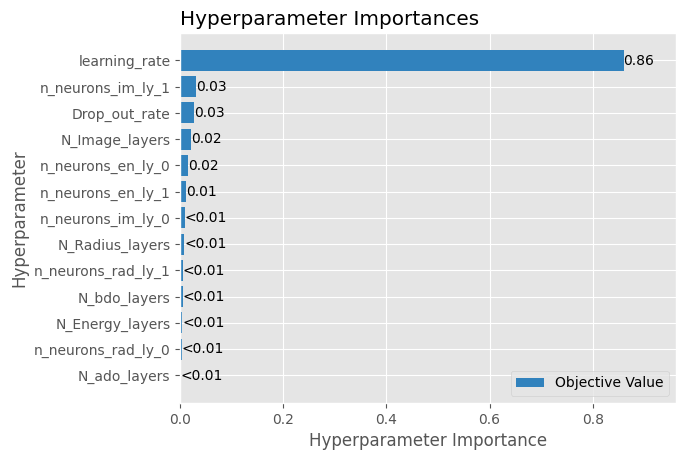

In [18]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.legend(loc = 'lower right')
#plt.savefig('figs/Optimized Models/10x10/Hyperparameter Importance.png', format = 'png', bbox_inches = 'tight')
plt.show()

In [52]:
best_model = create_OP_Model(best_trial)
history = best_model.fit(x = {'image_input': pixel_train, 'energy_input': energy_train, 'radius_input': radi_train},
                    y = {'nu_predict':label_train}, 
                    epochs = 150, 
                    batch_size = 100,
                    validation_split = 0.3,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience = 30, min_delta = 1e-2)],
                    shuffle = True)

Epoch 1/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - AUC: 0.7464 - accuracy: 0.7185 - loss: 0.5885 - val_AUC: 0.3000 - val_accuracy: 0.3233 - val_loss: 1.0153
Epoch 2/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.8878 - accuracy: 0.8068 - loss: 0.4175 - val_AUC: 0.9374 - val_accuracy: 0.8414 - val_loss: 0.3086
Epoch 3/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9653 - accuracy: 0.8978 - loss: 0.2361 - val_AUC: 0.9447 - val_accuracy: 0.8375 - val_loss: 0.3047
Epoch 4/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9843 - accuracy: 0.9311 - loss: 0.1590 - val_AUC: 0.9520 - val_accuracy: 0.8509 - val_loss: 0.3064
Epoch 5/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9899 - accuracy: 0.9456 - loss: 0.1276 - val_AUC: 0.9707 - val_accuracy: 0.8830 - val_loss: 0.2265
Epoch 6/150
1215/1215 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - AUC: 0.9923 - accuracy: 0.9538 - loss: 0.1106 - val_AUC: 0.9816 - val_accuracy: 0.9150 - val_loss: 0.1941
Epoch 7/150
1215/1215

## 3.2 - Train and Validation Progress

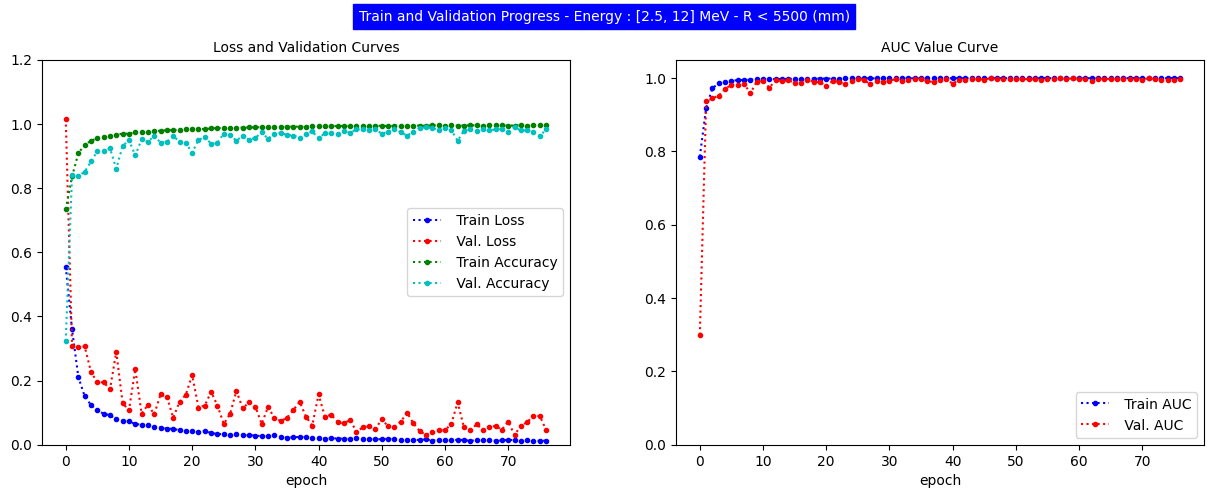

In [53]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
fig, axes = plt.subplots(1,2, figsize=(15, 5))

axes[0].plot(history.history['loss'], 'b:.', label = ' Train Loss')
axes[0].plot(history.history['val_loss'], 'r:.', label = ' Val. Loss')
axes[0].plot(history.history['accuracy'], 'g:.',  label = ' Train Accuracy')
axes[0].plot(history.history['val_accuracy'], 'c:.', label = ' Val. Accuracy')
axes[1].plot(history.history['AUC'], 'b:.',  label = ' Train AUC')
axes[1].plot(history.history['val_AUC'], 'r:.', label = ' Val. AUC')

axes[0].set_title('Loss and Validation Curves', fontsize = 10)
axes[0].set_xlabel('epoch')
axes[0].legend(loc = 'best')
axes[1].set_title('AUC Value Curve', fontsize = 10)
axes[1].set_xlabel('epoch')
axes[1].legend(loc = 'lower right')

axes[0].set_ylim(0, 1.2)
axes[1].set_ylim(0, 1.05)

#axes[0].set_xlim(-2, len(history.history['loss']))
#axes[1].set_xlim(-2, len(history.history['loss']))

fig.suptitle('Train and Validation Progress - Energy : [2.5, 12] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white', fontsize = 10)
plt.savefig('figs/Optimized Models/10x10/Train_Val_progress.png', format = 'png', bbox_inches = 'tight')
plt.show()

## 3.2.1 - Save the Train and Validation Progress of History

In [54]:
#Save training history as Pandas DataFrame
route = 'models/10x10/optimized models/std_transf_and_Std_Norm_Vol_models/Observed Nu Energy for train/train_history_MLM4_5500_(2.5_12)_(-5_7)_aucOP_test_split.csv'

hist_df = pd.DataFrame(history.history)
hist_df.to_csv(route, index=False)

#Read saved learning progress
hist_df = pd.read_csv(route)

In [ ]:
#Plots of learning curves of saved history

fig, axes = plt.subplots(1,2, figsize=(15, 5))

axes[0].plot(hist_df['loss'], 'b:.', label = ' Train Loss')
axes[0].plot(hist_df['val_loss'], 'r:.', label = ' Val. Loss')
axes[0].plot(hist_df['accuracy'], 'g:.',  label = ' Train Accuracy')
axes[0].plot(hist_df['val_accuracy'], 'c:.', label = ' Val. Accuracy')
axes[1].plot(hist_df['AUC'], 'b:.',  label = ' Train AUC')
axes[1].plot(hist_df['val_AUC'], 'r:.', label = ' Val. AUC')

axes[0].set_title('Loss and Validation Curves', fontsize = 10)
axes[0].set_xlabel('epoch')
axes[0].legend(loc = 'best')
axes[1].set_title('AUC Value Curve', fontsize = 10)
axes[1].set_xlabel('epoch')
axes[1].legend(loc = 'lower right')

axes[1].set_ylim(0, 1.05)


fig.suptitle('Train and Validation Progress - Energy : [2.5,12] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white', fontsize = 10)
#plt.savefig('figs/Optimized Models/10x10/Train_Val_progress.png', format = 'png', bbox_inches = 'tight')

# *Save/Load Model

In [84]:
#Save model after training

save = False  #Turn True to save the model!

if save:
    best_model.save('models/10x10/optimized models/std_transf_and_Std_Norm_Vol_models/Observed Nu Energy for train/MLM4_5500_(2.5_12)_(-5_7)_aucOP_test_split.h5')

#Load Model
best_model = tf.keras.models.load_model('models/10x10/optimized models/std_transf_and_Std_Norm_Vol_models/Observed Nu Energy for train/MLM4_5500_(2.5_12)_(-5_7)_aucOP_test_split.h5')
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_0 (Dense)               │ (None, 72)                │           7,272 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_1 (Dense)               │ (None, 56)                │           4,088 │ im_ly_0[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_2 (Dense)               │ (None, 53)                │           3,021 │ im_ly_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_3 (Dense)               │ (None, 52)                │           2,808 │ im_ly_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_4 (Dense)               │ (None, 51)                │           2,703 │ im_ly_3[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_5 (Dense)               │ (None, 50)                │           2,600 │ im_ly_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_6 (Dense)               │ (None, 50)                │           2,550 │ im_ly_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_7 (Dense)               │ (None, 50)                │           2,550 │ im_ly_6[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ im_ly_8 (Dense)               │ (None, 50)                │           2,550 │ im_ly_7[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ energy_input (InputLayer)     │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ radius_input (InputLayer)     │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 52)                │               0 │ im_ly_8[0][0],             │
│                               │                           │                 │ energy_input[0][0],        │
│                               │                           │                 │ radius_input[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_ly_0 (Dense)              │ (None, 80)                │           4,240 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_layer1 (Dense)            │ (None, 30)                │           2,430 │ bdo_ly_0[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_layer2 (Dense)            │ (None, 30)                │             930 │ bdo_layer1[0][0]           │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 39,916 (155.93 KB)

 Trainable params: 39,914 (155.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# 4 - Observation and Analysis of Predictions

### 4.1.1 - NN Prediction

In [85]:
X_sig_pred = best_model.predict([pixel_sig_test_2_transf, energy_sig_test_2_transf, radi_sig_test_2_transf])
X_bkg_pred = best_model.predict([pixel_bkg_test_2_transf, energy_bkg_test_2_transf, radi_bkg_test_2_transf])

727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
727/727 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


### 4.1.2 - Analysis of Predictions

In [86]:
X_sig_pred

array([[9.9868029e-01, 1.3939821e-03],
       [1.0000000e+00, 9.5419122e-14],
       [9.2412269e-01, 7.5883061e-02],
       ...,
       [1.0000000e+00, 1.9361492e-09],
       [9.9999988e-01, 1.2061672e-07],
       [1.0000000e+00, 6.5567880e-15]], dtype=float32)

In [59]:
X_bkg_pred

array([[1.3717811e-09, 1.0000000e+00],
       [9.8046309e-25, 1.0000000e+00],
       [1.8125954e-10, 1.0000000e+00],
       ...,
       [5.1713675e-02, 9.4878697e-01],
       [1.9292848e-13, 1.0000000e+00],
       [2.3962783e-05, 9.9997413e-01]], dtype=float32)

In [60]:
print('working with ' + str(len(X_sig_pred)) + ' of signal and ' + str(len(X_bkg_pred)) + ' of background as testing data')

working with 23246 of signal and 23246 of background as testing data


### 4.1.3 - Representation of Predictions

#### Distribution of Probabilities

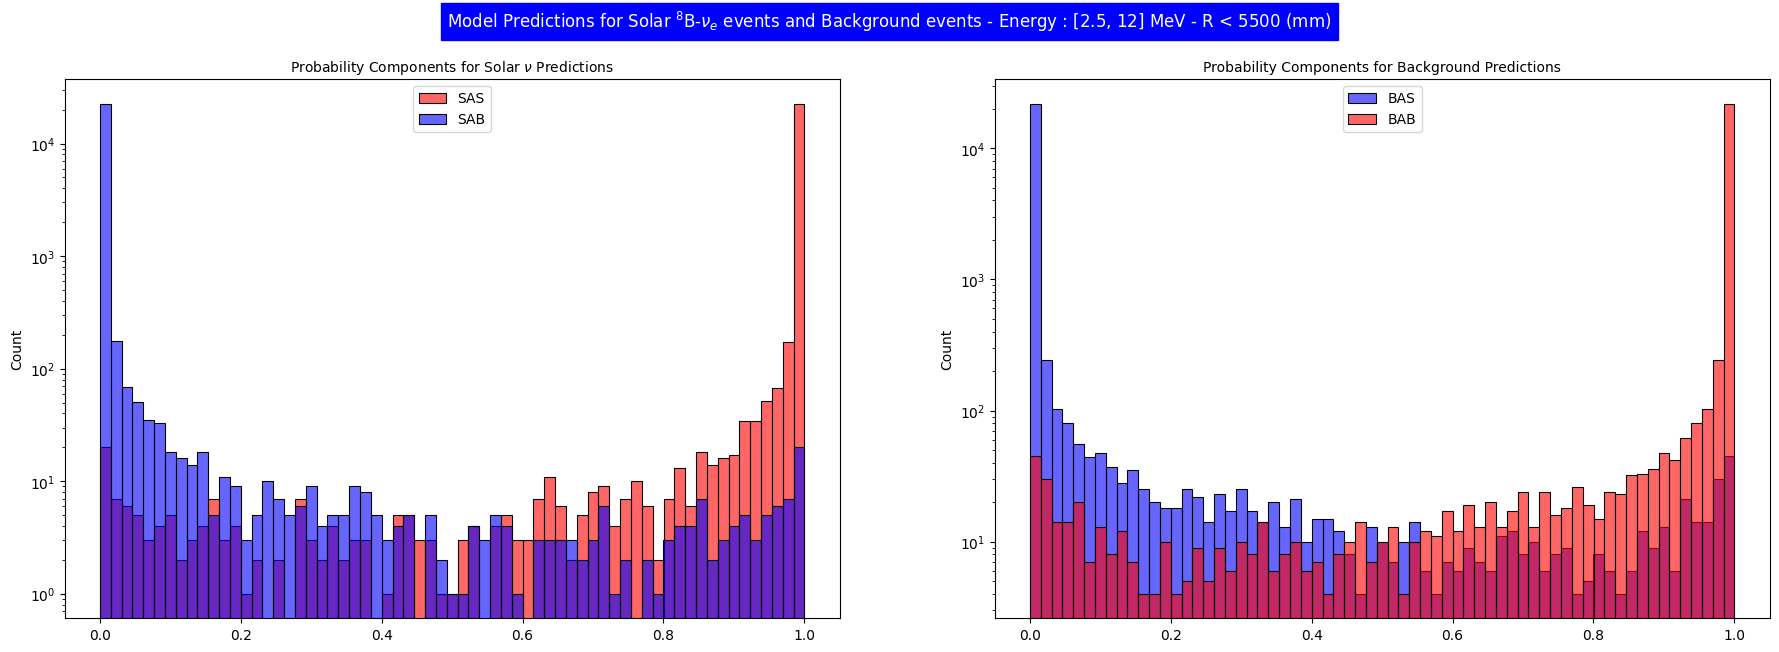

In [68]:
sn.reset_orig
bins = 65
fig, axes = plt.subplots(1, 2,  figsize=(22, 7))

sn.histplot(X_sig_pred[:,0], bins = bins, label = 'SAS', color = 'r', alpha = 0.6, ax = axes[0], log = True)
sn.histplot(X_sig_pred[:,1], bins = bins, label = 'SAB', color = 'b', alpha = 0.6, ax = axes[0])
sn.histplot(X_bkg_pred[:,0], bins = bins, label = 'BAS',color = 'b', alpha = 0.6, ax = axes[1], log = True)
sn.histplot(X_bkg_pred[:,1], bins = bins, label = 'BAB', color = 'r', alpha = 0.6, ax = axes[1])
axes[0].set_title('Probability Components for Solar $ν$ Predictions', fontsize = 10)
axes[1].set_title('Probability Components for Background Predictions', fontsize = 10)
axes[0].legend(loc = 'best')
axes[1].legend(loc = 'best')
plt.suptitle('Model Predictions for Solar $^8$B-$ν_e$ events and Background events - Energy : [2.5, 12] MeV - R < 5500 (mm)', backgroundcolor='blue', color='white')
#plt.savefig('figs/Optimized Models/10x10/probability_predictions1.png', format = 'png', bbox_inches = 'tight')
plt.show()

- Deviation from Predictions

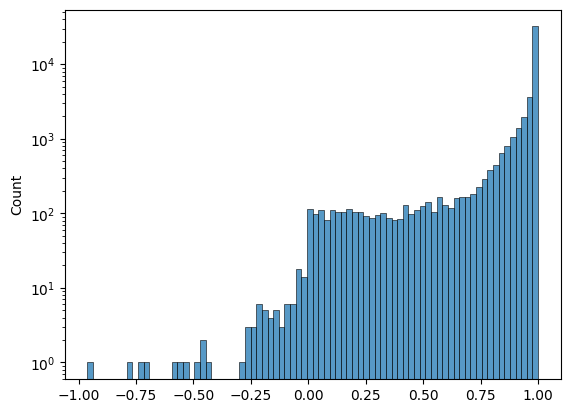

In [30]:
prob_SAS = X_sig_pred[:,0]
prob_BAS = X_bkg_pred[:,0]

dif = prob_SAS - prob_BAS[:prob_SAS.shape[0]]

#Expected:
X_exp_nu = df_label_sig_test.values[:,0]
X_exp_tl = df_label_bkg_test.values[:,1]
X_exp = np.concatenate((X_exp_nu, X_exp_tl))

deviation = X_exp - X_pred_as_true
sn.histplot(dif, bins = 80)
plt.yscale('log')
plt.show()

### 4.1.4 - ROC Curve

In [69]:
X_pred = np.concatenate((X_sig_pred, X_bkg_pred))        #Predicted
X_exp = np.concatenate((df_label_sig_test_2, df_label_bkg_test_2)) #Expected

# Classification for solar_nu events
fpr_sig, tpr_sig, thresholds_sig = roc_curve(X_exp[:,0], X_pred[:,0])
auc_sig = auc(fpr_sig, tpr_sig)

# Classification for bkg events
fpr_bkg, tpr_bkg, thresholds_bkg = roc_curve(X_exp[:,1], X_pred[:,1])
auc_bkg = auc(fpr_bkg, tpr_bkg)

# Classification overall Model

fpr, tpr, thresholds = roc_curve(np.concatenate((X_exp[:,0], X_exp[:,1])), np.concatenate((X_pred[:,0], X_pred[:,1])))
auc_val = auc(fpr, tpr)

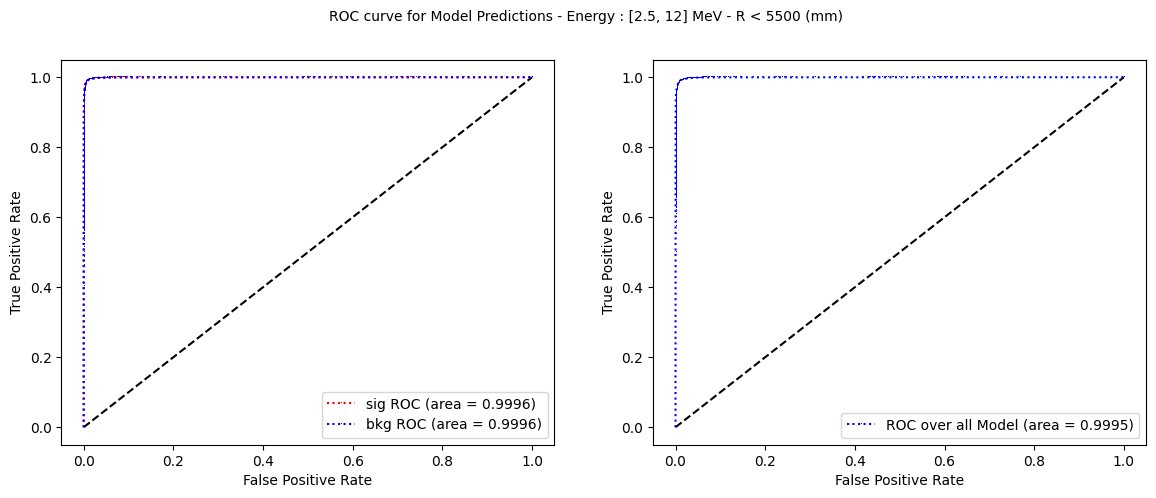

In [70]:
fig, axes = plt.subplots(1, 2,  figsize=(14, 5))


axes[0].plot([0, 1], [0, 1], 'k--') #x=y
axes[0].plot(fpr_sig, tpr_sig, 'r:,', label = 'sig ROC (area = {:.4f})'.format(auc_sig))
axes[0].plot(fpr_bkg, tpr_bkg, 'b:,', label = 'bkg ROC (area = {:.4f})'.format(auc_bkg))

axes[1].plot([0, 1], [0, 1], 'k--') #x=y
axes[1].plot(fpr, tpr, 'b:,', label = 'ROC over all Model (area = {:.4f})'.format(auc_val))

axes[0].set_ylabel('True Positive Rate')
axes[0].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')

axes[0].legend(loc = 'lower right')
axes[1].legend(loc = 'lower right')

fig.suptitle('ROC curve for Model Predictions - Energy : [2.5, 12] MeV - R < 5500 (mm)', fontsize = 10)

#plt.savefig('figs/Optimized Models/10x10/ROC.png', format = 'png', bbox_inches = 'tight')
plt.show()

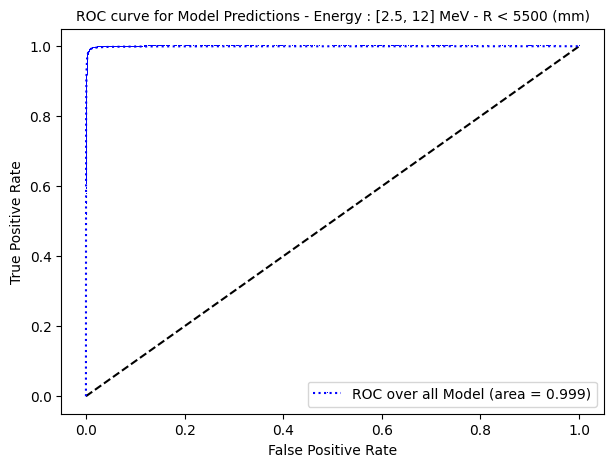

In [60]:
#ROC Curve Model

plt.figure(figsize = ((7, 5)))

plt.plot([0, 1], [0, 1], 'k--') #x=y

plt.plot(fpr, tpr, 'b:,', label = 'ROC over all Model (area = {:.3f})'.format(auc_val))

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc = 'lower right')

plt.title('ROC curve for Model Predictions - Energy : [2.5, 12] MeV - R < 5500 (mm)', fontsize = 10)

#plt.savefig('figs/Optimized Models/10x10/ROC_model.png', format = 'png', bbox_inches = 'tight')
plt.show()

### 4.1.5 - Reconstrucción de espector de solar $ν_e$ y de Tálio

Seran seleccionados unicamente energias de eventos de neutrinos solar con un predicción X_pred[:,0] > threshold para ver que tan bueno se reconstruye el espectro de neutrinos solares. Los mismo para eventos de Tálio. Asi, podra ser observado en que energias el modelo tiene mas dificultades en acertar predicciones

#### Recuperar Valores de Energia y Radio (Inverse Standard Scaler) y Normalización en Volumen

In [71]:
energy_sig_rc = scaler_en_sig.inverse_transform([energy_sig_test_2_transf])[0]
energy_bkg_rc = scaler_en_bkg.inverse_transform([energy_bkg_test_2_transf])[0]

radi_sig_rc = scaler_rad_sig.inverse_transform([radi_sig_test_2_transf])[0]
radi_bkg_rc = scaler_rad_bkg.inverse_transform([radi_bkg_test_2_transf])[0]

# Volume Normalization: a formula es (R_ev^3)/(5000^3) y queremos recuperar R_ev
#radi_sig_rc = np.cbrt(radi_sig_test_transf*vol).values.T[0]
#radi_bkg_rc = np.cbrt(radi_bkg_test_transf*vol).values.T[0]

# Volume Normalization + Std Scaler: a formula es (R_ev^3)/(5000^3) y queremos recuperar R_ev
radi_sig_rc = np.cbrt(radi_sig_rc*vol)
radi_bkg_rc = np.cbrt(radi_bkg_rc*vol)

In [72]:
radi_sig_rc

array([2595.60986328, 4248.24414062, 4226.43457031, ..., 3645.08959961,
       3180.03588867, 3354.98486328])

In [73]:
max(energy_sig_rc)

11.990849494934082

In [74]:
max(radi_sig_rc)

5499.9716796875

### 4.1.6 - Normalized Efficiency by N_Counts(true)

Construir un plot de eficicencia normalizada por el numero total de eventos en un bin del plot "Separated Spectrums for Threshold (trh)".
Procedimientos de construcción:

1) extraer valores de energia contenidos en cada bin de "Separated Spectrums for Threshold (trh)"
2) Contabilizar el nº de eventos que superan el treshold dentro del bin de energia, y dividir por el número de eventos contenido en el bin, esta será la eficiencia normalizado por N_events_true
3) Hacer plot de la eficiciencia normalizada en funcion del valor medio de las energias contenida en el bin (cuanto mas bins, mas puntos de eficiencia habra)

### 4.1.7 - Graficos de Energia Reconstruida y de Eficiencia Normalizada para varios Threshold de Predicción del Modelo

##### Extraer Información para los Gráficos

In [75]:
#Idea: A cada loop de thr, agregar a las listas arrays de energia reconstruida y de eficiciencia normalizada, asi cada indice de lista corresponde a un thr

bins_nu = 20             #-> Define how many intervals in energy. Equals to the number of point of norm_eff. PREDEFINED BINS = 20
bins_tl = 8              #-> BINS = 8

thr = [0.95, 0.8, 0.70]  #-> Define the thresholds

prob_sas = X_sig_pred[:,0]      #probiblity of the event of neutrino being detected as neutrino
#prob_bab = X_bkg_pred[:,1]      #probiblity of the event of thallium being detected as thallium
prob_bas = X_bkg_pred[:,0]      #probiblity of the event of thallium being detected as neutrino

en_sig_test_count, en_sig_test_edge = np.histogram(energy_sig_rc, bins = bins_nu)   #Extract interval of binned data
en_bkg_test_count, en_bkg_test_edge = np.histogram(energy_bkg_rc, bins = bins_tl)   #Extract interval of binned data


N_edges_sig = len(en_sig_test_edge)
N_edges_bkg = len(en_bkg_test_edge)

#Information to extract--------------------------------------
nu_energy_in_sas = []
#nu_energy_out_sas = []

tl_energy_in_bas = []
#tl_energy_out_bab = []

#mean normalized eficiency values for signal as signal and bkg as sig
norm_eff_sig_in_sas = []
norm_eff_bkg_in_bas = []

norm_eff_bkg = []

#mean energy within each bin for signal and bkg data
mean_energy_sig = []  
mean_energy_bkg = []   

for thr_i in thr: 

    #Information to save in each loop of threshold --------------
    nu_energy_in_sas_thr = []
    #nu_energy_out_sas_thr = []
    
    tl_energy_in_bas_thr = []
    #tl_energy_out_bas_thr = []

    #normalized eficiency values for signal and bkg for each thr
    #Used to contruct the norm eff plot
    norm_eff_sig_in_sas_thr = np.array([])
    norm_eff_bkg_in_bas_thr = np.array([])

    #mean energy within each bin for signal and bkg data for each thr (aunque acaba siendo el mismo valor medio para cado thr y para los histogramas que preservan el número de bins).
    #Used to contruct the norm eff plot
    mean_energy_sig_thr = np.array([]) 
    mean_energy_bkg_thr = np.array([]) 

    #mean radial values within each bin for signal and bkg data for each thr
    #Used to contruct the norm eff plot
    mean_rad_sig_thr = np.array([]) 
    mean_rad_bkg_thr = np.array([]) 
    
    #----------------------------------------------

    #Extract info for Plot of energy > thr and energy < thr

    #Extract
    for i in np.where(prob_sas >= thr_i)[0]:
        nu_energy_in_sas_thr.append(energy_sig_rc[i])
        
    #for j in np.where(prob_sas < thr_i)[0]:
        #nu_energy_out_sas_thr.append(energy_sig_rc[j])
    
    for m in np.where(prob_bas >= thr_i)[0]:
        tl_energy_in_bas_thr.append(energy_bkg_rc[m])
    
    #for k in np.where(prob_bab < thr_i)[0]:
        #tl_energy_out_spectrum_thr.append(energy_bkg_rc[k])
        
    nu_energy_in_sas.append(np.array(nu_energy_in_sas_thr))
    #nu_energy_out_sas.append(np.array(nu_energy_out_sas_thr))
    tl_energy_in_bas.append(np.array(tl_energy_in_bas_thr))
    #tl_energy_out_bab.append(np.array(tl_energy_out_spectrum_thr))

    #Extract norm_eff and mean nu enery within each bin:
    #1) Extract for solar nu event predictions
    for i in range(N_edges_sig-1):
        #extract edges value of energy at each bin
        energy_edge_i = en_sig_test_edge[i]
        energy_edge_f = en_sig_test_edge[i+1]
    
        #find energy in energy_test_sig between edges values and the model prediction for SAS 
        energy_interval = np.extract((energy_sig_rc >= energy_edge_i) & (energy_sig_rc <= energy_edge_f), energy_sig_rc)
        prob_sas_interval = np.extract((energy_sig_rc >= energy_edge_i) & (energy_sig_rc <= energy_edge_f), prob_sas)
    
        #extract mean energy of binned interval
        mean_energy_interval = np.mean(energy_interval)
        
        mean_energy_sig_thr = np.append(mean_energy_sig_thr, mean_energy_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_sas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_sas_interval >= thr_i
        energy_up_thr = np.extract(condition_thr, energy_interval)
        N_up_thr = len(energy_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_sig_in_sas_thr = np.append(norm_eff_sig_in_sas_thr, norm_eff_interval)

    norm_eff_sig_in_sas.append(norm_eff_sig_in_sas_thr)
    mean_energy_sig.append(mean_energy_sig_thr)
        
    #2) Extract for Tl event predictions
    for i in range(N_edges_bkg-1):
        #extract edges value of energy at each bin
        energy_edge_i = en_bkg_test_edge[i]
        energy_edge_f = en_bkg_test_edge[i+1]
    
        #find energy in energy_test_bkg between edges values and the model prediction for BAS
        energy_interval = np.extract((energy_bkg_rc >= energy_edge_i) & (energy_bkg_rc <= energy_edge_f), energy_bkg_rc)
        prob_bas_interval = np.extract((energy_bkg_rc >= energy_edge_i) & (energy_bkg_rc <= energy_edge_f), prob_bas)
    
        #extract mean energy of binned interval
        mean_energy_interval = np.mean(energy_interval)
        
        mean_energy_bkg_thr = np.append(mean_energy_bkg_thr, mean_energy_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_bas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_bas_interval >= thr_i
        energy_up_thr = np.extract(condition_thr, energy_interval)
        N_up_thr = len(energy_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_bkg_in_bas_thr = np.append(norm_eff_bkg_in_bas_thr, norm_eff_interval)
    
    norm_eff_bkg_in_bas.append(norm_eff_bkg_in_bas_thr)
    mean_energy_bkg.append(mean_energy_bkg_thr)

#Transform lists to array where each arrow correspond to the values of (energy, norm_eff) for a certain thr
mean_energy_sig = np.array(mean_energy_sig)
norm_eff_sig_in_sas = np.array(norm_eff_sig_in_sas)

mean_energy_bkg = np.array(mean_energy_bkg)
norm_eff_bkg_in_bas = np.array(norm_eff_bkg_in_bas)

In [76]:
norm_eff_sig_in_sas

array([[0.98271516, 0.98244914, 0.97959184, 0.97980251, 0.97728395,
        0.97890507, 0.9796529 , 0.98095238, 0.98325723, 0.98129093,
        0.98165138, 0.99626866, 0.98981324, 0.98352941, 0.99408284,
        0.98770492, 0.99390244, 0.99152542, 0.97674419, 1.        ],
       [0.99459849, 0.99242122, 0.98938776, 0.98877917, 0.98666667,
        0.99146158, 0.98982645, 0.98571429, 0.99086758, 0.9878391 ,
        0.98878695, 0.99626866, 0.99320883, 0.98823529, 0.99704142,
        0.99590164, 0.99390244, 0.99152542, 0.97674419, 1.        ],
       [0.99567879, 0.99321899, 0.99183673, 0.99147217, 0.98814815,
        0.99397288, 0.9904249 , 0.98639456, 0.99391172, 0.99251637,
        0.99184506, 0.99626866, 0.99490662, 0.99294118, 0.99704142,
        0.99590164, 0.99390244, 0.99152542, 0.97674419, 1.        ]])

#### Construir los Gráficos

- Energia

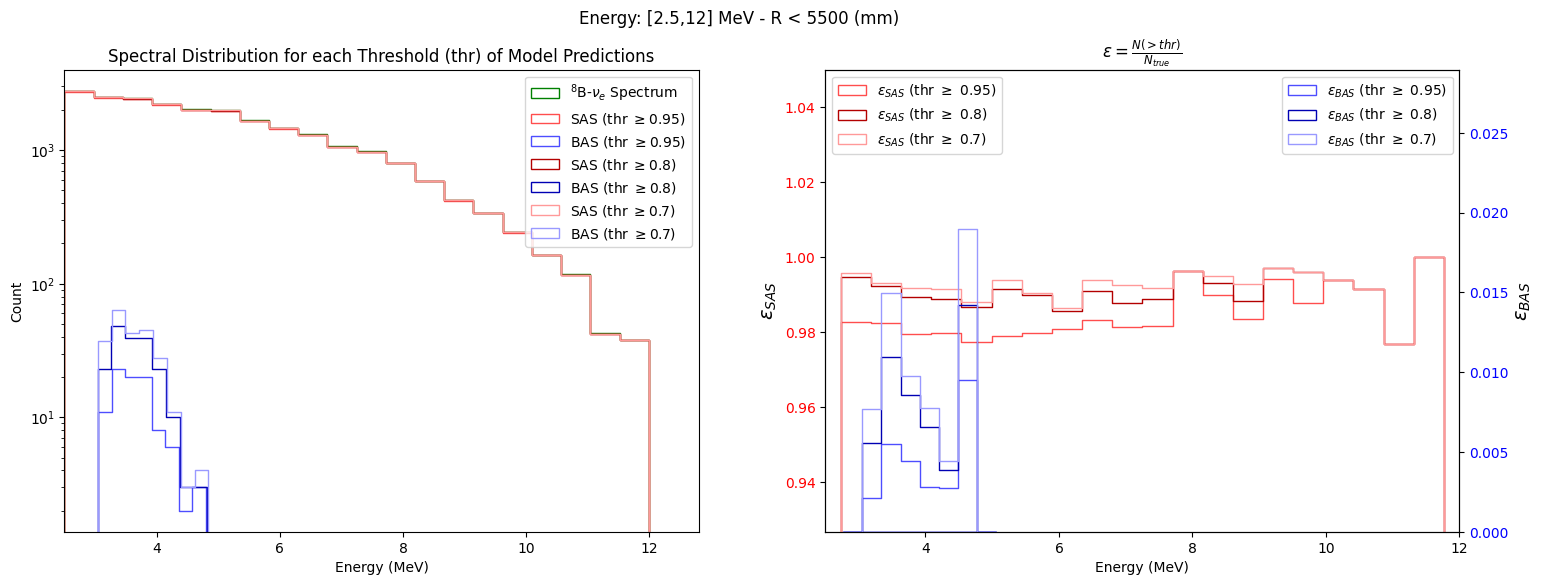

In [78]:
bas_on = True
alpha = 0

#main plot: Test Solar Energy
fig, axes = plt.subplots(1,2, figsize =(18, 6)) 
ax1_1 = axes[1].twinx()  #Right axis for the norm_eff plot due to differences between eff scales

sn.histplot(energy_sig_rc, ax = axes[0], bins = bins_nu, color = 'g' , label = r'$^8$B-$ν_e$ Spectrum', alpha = alpha, element = 'step')

#if bkg_on:
#Bkg test energy plot
#    sn.histplot(energy_bkg_rc, ax = axes[0], bins = bins_tl, color = 'black' , label = r'208-Tl Spectrum', alpha = alpha, element = 'step')

for i_dx, thr_i in enumerate(thr):  
    #Sig Spectral distribution
    sn.histplot(nu_energy_in_sas[i_dx], ax = axes[0], bins = bins_nu, color = red_variants[i_dx] , label = r'SAS (thr $\geq$'+str(thr_i)+')', 
                alpha = alpha, element = 'step')

    #Sig Efficiency normalized by N_true counts
    sn.histplot(x = mean_energy_sig[i_dx], ax = axes[1], bins=len(mean_energy_sig[i_dx]), color = red_variants[i_dx], 
                weights=norm_eff_sig_in_sas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{SAS}$ (thr $\geq$ '+str(thr_i)+')')

    if bas_on:
        #bkg spectra
        sn.histplot(tl_energy_in_bas[i_dx], ax = axes[0], bins = bins_tl, color = blue_variants[i_dx] , label = r'BAS (thr $\geq$'+str(thr_i)+')', 
                    alpha = alpha, element = 'step')

        #bkg efficiency
        sn.histplot(x = mean_energy_bkg[i_dx], ax = ax1_1, bins=len(mean_energy_bkg[i_dx]), color = blue_variants[i_dx], 
                    weights=norm_eff_bkg_in_bas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{BAS}$ (thr $\geq$ '+str(thr_i)+')')
        

axes[0].set_title(r'Spectral Distribution for each Threshold (thr) of Model Predictions', fontsize = 12)
axes[1].set_title(r'$\epsilon = \frac{N(>thr)}{N_{true}}$', fontsize = 12)
axes[0].legend(loc = 'upper right')
axes[1].legend(loc = 'upper left')
ax1_1.legend(loc = 'upper right')

axes[0].set_xlabel('Energy (MeV)')
axes[1].set_xlabel('Energy (MeV)')
axes[1].set_ylabel(r'$\epsilon_{SAS}$', fontsize = 14)
ax1_1.set_ylabel(r'$\epsilon_{BAS}$', fontsize = 14)

axes[1].tick_params(axis='y', labelcolor='r')
ax1_1.tick_params(axis='y', labelcolor='b')


#Agregar marcadores al eje x
#x_en_ticks = np.arange(2.5, 12, 1)   #(x_min, x_max, step)
#axes[0].x_en_ticks(x_ticks)
#axes[1].x_en_ticks(x_ticks)


axes[0].set_xlim(2.5,12.8)
axes[1].set_xlim(2.5,12)
axes[1].set_ylim(np.min(norm_eff_sig_in_sas) - 0.05, 1.05)
ax1_1.set_ylim(0.0, np.max(norm_eff_bkg_in_bas) + 0.01)

axes[0].set_yscale('log')
#axes[1].set_yscale('log')
plt.suptitle('Energy: [2.5,12] MeV - R < 5500 (mm)')

if bas_on:
    plt.savefig('figs/Optimized Models/10x10/Spectral_thr_and_Norm_eff_sig_bkg.png', format = 'png', bbox_inches = 'tight')
else:
    plt.savefig('figs/Optimized Models/10x10/Spectral_thr_and_Norm_eff.png', format = 'png', bbox_inches = 'tight')
plt.show()

In [79]:
# Mean eficiency calculation in [2.5,10] for each thr in SAS

mean_eff = []  # List with the values of the mean efficicency for each threshold in energy within a range [2.5,10] MeV
eff_error = [] # list with the error value associated to hte mean_eff by the maximum desviation.
results = []   # List with explicit result of the thr and mean value of efficiency

for i_dx, thr_i in enumerate(thr):

    eff_sas_thr = norm_eff_sig_in_sas[i_dx]
    energy_sas_thr = mean_energy_sig[i_dx]
    
    #Extract the values of efficiency which verifies the energy cut
    condition = (energy_sas_thr <= 10)
    eff_sas_filter = np.extract(condition, eff_sas_thr)

    #Obtain mean value as the mean percentage of events in thr which are truly solar nu
    mean_eff_sas_thr = np.mean(eff_sas_filter, dtype = np.float16)
    mean_eff.append(mean_eff_sas_thr)

    #Compute the eff error by the maximum deviation of the samples from the mean value
    deviations = abs(eff_sas_thr -  mean_eff_sas_thr)
    max_deviation = np.max(deviations)
    eff_error.append(max_deviation)

    result_thr = 'For thr='+str(thr_i) + r', the eff for SAS is = ' + str(mean_eff_sas_thr) + ' with an error of ' + str(max_deviation)
    results.append(result_thr)

In [80]:
mean_eff

[0.984, 0.991, 0.993]

In [81]:
eff_error

[0.01611328125, 0.014466751453488413, 0.016419876453488413]

In [82]:
results

['For thr=0.95, the eff for SAS is = 0.984 with an error of 0.01611328125',
 'For thr=0.8, the eff for SAS is = 0.991 with an error of 0.014466751453488413',
 'For thr=0.7, the eff for SAS is = 0.993 with an error of 0.016419876453488413']

- Radius

In [58]:
#Idea: A cada loop de thr, agregar a las listas arrays de energia reconstruida y de eficiciencia normalizada, asi cada indice de lista corresponde a un thr

bins_rad = 20            #-> BINS = 20
thr = [0.95, 0.8, 0.70]  #-> Define the thresholds

prob_sas = X_sig_pred[:,0]
prob_bas = X_bkg_pred[:,0]

rad_sig_test_count, rad_sig_test_edge = np.histogram(radi_sig_rc, bins = bins_rad)
rad_bkg_test_count, rad_bkg_test_edge = np.histogram(radi_bkg_rc, bins = bins_rad)

N_edges= len(rad_sig_test_edge)

#mean normalized eficiency values for signal and bkg
norm_eff_sig_in_sas = []
norm_eff_bkg_in_bas = []  

#mean radial values within each bin for signal and bkg data
mean_rad_sig = []
mean_rad_bkg = []

for thr_i in thr: 

    #mean normalized eficiency values for signal and bkg for each thr
    norm_eff_sig_in_sas_thr = np.array([])
    norm_eff_bkg_in_bas_thr = np.array([])
    
    #mean radial values within each bin for signal and bkg data for each thr
    mean_rad_sig_thr = np.array([]) 
    mean_rad_bkg_thr = np.array([]) 
    
    #----------------------------------------------

    #Extract norm_eff and mean radius within each bin:
    #1) Extract for solar nu event predictions
    for i in range(N_edges-1):
        #extract edges value of energy at each bin
        radi_edge_i = rad_sig_test_edge[i]
        radi_edge_f = rad_sig_test_edge[i+1]
    
        #find energy in energy_test_sig and energy_test_bkg between edges values is and the model prediction
        radi_interval = np.extract((radi_sig_rc >= radi_edge_i) & (radi_sig_rc <= radi_edge_f), radi_sig_rc)
        prob_sas_interval = np.extract((radi_sig_rc >= radi_edge_i) & (radi_sig_rc <= radi_edge_f), prob_sas)
    
        #extract and save the mean radi of binned interval
        mean_rad_interval = np.mean(radi_interval)
        mean_rad_sig_thr = np.append(mean_rad_sig_thr, mean_rad_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_sas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_sas_interval >= thr_i
        radi_up_thr = np.extract(condition_thr, radi_interval)
        N_up_thr = len(radi_up_thr)
    
        #compute and extract normalized efficiency
        norm_eff_interval = N_up_thr / N_true
        norm_eff_sig_in_sas_thr = np.append(norm_eff_sig_in_sas_thr, norm_eff_interval)

    norm_eff_sig_in_sas.append(norm_eff_sig_in_sas_thr)
    mean_rad_sig.append(mean_rad_sig_thr)
        
    #2) Extract for Tl event predictions
    for i in range(N_edges-1):
        #extract edges value of radius at each bin
        radi_edge_i = rad_bkg_test_edge[i]
        radi_edge_f = rad_bkg_test_edge[i+1]
    
        #find energy in energy_test_sig and energy_test_bkg between edges values is and the model prediction
        radi_interval = np.extract((radi_bkg_rc >= radi_edge_i) & (radi_bkg_rc <= radi_edge_f), radi_bkg_rc)
        prob_bas_interval = np.extract((radi_bkg_rc >= radi_edge_i) & (radi_bkg_rc <= radi_edge_f), prob_bas)
    
        #extract and save the mean radi of binned interval
        mean_rad_interval = np.mean(radi_interval)
        mean_rad_bkg_thr = np.append(mean_rad_bkg_thr, mean_rad_interval)
        
        #Total Number of events we know are true
        N_true = len(prob_bas_interval)
    
        #find where prob. is higher than threshold and count
        condition_thr = prob_bas_interval >= thr_i
        radi_up_thr = np.extract(condition_thr, radi_interval)
        N_up_thr = len(radi_up_thr)
    
        #compute and extract value of normalized efficiency for each bin
        norm_eff_interval = N_up_thr / N_true
        norm_eff_bkg_in_bas_thr = np.append(norm_eff_bkg_in_bas_thr, norm_eff_interval)
    
    norm_eff_bkg_in_bas.append(norm_eff_bkg_in_bas_thr)
    mean_rad_bkg.append(mean_rad_bkg_thr)
    

#Transform lists to array where each arrow correspond to the values of (energy, norm_eff) for a certain thr
mean_rad_sig = np.array(mean_rad_sig)
norm_eff_sig_in_sas = np.array(norm_eff_sig_in_sas)

mean_rad_bkg = np.array(mean_rad_bkg)
norm_eff_bkg_in_bas = np.array(norm_eff_bkg_in_bas)

In [59]:
norm_eff_sig_in_sas

array([[0.78571429, 0.87272727, 0.92941176, 0.92307692, 0.93467337,
        0.94480519, 0.92567568, 0.94525547, 0.95015106, 0.95981087,
        0.9622824 , 0.96467818, 0.96203438, 0.97899729, 0.96579369,
        0.975333  , 0.97998259, 0.98040722, 0.98031768, 0.98585991],
       [0.92857143, 0.96363636, 0.94117647, 0.94674556, 0.97487437,
        0.96753247, 0.96171171, 0.97262774, 0.97129909, 0.9751773 ,
        0.98259188, 0.98430141, 0.98065903, 0.98915989, 0.98503474,
        0.9876665 , 0.99042646, 0.98962735, 0.98722376, 0.99408089],
       [0.92857143, 0.96363636, 0.94117647, 0.94674556, 0.98492462,
        0.96753247, 0.96846847, 0.97992701, 0.97885196, 0.9751773 ,
        0.98742747, 0.98822606, 0.98710602, 0.99186992, 0.98824158,
        0.98963986, 0.99260226, 0.99116404, 0.99033149, 0.99539625]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


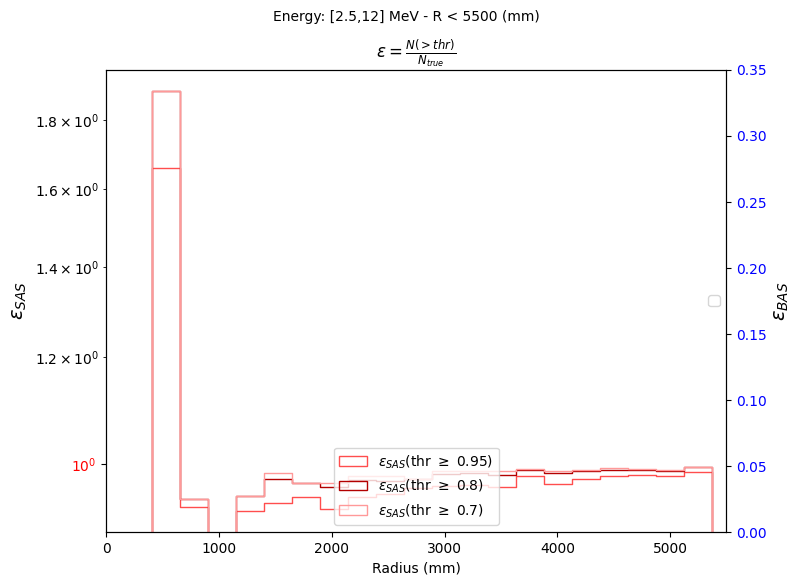

In [60]:
bas_on = False

#main plot: Test Solar radius vs. Normalized efficiency
fig, axes_1 = plt.subplots(figsize =(8, 6))
axes_2 = axes_1.twinx()

for i_dx, thr_i in enumerate(thr):  
    #Sig Efficiency normalized by N_true counts
    sn.histplot(x = mean_rad_sig[i_dx], ax = axes_1,bins = len(mean_rad_sig[i_dx]), color = red_variants[i_dx], 
                weights = norm_eff_sig_in_sas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{SAS}$(thr $\geq$ '+str(thr_i)+')')

    if bas_on:
        #bkg efficiency
        sn.histplot(x = mean_rad_bkg[i_dx], ax = axes_2, bins=len(mean_rad_bkg[i_dx]), color = blue_variants[i_dx], kde=False,
                    weights = norm_eff_bkg_in_bas[i_dx], element = 'step', alpha = 0.0, label = r'$\epsilon_{BAS}$(thr $\geq$ '+str(thr_i)+')')
        

plt.suptitle('Energy: [2.5,12] MeV - R < 5500 (mm)', fontsize = 10)
axes_1.set_title(r'$\epsilon = \frac{N(>thr)}{N_{true}}$', fontsize = 12)
axes_1.legend(loc = 'lower center')
axes_2.legend(loc = 'center right')

axes_1.tick_params(axis='y', labelcolor='r')
axes_2.tick_params(axis='y', labelcolor='b')


axes_1.set_xlabel('Radius (mm)')
axes_1.set_ylabel(r'$\epsilon_{SAS}$', fontsize = 14)
axes_2.set_ylabel(r'$\epsilon_{BAS}$', fontsize = 14)

axes_1.set_xlim(0, 5500.0)
axes_2.set_ylim(0, np.max(norm_eff_bkg_in_bas) + 0.15)
axes_1.set_yscale('log')

#if bas_on:
#    plt.savefig('figs/Optimized Models/10x10/Radial_sig_bkg_thr_and_Norm_eff.png', format = 'png', bbox_inches = 'tight')
#else:
#    plt.savefig('figs/Optimized Models/10x10/Radial_thr_and_Norm_eff.png', format = 'png', bbox_inches = 'tight')
plt.show()

### 4.1.6 - Efficience curve of predictions

Representar curva de eficiencia de las prediciones del modelo (sig=X_pred[:0], bkg=X_pred[:1]) en función de la energia y el radio del evento

In [53]:
#Efficiencia = Prob. de estar correcta la prediccion
X_sig_eff = X_sig_pred[:,0]
X_bkg_eff = X_bkg_pred[:,1]

x = np.concatenate((energy_sig_rc, energy_bkg_rc))
y = np.concatenate((radi_sig_rc, radi_bkg_rc))
z = np.concatenate((X_sig_eff, X_bkg_eff))

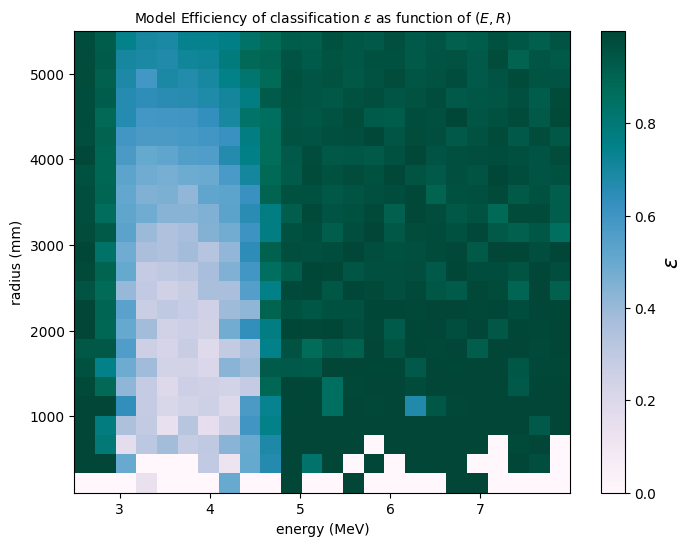

In [54]:
bins = 25

# Definir los límites y número de bins
x_edges = np.linspace(x.min(), x.max(), bins)
y_edges = np.linspace(y.min(), y.max(), bins)

# Inicializar una matriz para almacenar los valores de z
hist = np.zeros((len(x_edges)-1, len(y_edges)-1))

# Calcular los valores de z en cada bin
for i in range(len(x_edges)-1):
    for j in range(len(y_edges)-1):
        mask = (x >= x_edges[i]) & (x < x_edges[i+1]) & (y >= y_edges[j]) & (y < y_edges[j+1])
        if np.sum(mask) > 0:
            hist[i, j] = np.mean(z[mask])  # Otras estadísticas podrían ser np.sum, np.median, etc.

# Crear el plot
fig, ax = plt.subplots(figsize=(8,6))
c = ax.pcolormesh(x_edges, y_edges, hist.T, shading='auto', cmap = cm.PuBuGn)
cbar = fig.colorbar(c, ax=ax)

# Agregar un título a la barra de color
cbar.set_label('$ε$', fontsize = 15)

ax.set_xlabel('energy (MeV)')
ax.set_ylabel('radius (mm)')
ax.set_title('Model Efficiency of classification $ε$ as function of $(E,R)$', fontsize = 10)
#plt.xlim(0.5,16)
#plt.ylim(0,5500)
#plt.savefig('figs/Optimized Models/10x10/Eff_of_clasification(E,R).png', format = 'png', bbox_inches = 'tight')
plt.show()